##Load in libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy import linalg as la
import pandas as pd
import ntpath
import os
import re
from skimage.io import imread, imsave, imshow
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from skimage.draw import polygon2mask

#Get from Drive the folder libraries
!cp -r /content/drive/MyDrive/libraries /content
from libraries.track_functions import *

sns.set_theme(style="whitegrid")

!mkdir figures

In [6]:
!pip install heteromotility

     |████████████████████████████████| 58 kB 3.3 MB/s 
  Created wheel for heteromotility: filename=heteromotility-0.1.9-py3-none-any.whl size=31034 sha256=5001c06425620dd391a398cda650a58e3fd9a5e973aa3d908036f4db1360f43e
  Stored in directory: /root/.cache/pip/wheels/af/a6/35/f1e46ee25a987ea88ae936b0b92ae7a0731ddb932232c4e922
Successfully built heteromotility


##Define functions

In [7]:
#gets rid of extra spaces and brackets when reading in columns from csv file read in with pandas
#column is the column of the read in csv file (in the form of a dataframe) that we wish to clean up

def fix_pandas_column(column):
  for count, row in enumerate(column):
    row = row.strip('[]')
    column[count] = [float(i) for i in row.split()]
  return column

In [8]:
#make a dictionary for each region that has a track for a movie as the key. 
#Two dictionaries are created: one for the movies (data from csv file from VAMPIRE) and one for the tracks (data from the shape2tracks notebook). 
#The keys match the data between the two

def dict_of_movies_tracks(region, region_csv, file_paths):
  movie_dict = {}
  track_dict = {}

  for maskspath in file_paths:
    folder_loc = ntpath.basename(maskspath)
    print(folder_loc)

    !gsutil cp gs://{maskspath}_tracks_shape.pkl ./
    with open('/content/' + folder_loc + '_tracks_shape.pkl', 'rb') as handle:
              tracksshape = pickle.load(handle, encoding='latin1')

    trackparams = []

    for i in range(len(tracksshape)):
      if tracksshape[i]['gel-region'].str.contains(region).any():
        trackparams.append(tracksshape[i])

    reg_mov_csv = region_csv.loc[region_csv['Filename'].str.startswith(folder_loc + '_track')]

    for df in trackparams:
      trackid = int(df['track_id'].loc[0])
      movie_dict[folder_loc + '_track' + str(trackid)] = reg_mov_csv.loc[reg_mov_csv['Filename'].str.contains('_track' + str(trackid) + '_')]
      track_dict[folder_loc + '_track' + str(trackid)] = df

  return movie_dict, track_dict

In [9]:
#sorts the movie dataframes in the dictionary generated from dict_of_movies() by frame number (in ascending order)
#df_dict is the output from dict_of_movies()

def sort_moviedict(df_dict):
  for i in df_dict:
    df = df_dict[i]
    filenames = df['Filename']
    frames = []
    for name in filenames:
      frames.append(int(name.split('_t')[-1].strip('.TIF')))
    df['Frames'] = frames
    df.set_index('Frames', inplace=True)
    df.sort_index(inplace=True)

In [10]:
def get_movies_with_long_tracks(df_dict, min_length):
  long_df_dict = {}
  for i in df_dict:
    if len(df_dict[i]) >= min_length:
      long_df_dict[i] = df_dict[i]
  return long_df_dict 

In [11]:
#makes a plot of the shape mode over time for each cell in each movie for the stiffness region of interest
#input is movie_dict, which is the output from dict_of_movies() function

def plot_of_shapemodes(movie_dict):
  for i in movie_dict:
    sm = movie_dict[i]['Shape mode']
    plt.plot(list(range(len(sm))), sm)
    plt.xlabel('time')
    plt.ylabel('shape mode')

In [12]:
#makes a plot of the specified principal component over time for each cell in each movie for the stiffness region of interest
#input is movie_dict, which is the output from dict_of_movies() function, and the principal component we wish to look at

def plot_of_PCovertime(movie_dict, pc_num):
  for i in movie_dict:
    pc = []
    scores = movie_dict[i]['Score from PCA']
    for arr in scores:
      pc.append(arr[pc_num-1])
    plt.plot(list(range(len(pc))), pc)
    plt.xlabel('time')
    plt.ylabel('PC{}'.format(pc_num))

In [13]:
#makes a list of principal components for specified region and list of principal components associated with a high abs-skew value
#input is region movie dictionary, region track dictionary, and what the threshold is for what is considered a high abs-skew value
#output is list of principal components associated with high absskew for pc1 and pc2 as well as lists for all pc1 and pc2 for that region

def get_high_absskew_pc(region_movies,region_tracks,high_val,pc_n1,pc_n2):
  absskew_pcnum1 = []
  absskew_pcnum2 = []
  absskew_val = []
  pcnum1 = []
  pcnum2 = []
  for i in region_movies:
    for j in range(1,len(region_movies[i])+1):
      if region_tracks[i]['abs-skew'].loc[j-1] >= high_val:
        absskew_val.append(region_tracks[i]['abs-skew'].loc[j-1])
        absskew_pcnum1.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        absskew_pcnum2.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])

      pcnum1.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
      pcnum2.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])

  return absskew_pcnum1,absskew_pcnum2,pcnum1,pcnum2,absskew_val

In [14]:
#makes a list of principal components for specified region and list of principal components associated with a high abs-skew value for a minimum track length
#input is region movie dictionary, region track dictionary, what the threshold is for what is considered a high abs-skew value, and a minimum track length 
#output is list of principal components associated with high absskew for pc1 and pc2 as well as lists for all pc1 and pc2 for that region that are longer than the minimum track

def tracklength_absskew_pc(region_movies,region_tracks,pc_n1,pc_n2, min_length):
  absskew_val = []
  absskew_val_avg = []
  pcnum1 = []
  pcnum2 = []
  pc1_avg = []
  pc2_avg = []
  for i in region_movies:
    pc1_temp = []
    pc2_temp = []
    absskew_temp = []
    if len(region_movies[i]) >= min_length:
      for j in range(1,len(region_movies[i])+1):
        if np.isnan(region_tracks[i]['abs-skew'].loc[j-1]) != True:
          pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
          pc2_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])
          absskew_temp.append(region_tracks[i]['abs-skew'].loc[j-1])

      pcnum1.append(pc1_temp)
      pcnum2.append(pc2_temp)
      absskew_val.append(absskew_temp)
      pc1_avg.append(np.average(pc1_temp))
      pc2_avg.append(np.average(pc2_temp))
      absskew_val_avg.append(np.average(absskew_temp))

  pcnum1=list(np.concatenate(pcnum1))
  pcnum2=list(np.concatenate(pcnum2))
  absskew_val=list(np.concatenate(absskew_val))

  return pcnum1,pcnum2,absskew_val,pc1_avg,pc2_avg,absskew_val_avg

In [15]:
#makes a list of principal components for specified region and list of principal components associated with a high abs-skew value for a minimum track length
#input is region movie dictionary, region track dictionary, what the threshold is for what is considered a high abs-skew value, and a minimum track length 
#output is list of principal components associated with high absskew for pc1 and pc2 as well as lists for all pc1 and pc2 for that region that are longer than the minimum track

def samelength_absskew_pc(region_movies,region_tracks,pc_n1,pc_n2, min_length, max_length):
  absskew_val = []
  absskew_val_avg = []
  pcnum1 = []
  pcnum2 = []
  pc1_avg = []
  pc2_avg = []
  for i in region_movies:
    pc1_temp = []
    pc2_temp = []
    absskew_temp = []
    if len(region_movies[i]) >= min_length and len(region_movies[i]) <= max_length:
      for j in range(1,len(region_movies[i])+1):
        if np.isnan(region_tracks[i]['abs-skew'].loc[j-1]) != True:
          pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
          pc2_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])
          absskew_temp.append(region_tracks[i]['abs-skew'].loc[j-1])

      pcnum1.append(pc1_temp)
      pcnum2.append(pc2_temp)
      absskew_val.append(absskew_temp)
      pc1_avg.append(np.average(pc1_temp))
      pc2_avg.append(np.average(pc2_temp))
      absskew_val_avg.append(np.average(absskew_temp))

  pcnum1=list(np.concatenate(pcnum1))
  pcnum2=list(np.concatenate(pcnum2))
  absskew_val=list(np.concatenate(absskew_val))

  return pcnum1,pcnum2,absskew_val,pc1_avg,pc2_avg,absskew_val_avg

In [16]:
#makes a list of principal components for specified region and list of absskew values for associated principal components 
#input is region movie dictionary and region track dictionary
#output is list of principal components for pc1 and pc2 as well as a list of abs-skew values

def get_absskew_pc(region_movies,region_tracks,pc_n1,pc_n2):
  absskew_val = []
  absskew_val_avg = []
  pcnum1 = []
  pcnum2 = []
  pc1_avg = []
  pc2_avg = []
  for i in region_movies:
    pc1_temp = []
    pc2_temp = []
    absskew_temp = []
    for j in range(1,len(region_movies[i])+1):
      if np.isnan(region_tracks[i]['abs-skew'].loc[j-1]) != True:
        pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        pc2_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n2-1])
        absskew_temp.append(region_tracks[i]['abs-skew'].loc[j-1])

    pcnum1.append(pc1_temp)
    pcnum2.append(pc2_temp)
    absskew_val.append(absskew_temp)
    pc1_avg.append(np.average(pc1_temp))
    pc2_avg.append(np.average(pc2_temp))
    absskew_val_avg.append(np.average(absskew_temp))
    
  pcnum1=list(np.concatenate(pcnum1))
  pcnum2=list(np.concatenate(pcnum2))
  absskew_val=list(np.concatenate(absskew_val))

  return pcnum1,pcnum2,absskew_val,pc1_avg,pc2_avg,absskew_val_avg

In [17]:
#calculate the pearson correlation for a principal component and a feature in the region tracks dataframe 
#(features able to be used are: 'area', 'convex_area', 'eccentricity', 'orientation', 'perimeter', equivalent_diameter', 'solidity', 'extent', 'major_axis_length', 'minor_axis_length', 'centroid-0', 'centroid-1', 
# 'median_centroidx', 'median_centroidy', 'polarity_angle', 'abs-skew', 'protr_angle', 'mean_protr_angle', 'protr_norm_area', 'retr_angle', 'mean_retr_angle', 'retr_norm_area', 'protr_norm_radii', 'mean_protr_norm_radii', 
# 'retr_norm_radii', 'mean_retr_norm radii')
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is pearson correlation r value for principal component and absskew as well as p value

def pearson_corr(region_movies,region_tracks,pc_n1,feature):
  feature_val = []
  pcnum1 = []
  for i in region_movies:
    for j in range(1,len(region_movies[i])+1):
      if np.isnan(region_tracks[i][feature].loc[j-1]) != True:
        pcnum1.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        feature_val.append(region_tracks[i][feature].loc[j-1])

  pearson_r, p_val = pearsonr(pcnum1, feature_val)

  return pearson_r, p_val

In [18]:
#calculate the pearson correlation for a principal component and a feature in the region tracks dataframe using cell averaged data
#(features able to be used are: 'area', 'convex_area', 'eccentricity', 'orientation', 'perimeter', equivalent_diameter', 'solidity', 'extent', 'major_axis_length', 'minor_axis_length', 'centroid-0', 'centroid-1', 
# 'median_centroidx', 'median_centroidy', 'polarity_angle', 'abs-skew', 'protr_angle', 'mean_protr_angle', 'protr_norm_area', 'retr_angle', 'mean_retr_angle', 'retr_norm_area', 'protr_norm_radii', 'mean_protr_norm_radii', 
# 'retr_norm_radii', 'mean_retr_norm radii')
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is pearson correlation r value for principal component and absskew as well as p value

def pearson_corr_withaverages(region_movies,region_tracks,pc_n1,feature):
  feature_val_avg = []
  pc1_avg = []
  for i in region_movies:
    pc1_temp = []
    feature_temp = []
    for j in range(1,len(region_movies[i])+1):
      if np.isnan(region_tracks[i][feature].loc[j-1]) != True:
        pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        feature_temp.append(region_tracks[i][feature].loc[j-1])

    if len(pc1_temp) > 0:
      pc1_avg.append(np.average(pc1_temp))
      feature_val_avg.append(np.average(feature_temp))

  pearson_r, p_val = pearsonr(pc1_avg, feature_val_avg)

  return pearson_r, p_val

In [19]:
#calculate the pearson correlation for cell averaged shape metrics and motion metrics
#(features able to be used are: 'area', 'convex_area', 'eccentricity', 'orientation', 'perimeter', equivalent_diameter', 'solidity', 'extent', 'major_axis_length', 'minor_axis_length', 'centroid-0', 'centroid-1', 
# 'median_centroidx', 'median_centroidy', 'polarity_angle', 'abs-skew', 'protr_angle', 'mean_protr_angle', 'protr_norm_area', 'retr_angle', 'mean_retr_angle', 'retr_norm_area', 'protr_norm_radii', 'mean_protr_norm_radii', 
# 'retr_norm_radii', 'mean_retr_norm radii')
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is pearson correlation r value for principal component and absskew as well as p value

def pearson_corr_shapemetrics_motionmetrics(region_movies,region_tracks,shape_feature,motion_feature):
  shape_feature_val_avg = []
  motion_feature_val = []
  for i in region_movies:
    if i in track_motion_dict.keys():
      shape_feature_temp = []
      for j in range(1,len(region_movies[i])+1):
        if np.isnan(region_tracks[i][shape_feature].loc[j-1]) != True and np.isnan(track_motion_dict[i][motion_feature]) != True:
          shape_feature_temp.append(region_tracks[i][shape_feature].loc[j-1])

      if len(shape_feature_temp) > 0:
        shape_feature_val_avg.append(np.average(shape_feature_temp))

        motion_feature_val.append(track_motion_dict[i][motion_feature])
  if len(shape_feature_val_avg) > 0 and len(motion_feature_val) > 0:
    pearson_r, p_val = pearsonr(shape_feature_val_avg, motion_feature_val)
  else:
    pearson_r = 'NaN'
    p_val = 'NaN'

  return pearson_r, p_val

In [20]:
#calculate the pearson correlation for a principal component and a feature in the region tracks dataframe using cell time averaged data 
#(features able to be used are: length, T, speed, D, DoverT, FMI, PMI, angle, treatment, total_distance, net_distance, linearity, spearmanrsq, progressivity
#max_speed, min_speed, avg_speed, MSD_slope, hurst_RS, nongauss, disp_var, rw_linearity, rw_netdist
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is pearson correlation r value for principal component and absskew as well as p value

def pearson_corr_motion_metrics(region_movies,pc_n1,feature):
  feature_val = []
  pc1_avg = []
  for i in region_movies:
    if i in track_motion_dict.keys():
      pc1_temp = []
      for j in range(1,len(region_movies[i])+1):
        if np.isnan(track_motion_dict[i][feature]) != True:
          pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])

      if len(pc1_temp) > 0:  
        pc1_avg.append(np.average(pc1_temp))

        feature_val.append(track_motion_dict[i][feature])
  if len(feature_val) > 0 and len(pc1_avg) > 0:
    pearson_r, p_val = pearsonr(pc1_avg, feature_val)
  else:
    pearson_r = 'NaN'
    p_val = 'NaN'

  return pearson_r, p_val

In [21]:
#calculate the pearson correlation for a principal component and a feature in the region tracks dataframe 
#(features able to be used are: 'area', 'convex_area', 'eccentricity', 'orientation', 'perimeter', equivalent_diameter', 'solidity', 'extent', 'major_axis_length', 'minor_axis_length', 'centroid-0', 'centroid-1', 
# 'median_centroidx', 'median_centroidy', 'polarity_angle', 'abs-skew', 'protr_angle', 'mean_protr_angle', 'protr_norm_area', 'retr_angle', 'mean_retr_angle', 'retr_norm_area', 'protr_norm_radii', 'mean_protr_norm_radii', 
# 'retr_norm_radii', 'mean_retr_norm radii')
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is pearson correlation r value for principal component and absskew as well as p value

def spearman_corr(region_movies,region_tracks,pc_n1,feature):
  feature_val = []
  pcnum1 = []
  for i in region_movies:
    for j in range(1,len(region_movies[i])+1):
      if np.isnan(region_tracks[i][feature].loc[j-1]) != True:
        pcnum1.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        feature_val.append(region_tracks[i][feature].loc[j-1])

  spearman_r, p_val = spearmanr(pcnum1, feature_val)

  return spearman_r, p_val

In [22]:
#calculate the spearman correlation for a principal component and a feature in the region tracks dataframe using cell averaged data
#(features able to be used are: 'area', 'convex_area', 'eccentricity', 'orientation', 'perimeter', equivalent_diameter', 'solidity', 'extent', 'major_axis_length', 'minor_axis_length', 'centroid-0', 'centroid-1', 
# 'median_centroidx', 'median_centroidy', 'polarity_angle', 'abs-skew', 'protr_angle', 'mean_protr_angle', 'protr_norm_area', 'retr_angle', 'mean_retr_angle', 'retr_norm_area', 'protr_norm_radii', 'mean_protr_norm_radii', 
# 'retr_norm_radii', 'mean_retr_norm radii')
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is spearman correlation r value for principal component and absskew as well as p value

def spearman_corr_withaverages(region_movies,region_tracks,pc_n1,feature):
  feature_val_avg = []
  pc1_avg = []
  for i in region_movies:
    pc1_temp = []
    feature_temp = []
    for j in range(1,len(region_movies[i])+1):
      if np.isnan(region_tracks[i][feature].loc[j-1]) != True:
        pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])
        feature_temp.append(region_tracks[i][feature].loc[j-1])

    if len(pc1_temp) > 0:
      pc1_avg.append(np.average(pc1_temp))
      feature_val_avg.append(np.average(feature_temp))

  spearman_r, p_val = spearmanr(pc1_avg, feature_val_avg)

  return spearman_r, p_val

In [23]:
#calculate the spearman correlation for cell averaged shape metrics and motion metrics
#(features able to be used are: 'area', 'convex_area', 'eccentricity', 'orientation', 'perimeter', equivalent_diameter', 'solidity', 'extent', 'major_axis_length', 'minor_axis_length', 'centroid-0', 'centroid-1', 
# 'median_centroidx', 'median_centroidy', 'polarity_angle', 'abs-skew', 'protr_angle', 'mean_protr_angle', 'protr_norm_area', 'retr_angle', 'mean_retr_angle', 'retr_norm_area', 'protr_norm_radii', 'mean_protr_norm_radii', 
# 'retr_norm_radii', 'mean_retr_norm radii')
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is spearman correlation r value for cell averaged shape metric and motion metric as well as p value

def spearman_corr_shapemetrics_motionmetrics(region_movies,region_tracks,shape_feature,motion_feature):
  shape_feature_val_avg = []
  motion_feature_val = []
  for i in region_movies:
    if i in track_motion_dict.keys():
      shape_feature_temp = []
      for j in range(1,len(region_movies[i])+1):
        if np.isnan(region_tracks[i][shape_feature].loc[j-1]) != True and np.isnan(track_motion_dict[i][motion_feature]) != True:
          shape_feature_temp.append(region_tracks[i][shape_feature].loc[j-1])

      if len(shape_feature_temp) > 0:
        shape_feature_val_avg.append(np.average(shape_feature_temp))

        motion_feature_val.append(track_motion_dict[i][motion_feature])

  spearman_r, p_val = spearmanr(shape_feature_val_avg, motion_feature_val)

  return spearman_r, p_val

In [24]:
#calculate the spearman correlation for a principal component and a feature in the region tracks dataframe using cell time averaged data 
#(features able to be used are: length, T, speed, D, DoverT, FMI, PMI, angle, treatment, total_distance, net_distance, linearity, spearmanrsq, progressivity
#max_speed, min_speed, avg_speed, MSD_slope, hurst_RS, nongauss, disp_var, rw_linearity, rw_netdist
#input is region movie dictionary and region track dictionary as well as the principal component number to use in calculation
#output is spearman correlation r value for principal component and absskew as well as p value

def spearman_corr_motion_metrics(region_movies,pc_n1,feature):
  feature_val = []
  pc1_avg = []
  for i in region_movies:
    if i in track_motion_dict.keys():
      pc1_temp = []
      feature_temp = []
      for j in range(1,len(region_movies[i])+1):
        if np.isnan(track_motion_dict[i][feature]) != True:
          pc1_temp.append(region_movies[i]['Score from PCA'].loc[j][pc_n1-1])

      if len(pc1_temp) > 0:  
        pc1_avg.append(np.average(pc1_temp))

        feature_val.append(track_motion_dict[i][feature])

  spearman_r, p_val = spearmanr(pc1_avg, feature_val)

  return spearman_r, p_val

In [25]:
def format_corr(region_movies, region_tracks, function, metric):
  dictionary = {}
  for i in range(0,pcnum):
    rval, pval = function(region_movies, region_tracks,i+1,metric)
    dictionary['PC{}'.format(i+1)] = [rval, pval]
    print('Correlation for stiff region PC{} and {} is '.format(i+1,metric), rval, 'p-value is ', pval)

  dictionary = pd.DataFrame.from_dict(dictionary, orient='index', columns=['r-value', 'p-value'])
  
  return dictionary

##Load in data 

In [26]:
treatment_path = 'cellmbucket/analysis/controls_paths_11222021.txt' #@param {type:"string"}

#read treatment locations file
!gsutil cp gs://{treatment_path} ./
treatment_file = ntpath.basename(treatment_path)
treatment_obj = open(treatment_file, "r")
treatment_locs = treatment_obj.readlines()

Copying gs://cellmbucket/analysis/controls_paths_11222021.txt...
/ [1 files][  1.1 KiB/  1.1 KiB]                                                
Operation completed over 1 objects/1.1 KiB.                                      


In [27]:
#get all files full paths. Some data has the same name but is stored in different folder
file_paths = []
for i in range(1,len(treatment_locs)):
  if len(treatment_locs[i].strip("\n")) > 0: #if line contains data
    file_paths.append(treatment_locs[i].strip("\n"))

In [28]:
#@markdown path to folder where VAMPIRE analysis output is saved for a model
vam_mod_analysis_folder = "cellmbucket/VAMPIRE_analysis/all_controls/stiff/02082022/100Coords10PC10ShapeModes_1Region_controls" #@param {type:"string"}

In [29]:
vam_mod = vam_mod_analysis_folder + "/" + ntpath.basename(vam_mod_analysis_folder)+ ".pickle"

!gsutil cp gs://{vam_mod} ./

with open('/content/' + ntpath.basename(vam_mod), 'rb') as handle:
            model = pickle.load(handle, encoding='latin1')

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/stiff/02082022/100Coords10PC10ShapeModes_1Region_controls/100Coords10PC10ShapeModes_1Region_controls.pickle...
/ [1 files][163.0 KiB/163.0 KiB]                                                
Operation completed over 1 objects/163.0 KiB.                                    


In [30]:
!gsutil cp gs://{vam_mod_analysis_folder}"/VAMPIRE datasheet stiff.csv" ./

stiff_csv = pd.read_csv("/content/VAMPIRE datasheet stiff.csv")

Copying gs://cellmbucket/VAMPIRE_analysis/all_controls/stiff/02082022/100Coords10PC10ShapeModes_1Region_controls/VAMPIRE datasheet stiff.csv...
- [1 files][ 20.7 MiB/ 20.7 MiB]                                                
Operation completed over 1 objects/20.7 MiB.                                     


##Eigenvalue and eigenvectors

In [31]:
model

{'C': array([[-2.89164385e-01, -5.29501692e-01,  3.00507116e-01,
          5.43238529e-02, -8.36300249e-02, -1.06977683e-01,
          3.01440628e-02, -3.91894635e-02, -8.14906680e-03,
          8.58307723e-02],
        [ 2.03392873e-01, -3.13376516e-02, -1.19394044e-02,
         -3.42678116e-01,  2.75042800e-01, -1.64168499e-01,
         -7.21485994e-02,  8.66215630e-02,  2.72710327e-01,
          1.94057135e-02],
        [-1.65353273e-01,  2.98215463e-01, -2.51952586e-01,
         -9.55511074e-02,  8.08163721e-02, -3.14459170e-02,
          2.62030932e-01, -1.92131002e-01,  5.04011669e-02,
          2.16146888e-01],
        [ 2.55466442e-02, -1.02448276e-01,  8.10386156e-02,
          2.59058721e-01,  3.00949581e-01,  2.50004961e-01,
         -1.66126204e-01, -2.54019558e-01, -1.89098714e-03,
         -2.57774832e-02],
        [ 1.36911128e-01,  7.65674079e-02,  1.61892603e-02,
          2.58692020e-01, -9.37969720e-02,  6.62067884e-02,
          9.90572756e-02,  4.18722000e-01, -1.9

In [32]:
pcnum = model['pcnum']

In [33]:
eigenval = model['eigenvalues']

In [34]:
eigenvecs = model['pc']

In [35]:
coord_num = model['N']

In [36]:
np.shape(model['bdrn'])

(2, 100)

In [37]:
np.shape(eigenvecs)

(200, 100)

In [38]:
percents = (eigenval/sum(eigenval))*100
print(percents)

[3.24437526e+01 1.63400938e+01 1.43393106e+01 5.40359021e+00
 4.47462381e+00 4.37014342e+00 3.89465324e+00 2.36116597e+00
 2.01289103e+00 1.60409339e+00 1.39847293e+00 1.11718823e+00
 1.05511548e+00 9.51670353e-01 6.44075645e-01 5.90762210e-01
 5.72751141e-01 5.28280383e-01 3.90532053e-01 3.77469938e-01
 3.62709774e-01 3.36110607e-01 3.30097713e-01 3.04191909e-01
 2.49671710e-01 2.33908289e-01 2.21519389e-01 2.16155653e-01
 1.68315133e-01 1.58456471e-01 1.54940134e-01 1.52636708e-01
 1.20369207e-01 1.15186771e-01 1.13312127e-01 1.11654582e-01
 1.04214784e-01 9.11431456e-02 8.68695811e-02 8.09209323e-02
 7.52486000e-02 6.65133539e-02 6.55171187e-02 5.81863425e-02
 5.55422865e-02 4.95940968e-02 4.79630796e-02 4.41655115e-02
 4.27101536e-02 3.73641960e-02 3.68216667e-02 3.42629338e-02
 3.24347765e-02 3.05908479e-02 3.00203938e-02 2.81727254e-02
 2.74695486e-02 2.47248698e-02 2.37199956e-02 2.22695165e-02
 2.13971556e-02 1.97948442e-02 1.93626952e-02 1.87356330e-02
 1.75940476e-02 1.601151

In [39]:
np.sum(percents[0:10])

87.24431804526041

In [40]:
np.sum(percents[0:20])

94.87063640418822

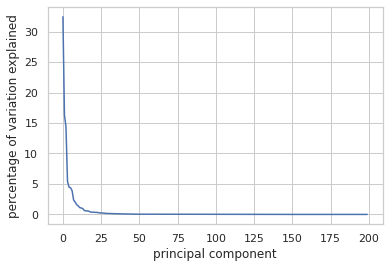

In [41]:
plt.plot(list(range(0,len(eigenval))), percents)
plt.xlabel('principal component')
plt.ylabel('percentage of variation explained')

plt.savefig('/content/figures/eigenval_weights.eps')

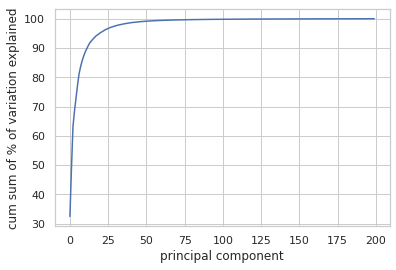

In [42]:
plt.plot(list(range(0,len(eigenval))), np.cumsum(percents))
plt.xlabel('principal component')
plt.ylabel('cum sum of % of variation explained')

plt.savefig('/content/figures/cumsum_eigenval.eps')

In [43]:
#get boundary coordinates for each region

stiff_bdpts = stiff_csv['Boundary coordinates'].to_numpy()
stiff_bdpts = fix_pandas_column(stiff_bdpts)

In [44]:
#get pca scores for each region

stiff_scores = stiff_csv['Score from PCA'].to_numpy()
stiff_scores = fix_pandas_column(stiff_scores)

##Stiff region

In [45]:
stiff_movies, stiff_tracks = dict_of_movies_tracks('stiff', stiff_csv, file_paths)

sort_moviedict(stiff_movies)

06032020-JR20-control
Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_tracks_shape.pkl...
/ [1 files][500.4 KiB/500.4 KiB]                                                
Operation completed over 1 objects/500.4 KiB.                                    
03122021-JR20P14-control-sample5
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_tracks_shape.pkl...
/ [1 files][460.3 KiB/460.3 KiB]                                                
Operation completed over 1 objects/460.3 KiB.                                    
03122021-JR20P14-control
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control_tracks_shape.pkl...
/ [1 files][756.9 KiB/756.9 KiB]                                                
Operation completed over 1 objects/756.9 KiB.                                    
031521_control_sample3
Copying gs://cellmbucket/analysis_sam_042821/031521_control_sample3_tracks_shape.pkl...
/ [1 files][231.2 KiB/231.2 KiB]                 

(array([29., 15., 17.,  9.,  8.,  9.,  9., 10.,  1.,  5.,  5.,  3.,  6.,
         1.,  4.,  3.,  3.,  1.,  5.,  1.,  0.,  1.,  1.,  0.,  0.,  9.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,
         3.]),
 array([ 10.   ,  14.275,  18.55 ,  22.825,  27.1  ,  31.375,  35.65 ,
         39.925,  44.2  ,  48.475,  52.75 ,  57.025,  61.3  ,  65.575,
         69.85 ,  74.125,  78.4  ,  82.675,  86.95 ,  91.225,  95.5  ,
         99.775, 104.05 , 108.325, 112.6  , 116.875, 121.15 , 125.425,
        129.7  , 133.975, 138.25 , 142.525, 146.8  , 151.075, 155.35 ,
        159.625, 163.9  , 168.175, 172.45 , 176.725, 181.   ]),
 <a list of 40 Patch objects>)

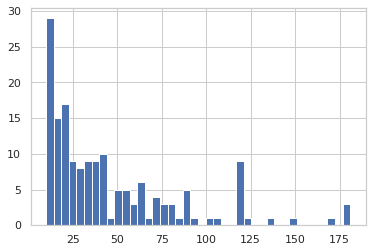

In [46]:
movie_lengths = []
for i in stiff_movies:
  movie_lengths.append(len(stiff_movies[i]))

plt.hist(movie_lengths,bins=40)

In [47]:
print(np.sort(movie_lengths))

[ 10  10  10  10  10  10  10  10  10  11  11  11  11  12  12  12  13  13
  13  13  13  14  14  14  14  14  14  14  14  15  15  15  15  16  16  16
  16  16  18  18  18  18  18  18  19  19  19  19  19  20  20  20  20  20
  21  21  21  21  22  22  22  23  23  24  24  25  25  25  27  27  28  29
  29  30  30  31  31  31  32  33  33  34  35  35  35  35  35  36  36  36
  36  36  37  37  38  38  40  40  41  42  42  43  43  43  44  44  47  49
  50  51  52  52  53  53  54  56  56  59  60  61  62  62  63  63  63  64
  68  70  70  70  71  75  77  78  79  81  81  83  87  87  88  90  90  94
 104 106 121 121 121 121 121 121 121 121 121 123 137 150 169 181 181 181]


In [49]:
print(np.shape(movie_lengths))

(162,)


In [50]:
min_length = 100

stiff_movies = get_movies_with_long_tracks(stiff_movies, min_length)

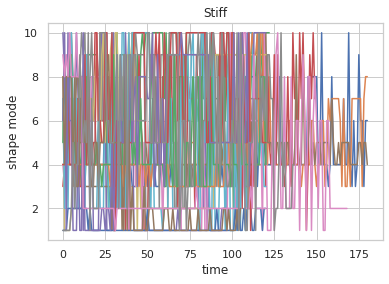

In [51]:
plot_of_shapemodes(stiff_movies)
plt.title('Stiff')

plt.savefig('/content/figures/stiff_sm_overtime.eps')

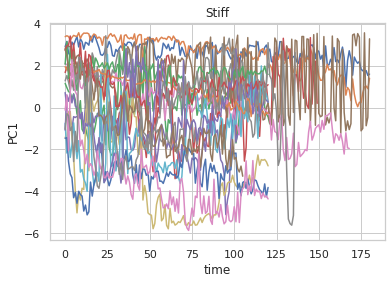

In [52]:
plot_of_PCovertime(stiff_movies, 1)
plt.title('Stiff')

plt.savefig('/content/figures/stiff_pc1_overtime.eps')

# Get motion metrics

In [53]:
treatment = treatment_locs[0].strip('\n')
!mkdir {treatment}

In [54]:
#Parameters to compute motion metrics
center='approximate-medoid'
pixel_size=2*0.645 #um. factor of 2 because image was rescaled
sampling_t=1 #sampling time (10min)

In [55]:
exclude_cols = pd.Series(['movie','frame','label','gel-region'])
#features to average
angles = ['polarity_angle','protr_angle','retr_angle','mean_protr_angle', 'mean_retr_angle']

In [56]:
cells_df = pd.DataFrame()
for file_base in file_paths:
  #get file
  file = file_base + '_tracks_shape.pkl'
  !gsutil cp gs://{file} ./{treatment}
  tracks,tracksgeo = read_tracks_aut([treatment+'/'+ ntpath.basename(file)] ,pixel_size,center)
  #!rm ./{treatment+'/'+ntpath.basename(file)}
  if len(tracks)==0: print("number of tracks read is 0")
  #tracks=smooth_tracks(tracks,1)

  #remove tracks with less than 11 points
  tracks = [track for track in tracks if len(track) > 10 ]
  tracksgeo = [track for track in tracksgeo if len(track) > 10 ]

  #GET TRACKS MOTION METRICS
  stepsizes,turns,meancoskturn,stderrcoskturn, tseries_stats, endpointcells = basic_stats(tracks,pixel_size,sampling_t)
  
  #GET HETEROMOTILITY FEATURES
  #prepare cell coordinates for heteromotility
  object_paths={}
  for i in range(len(tracks)):
    object_paths["cell"+str(i)]= tracks[i].tolist()
  pickle.dump( object_paths, open( "pickled_paths.pkl", "wb" ) )
  #run heteromotility
  !heteromotility --exttrack pickled_paths.pkl ./
  heteromotility_df = pd.read_csv("motility_statistics.csv")
  !rm motility_statistics.csv
  heteromotility_df = heteromotility_df.drop(columns = ["Well/XY", "cell_id"])

  #Each row of the data frame contains average data for a particular cell (track)
  cells = endpointcells

  #ADD TREATMENT 
  cells['treatment'] = treatment
  
  #Concatenate directional motion metrics with heteromotility metrics
  cells = pd.concat([cells.reset_index(drop=True), heteromotility_df.reset_index(drop=True)],1)

  #CONCATENATE MEAN GEOMETRY (for now pixel units)
  
  #make data frames with cell mean and std dev of not excluded shape metrics
  cellsshape = pd.DataFrame()
  cellsshape_std = pd.DataFrame()
  for i in range(len(tracksgeo)):
    #remove columns with duplicate names
    tracksgeo[i] = tracksgeo[i].loc[:,~tracksgeo[i].columns.duplicated()]
    #compute mean over cell
    colindices= ~tracksgeo[i].columns.isin(exclude_cols)
    means = tracksgeo[i].loc[:,colindices].mean().T
    #add gel-region
    means['gel-region'] =tracksgeo[i]['gel-region'].iloc[0]
    means['experiment'] =tracksgeo[i]['experiment'].iloc[0]
    means['track_id'] =tracksgeo[i]['track_id'].iloc[0]
    #add mean cosine and sine
    mean_cos_angles = np.cos(tracksgeo[i][angles]).mean()
    mean_cos_angles.index = ['cos_' + feature for feature in mean_cos_angles.index  ]
    mean_sin_angles = np.sin(tracksgeo[i][angles]).mean()
    mean_sin_angles.index = ['sin_' + feature for feature in mean_sin_angles.index  ]
    means = pd.concat([means,mean_sin_angles,mean_cos_angles],axis=0)
    cellsshape = cellsshape.append(means, ignore_index=True)
    
    #get variation in shape features (STD)
    cellsshape_std = cellsshape_std.append(tracksgeo[i].loc[:,colindices].std().T, ignore_index=True)
  #set column names of std dev data frame
  cellsshape_std.columns = [feature+'_std' for feature in cellsshape_std.columns  ]
  
  #concatenate track metrics and cell mean shape metrics    
  cells = pd.concat([cells.reset_index(drop=True), cellsshape.reset_index(drop=True), cellsshape_std.reset_index(drop=True)],1)
  
  #concatenate track metrics  std shape    
  #cells = pd.concat([cells.reset_index(drop=True),],1)
  
  #Append to all-cells data frame
  cells_df = cells_df.append(cells , ignore_index=True)  
  
  print('ncells',len(endpointcells['FMI']), endpointcells['FMI'].mean(),endpointcells['FMI'].sem())


Copying gs://cellmbucket/analysis_042221/06032020-JR20-control_tracks_shape.pkl...
/ [1 files][500.4 KiB/500.4 KiB]                                                
Operation completed over 1 objects/500.4 KiB.                                    


/content/libraries/track_functions.py:205: RuntimeWarning: invalid value encountered in true_divide
  meanpathlength=sum_pathlengths/nlengths
/content/libraries/track_functions.py:206: RuntimeWarning: invalid value encountered in true_divide
  stddevpathlength = np.sqrt(sum_squared_pathlengths/nlengths - meanpathlength**2 )
/content/libraries/track_functions.py:208: RuntimeWarning: invalid value encountered in true_divide
  meanfmi=sum_fmis/nlengths
/content/libraries/track_functions.py:209: RuntimeWarning: invalid value encountered in true_divide
  stddevfmi = np.sqrt(sum_squared_fmis/nlengths - meanfmi**2 )
/content/libraries/track_functions.py:211: RuntimeWarning: invalid value encountered in true_divide
  meanpmi=sum_pmis/nlengths
/content/libraries/track_functions.py:212: RuntimeWarning: invalid value encountered in true_divide
  stddevpmi = np.sqrt(sum_squared_pmis/nlengths - meanpmi**2 )
/content/libraries/track_functions.py:214: RuntimeWarning: invalid value encountered in true

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
Wrote  ./ motility_statistics.csv


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only


ncells 50 0.07845932362419085 0.058101729717115115
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control-sample5_tracks_shape.pkl...
/ [1 files][460.3 KiB/460.3 KiB]                                                
Operation completed over 1 objects/460.3 KiB.                                    
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
Wrote  ./ motility_statistics.csv
ncells 31 0.027580836640117876 0.06797525394493942
Copying gs://cellmbucket/analysis_pri_050521/03122021-JR20P14-control_tracks_shape.pkl...
/ [1 files][756.9 KiB/756.9 KiB]               

In [57]:
track_motion_dict = {}
for i in range(len(cells_df)):
  row = cells_df.loc[i]
  trackid = row['track_id']
  experiment = row['experiment']
  track_motion_dict[experiment + '_track' + trackid] = row

In [58]:
heteromotility_feat = ['total_distance', 'net_distance', 'min_speed', 'max_speed', 'avg_speed', 'time_moving', 'avg_moving_speed', 'linearity', 'spearmanrsq', 'progressivity', 'MSD_slope', 'rw_linearity', 'rw_netdist', 'rw_kurtosis', 'hurst_RS', 'autocorr', 'nongauss', 'p_rturn', 'min_theta', 'max_theta', 'mean_theta']

In [59]:
heteromotility_featlist = []
for i in track_motion_dict[list(track_motion_dict.keys())[0]].index:
  for j in heteromotility_feat:
    if j in i:
      heteromotility_featlist.append(i)

heteromotility_featlist = np.unique(np.array(heteromotility_featlist))

In [60]:
heteromotility_featlist

array(['MSD_slope', 'autocorr_1', 'autocorr_10', 'autocorr_2',
       'autocorr_3', 'autocorr_4', 'autocorr_5', 'autocorr_6',
       'autocorr_7', 'autocorr_8', 'autocorr_9', 'avg_moving_speed01',
       'avg_moving_speed02', 'avg_moving_speed03', 'avg_moving_speed04',
       'avg_moving_speed05', 'avg_moving_speed06', 'avg_moving_speed07',
       'avg_moving_speed08', 'avg_moving_speed09', 'avg_moving_speed10',
       'avg_speed', 'hurst_RS', 'linearity', 'max_speed',
       'max_theta_10_5', 'max_theta_10_6', 'max_theta_11_5',
       'max_theta_11_6', 'max_theta_6_3', 'max_theta_9_5',
       'max_theta_9_6', 'mean_theta_10_5', 'mean_theta_10_6',
       'mean_theta_11_5', 'mean_theta_11_6', 'mean_theta_6_3',
       'mean_theta_9_5', 'mean_theta_9_6', 'min_speed', 'min_theta_10_5',
       'min_theta_10_6', 'min_theta_11_5', 'min_theta_11_6',
       'min_theta_6_3', 'min_theta_9_5', 'min_theta_9_6', 'net_distance',
       'nongauss', 'p_rturn_10_5', 'p_rturn_10_6', 'p_rturn_11_5',
     

In [61]:
all_motion_feat = list(track_motion_dict[list(track_motion_dict.keys())[0]].index)
all_motion_feat.remove('treatment')

In [62]:
for i in track_motion_dict[list(track_motion_dict.keys())[0]].index:
  print(i)

length
T
speed
D
DoverT
FMI
PMI
angle
treatment
total_distance
net_distance
linearity
spearmanrsq
progressivity
max_speed
min_speed
avg_speed
MSD_slope
hurst_RS
nongauss
disp_var
disp_skew
rw_linearity
rw_netdist
rw_kurtosis01
rw_kurtosis02
rw_kurtosis03
rw_kurtosis04
rw_kurtosis05
rw_kurtosis06
rw_kurtosis07
rw_kurtosis08
rw_kurtosis09
rw_kurtosis10
avg_moving_speed01
avg_moving_speed02
avg_moving_speed03
avg_moving_speed04
avg_moving_speed05
avg_moving_speed06
avg_moving_speed07
avg_moving_speed08
avg_moving_speed09
avg_moving_speed10
time_moving01
time_moving02
time_moving03
time_moving04
time_moving05
time_moving06
time_moving07
time_moving08
time_moving09
time_moving10
autocorr_1
autocorr_2
autocorr_3
autocorr_4
autocorr_5
autocorr_6
autocorr_7
autocorr_8
autocorr_9
autocorr_10
p_rturn_6_3
mean_theta_6_3
min_theta_6_3
max_theta_6_3
area
approximate-medoidx
approximate-medoidy
track_id
convex_area
eccentricity
orientation
perimeter
equivalent_diameter
solidity
extent
major_axis_len

In [63]:
for i in stiff_tracks[list(track_motion_dict.keys())[0]].columns:
  print(i)

movie
frame
label
area
approximate-medoidx
approximate-medoidy
gel-region
experiment
track_id
area
convex_area
eccentricity
orientation
perimeter
equivalent_diameter
solidity
extent
major_axis_length
minor_axis_length
centroid-0
centroid-1
median_centroidx
median_centroidy
polarity_angle
abs-skew
protr_angle
mean_protr_angle
protr_norm_area
retr_angle
mean_retr_angle
retr_norm_area
protr_norm_radii
mean_protr_norm_radii
retr_norm_radii
mean_retr_norm_radii


##Long tracks PC1 vs PC2

# PC plots by region

##PC2 vs PC1

In [64]:
!mkdir figures/pc2vspc1

In [65]:
stiff_pc1, stiff_pc2, stiff_absskew_val, stiff_avgpc1, stiff_avgpc2, stiff_avgabsskew_val = get_absskew_pc(stiff_movies, stiff_tracks, 1, 2)

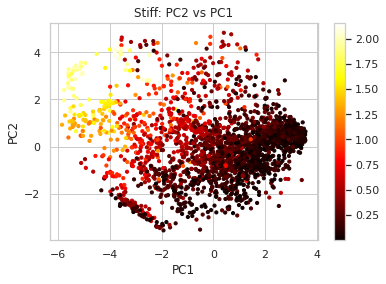

In [66]:
plt.scatter(stiff_pc1,stiff_pc2, c=stiff_absskew_val, cmap='hot', s=10)
plt.colorbar()

plt.title('Stiff: PC2 vs PC1')
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.savefig('/content/figures/pc2vspc1/stiffregion_absskew.eps')

####Averages over time

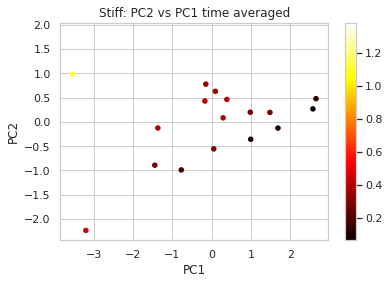

In [68]:
plt.scatter(stiff_avgpc1,stiff_avgpc2, c=stiff_avgabsskew_val, cmap='hot', s=20)

plt.colorbar()

plt.title("Stiff: PC2 vs PC1 time averaged")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.savefig('/content/figures/pc2vspc1/stiffregion_avg_absskew.eps')

##PC3 vs PC2

In [69]:
!mkdir figures/pc3vspc2

In [70]:
stiff_pc2, stiff_pc3, stiff_absskew_val, stiff_avgpc2, stiff_avgpc3, stiff_avgabsskew_val = get_absskew_pc(stiff_movies, stiff_tracks, 2, 3)

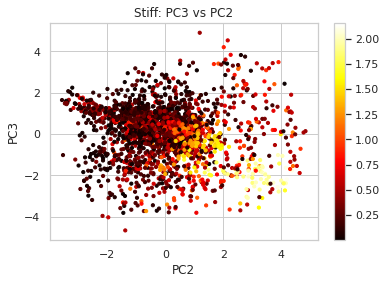

In [71]:
plt.scatter(stiff_pc2,stiff_pc3, c=stiff_absskew_val, cmap='hot', s=10)

plt.colorbar()

plt.title("Stiff: PC3 vs PC2")
plt.xlabel("PC2")
plt.ylabel("PC3")

plt.savefig('/content/figures/pc3vspc2/stiffregion_absskew.eps')

####Averages over time

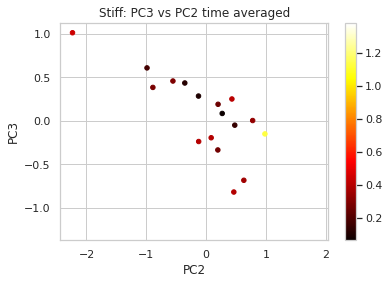

In [72]:
plt.scatter(stiff_avgpc2,stiff_avgpc3, c=stiff_avgabsskew_val, cmap='hot', s=20)

plt.colorbar()

plt.title("Stiff: PC3 vs PC2 time averaged")
plt.xlabel("PC2")
plt.ylabel("PC3")

plt.savefig('/content/figures/pc3vspc2/stiffregion_avg_absskew.eps')

##PC4 vs PC3

In [73]:
!mkdir figures/pc4vspc3

In [74]:
stiff_pc3, stiff_pc4, stiff_absskew_val, stiff_avgpc3, stiff_avgpc4, stiff_avgabsskew_val = get_absskew_pc(stiff_movies, stiff_tracks, 3, 4)

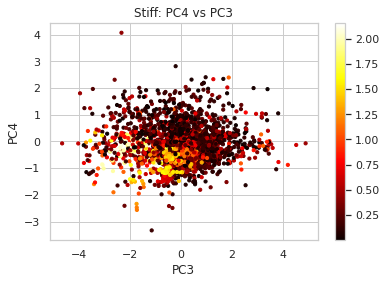

In [75]:
plt.scatter(stiff_pc3,stiff_pc4, c=stiff_absskew_val, cmap='hot', s=10)

plt.colorbar()

plt.title("Stiff: PC4 vs PC3")
plt.xlabel("PC3")
plt.ylabel("PC4")

plt.savefig('/content/figures/pc4vspc3/stiffregion_absskew.eps')

####Averages over time

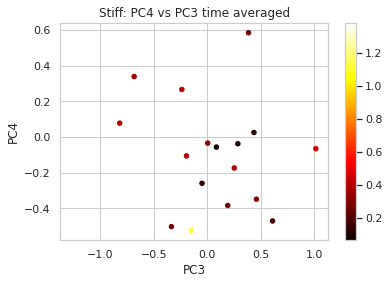

In [76]:
plt.scatter(stiff_avgpc3,stiff_avgpc4, c=stiff_avgabsskew_val, cmap='hot', s=20)

plt.colorbar()

plt.title("Stiff: PC4 vs PC3 time averaged")
plt.xlabel("PC3")
plt.ylabel("PC4")

plt.savefig('/content/figures/pc4vspc3/stiffregion_avg_absskew.eps')

# Boxplots with PC

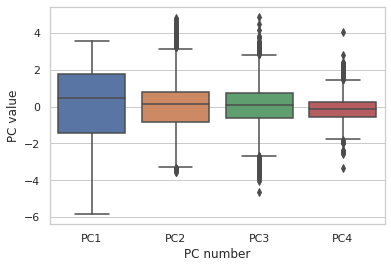

In [77]:
data_bp_PC = {'PC1':stiff_pc1, 'PC2':stiff_pc2, 'PC3':stiff_pc3, 'PC4':stiff_pc4}
pc_boxplot = pd.DataFrame({ key:pd.Series(value) for key, value in data_bp_PC.items() })
sns.boxplot(data=pc_boxplot)
plt.xlabel("PC number")
plt.ylabel("PC value")

plt.savefig('/content/figures/boxplot_bypc.eps')

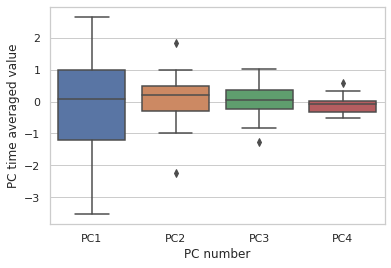

In [78]:
data_bp_PC = {'PC1':stiff_avgpc1, 'PC2':stiff_avgpc2, 'PC3':stiff_avgpc3, 'PC4':stiff_avgpc4}
pc_boxplot = pd.DataFrame({ key:pd.Series(value) for key, value in data_bp_PC.items() })
sns.boxplot(data=pc_boxplot)
plt.xlabel("PC number")
plt.ylabel("PC time averaged value")

plt.savefig('/content/figures/boxplot_byavgpc.eps')

# Histograms of PCs

In [79]:
!mkdir figures/histograms

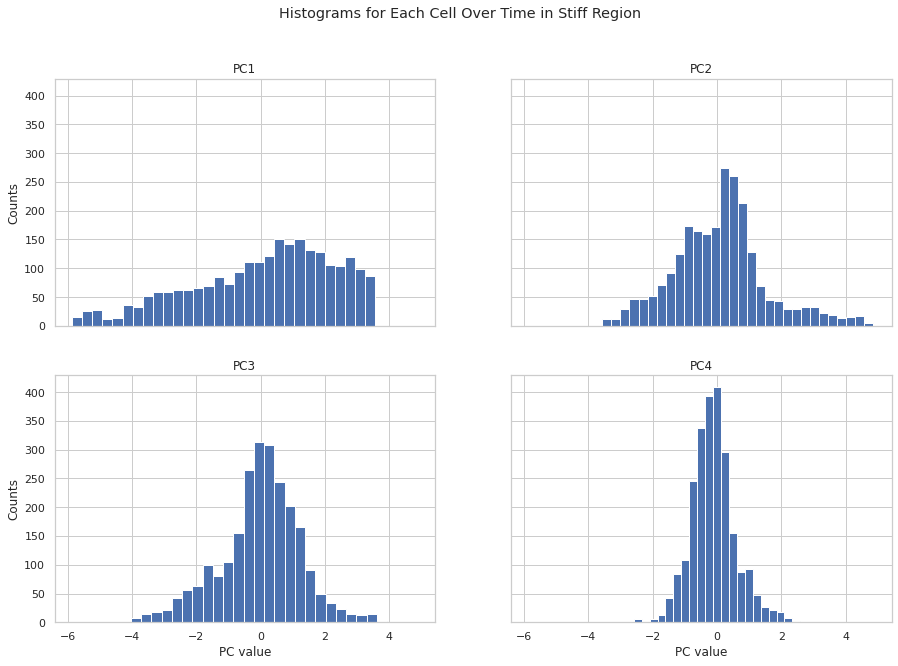

In [80]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,10))

fig.suptitle('Histograms for Each Cell Over Time in Stiff Region')

axs[0,0].hist(stiff_pc1, density=False, bins=30)
axs[0,0].set_title('PC1')
axs[0,1].hist(stiff_pc2, density=False, bins=30)
axs[0,1].set_title('PC2')
axs[1,0].hist(stiff_pc3, density=False, bins=30)
axs[1,0].set_title('PC3')
axs[1,1].hist(stiff_pc4, density=False, bins=30)
axs[1,1].set_title('PC4')



for ax in axs.flat:
    ax.set(xlabel='PC value', ylabel='Counts')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('/content/figures/histograms/pc.eps')

####Averages over time

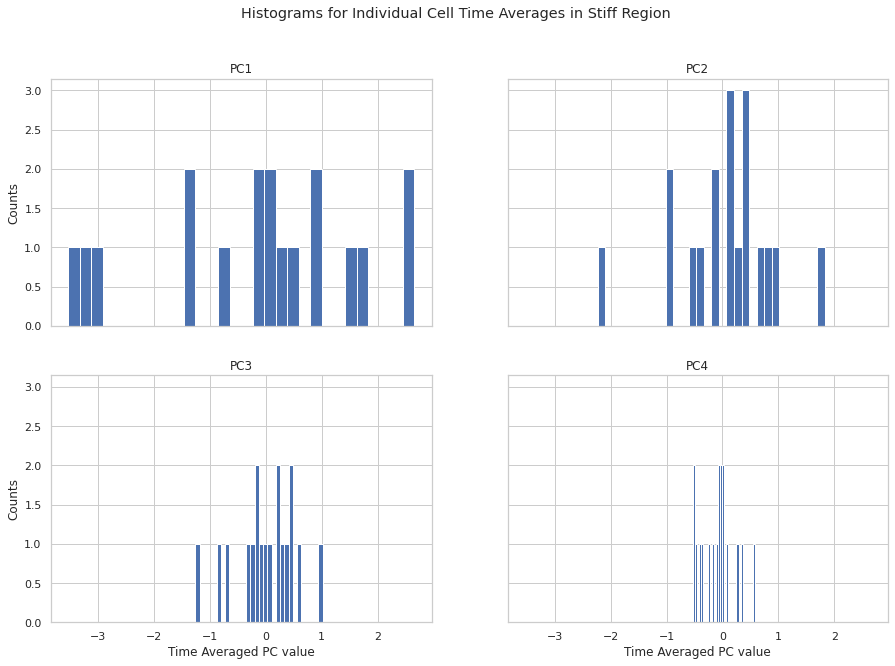

In [81]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,10))

fig.suptitle('Histograms for Individual Cell Time Averages in Stiff Region')

axs[0,0].hist(stiff_avgpc1, density=False, bins=30)
axs[0,0].set_title('PC1')
axs[0,1].hist(stiff_avgpc2, density=False, bins=30)
axs[0,1].set_title('PC2')
axs[1,0].hist(stiff_avgpc3, density=False, bins=30)
axs[1,0].set_title('PC3')
axs[1,1].hist(stiff_avgpc4, density=False, bins=30)
axs[1,1].set_title('PC4')



for ax in axs.flat:
    ax.set(xlabel='Time Averaged PC value', ylabel='Counts')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

plt.savefig('/content/figures/histograms/avgpc.eps')

# Correlation coefficient calculations

## Shape Metric and PC Correlations

In [82]:
#remove duplicated column names (in this case, area appeared twice in each dataframe)

for i in stiff_tracks:
  stiff_tracks[i] = (stiff_tracks[i]).loc[:,~(stiff_tracks[i]).columns.duplicated()]

In [83]:
shape_metrics = ['abs-skew', 'solidity', 'area', 'convex_area', 'eccentricity', 'perimeter', 'equivalent_diameter', 'extent', 'major_axis_length', 'minor_axis_length', 'polarity_angle']

In [84]:
col = []
for i in range(0,pcnum):
  col.append('PC{}'.format(i+1))

In [85]:
pc_shape_rval_dict = {}
pc_shape_pval_dict = {}

for i in shape_metrics:
  per_pc_rval = []
  per_pc_pval = []
  for j in range(0,pcnum):
    pear_r,pval = pearson_corr(stiff_movies,stiff_tracks,j+1,i)
    per_pc_rval.append(pear_r)
    per_pc_pval.append(pval)
  pc_shape_rval_dict[i] = per_pc_rval
  pc_shape_pval_dict[i] = per_pc_pval

In [86]:
pearsoncorr_rval_pc_shape_df = pd.DataFrame.from_dict(pc_shape_rval_dict, orient='index', columns=col)
pearsoncorr_pval_pc_shape_df = pd.DataFrame.from_dict(pc_shape_pval_dict, orient='index', columns=col)

In [87]:
pearsoncorr_rval_pc_shape_df

PC1       PC2       PC3       PC4       PC5  \
abs-skew            -0.730978  0.446639 -0.299465 -0.222410  0.035023   
solidity             0.707808 -0.188984  0.154914 -0.133414  0.043512   
area                 0.386580  0.022393  0.037952 -0.020118  0.018494   
convex_area          0.055734  0.234121 -0.125401  0.042608 -0.012445   
eccentricity        -0.605849 -0.493977  0.222316  0.116470 -0.046276   
perimeter           -0.222484  0.120609 -0.077116  0.128873 -0.042147   
equivalent_diameter  0.389653  0.028664  0.031410  0.016647  0.013664   
extent               0.780739 -0.017268  0.058562 -0.089382  0.071166   
major_axis_length   -0.479608 -0.310222  0.162583  0.143970 -0.077136   
minor_axis_length    0.328024  0.494220 -0.250669 -0.040732  0.015780   
polarity_angle       0.097773 -0.056461  0.035207  0.087111  0.031368   

                          PC6       PC7       PC8       PC9      PC10  
abs-skew             0.099436  0.044724 -0.113577  0.038625 -0.047596  
solidity             0.159268 -0.001444  0.155647 -0.048540 -0.210274  
area                -0.040070 -0.025610 -0.065451  0.049527 -0.065100  
convex_area         -0.144313 -0.024603 -0.217706  0.065733  0.074170  
eccentricity        -0.056641 -0.009766 -0.005556  0.035312 -0.005927  
perimeter           -0.201033 -0.009863 -0.181052  0.066853  0.139911  
equivalent_diameter -0.054533 -0.019549 -0.063304  0.059664 -0.042819  
extent               0.171023 -0.020492  0.080981 -0.051563 -0.142287  
major_axis_length   -0.205155 -0.018492 -0.084880  0.076196  0.004657  
minor_axis_length   -0.073497  0.007645 -0.192963  0.031975  0.078093  
polarity_angle      -0.060697  0.049491  0.045913 -0.095254 -0.028528

## PC and Motion Metric Correlations

In [88]:
motion_metrics = ['speed', 'DoverT']

In [89]:
col = []
for i in range(0,pcnum):
  col.append('PC{}'.format(i+1))

In [90]:
pc_motion_rval_dict = {}
pc_motion_pval_dict = {}

for i in motion_metrics:
  per_pc_rval = []
  per_pc_pval = []
  for j in range(0,pcnum):
    pear_r,pval = pearson_corr_motion_metrics(stiff_movies,j+1,i)
    per_pc_rval.append(pear_r)
    per_pc_pval.append(pval)
  pc_motion_rval_dict[i] = per_pc_rval
  pc_motion_pval_dict[i] = per_pc_pval

In [91]:
pearsoncorr_rval_pc_motion_df = pd.DataFrame.from_dict(pc_motion_rval_dict, orient='index', columns=col)
pearsoncorr_pval_pc_motion_df = pd.DataFrame.from_dict(pc_motion_pval_dict, orient='index', columns=col)

In [92]:
pearsoncorr_rval_pc_motion_df

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
speed  -0.230421 -0.042368 -0.107936  0.559229  0.209273 -0.296873 -0.133969   
DoverT -0.105005 -0.139507  0.157236  0.259740  0.145773 -0.441136 -0.541846   

             PC8       PC9      PC10  
speed  -0.411979 -0.160418  0.589452  
DoverT -0.420070  0.010087  0.431888

## PC and Heteromotility Metric Correlations

In [93]:
pc_motion_rval_dict = {}
pc_motion_pval_dict = {}

for i in heteromotility_featlist:
  per_pc_rval = []
  per_pc_pval = []
  for j in range(0,pcnum):
    pear_r,pval = pearson_corr_motion_metrics(stiff_movies,j+1,i)
    per_pc_rval.append(pear_r)
    per_pc_pval.append(pval)
  pc_motion_rval_dict[i] = per_pc_rval
  pc_motion_pval_dict[i] = per_pc_pval

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [94]:
pearsoncorr_rval_pc_heteromotility_df = pd.DataFrame.from_dict(pc_motion_rval_dict, orient='index', columns=col)
pearsoncorr_pval_pc_heteromotility_df = pd.DataFrame.from_dict(pc_motion_pval_dict, orient='index', columns=col)

In [95]:
pearsoncorr_rval_pc_heteromotility_df

PC1       PC2       PC3       PC4       PC5       PC6  \
MSD_slope      -0.457404 -0.178468  0.026294  0.401238  0.012564 -0.524343   
autocorr_1      0.242082  0.521215  -0.51889  -0.23188  0.251972  0.433484   
autocorr_10     0.126981   0.45556 -0.487666  0.231914  0.268415  0.244585   
autocorr_2      0.087209  0.441242  -0.51417 -0.045417  0.138449  0.138907   
autocorr_3      0.073161    0.2825 -0.246222  0.110935  -0.04955 -0.150567   
...                  ...       ...       ...       ...       ...       ...   
time_moving07  -0.100384 -0.145166 -0.081787  0.553046   0.21442 -0.138956   
time_moving08        NaN       NaN       NaN       NaN       NaN       NaN   
time_moving09        NaN       NaN       NaN       NaN       NaN       NaN   
time_moving10        NaN       NaN       NaN       NaN       NaN       NaN   
total_distance -0.042219  0.025103 -0.174383  0.407463  0.233813 -0.169762   

                     PC7       PC8       PC9      PC10  
MSD_slope      -0.142628 -0.448252  0.052118   0.55054  
autocorr_1      0.256016 -0.108731 -0.134173 -0.228208  
autocorr_10     0.029686 -0.157518 -0.287769  -0.15782  
autocorr_2      0.208743 -0.119175 -0.314089 -0.093747  
autocorr_3      0.008277 -0.139321 -0.506346  0.053309  
...                  ...       ...       ...       ...  
time_moving07  -0.110922  -0.08696 -0.089612  0.203297  
time_moving08        NaN       NaN       NaN       NaN  
time_moving09        NaN       NaN       NaN       NaN  
time_moving10        NaN       NaN       NaN       NaN  
total_distance  -0.04068 -0.431458 -0.208311  0.472513  

[81 rows x 10 columns]

##Shape and Motion Metric Correlations

In [96]:
shape_motion_rval_dict = {}
shape_motion_pval_dict = {}

for i in motion_metrics:
  per_pc_rval = []
  per_pc_pval = []
  for j in shape_metrics:
    pear_r,pval = pearson_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,j,i)
    per_pc_rval.append(pear_r)
    per_pc_pval.append(pval)
  shape_motion_rval_dict[i] = per_pc_rval
  shape_motion_pval_dict[i] = per_pc_pval

In [97]:
pearsoncorr_rval_shape_motion_df = pd.DataFrame.from_dict(shape_motion_rval_dict, orient='index', columns=shape_metrics)
pearsoncorr_pval_shape_motion_df = pd.DataFrame.from_dict(shape_motion_pval_dict, orient='index', columns=shape_metrics)

In [98]:
pearsoncorr_rval_shape_motion_df

abs-skew  solidity      area  convex_area  eccentricity  perimeter  \
speed   0.078465 -0.421963 -0.382171    -0.141929      0.225237   0.174474   
DoverT -0.118428 -0.206189  0.162965     0.294626      0.215014   0.407531   

        equivalent_diameter    extent  major_axis_length  minor_axis_length  \
speed             -0.313879 -0.257725           0.038112          -0.200627   
DoverT             0.136389 -0.202413           0.397758           0.042219   

        polarity_angle  
speed         0.076353  
DoverT       -0.046920

## Shape and Heteromotility Metric Correlations

In [99]:
shape_metrics

['abs-skew',
 'solidity',
 'area',
 'convex_area',
 'eccentricity',
 'perimeter',
 'equivalent_diameter',
 'extent',
 'major_axis_length',
 'minor_axis_length',
 'polarity_angle']

In [100]:
for i in track_motion_dict:
  print(i)
  print(track_motion_dict[i]['max_theta_6_3'])

06032020-JR20-control_track0
2.06508568317288
06032020-JR20-control_track1
nan
06032020-JR20-control_track2
0.2713671292780401
06032020-JR20-control_track4
1.5641069430655608
06032020-JR20-control_track5
0.6669470718012371
06032020-JR20-control_track6
1.9039936420493464
06032020-JR20-control_track7
1.0874705752759934
06032020-JR20-control_track8
0.5728179266990937
06032020-JR20-control_track9
0.6453237070181534
06032020-JR20-control_track10
2.0414356478469906
06032020-JR20-control_track11
0.7889096589137062
06032020-JR20-control_track12
nan
06032020-JR20-control_track13
2.0812665661830123
06032020-JR20-control_track14
nan
06032020-JR20-control_track15
0.4290294100450452
06032020-JR20-control_track16
nan
06032020-JR20-control_track17
2.8175082472113995
06032020-JR20-control_track18
2.680607187380441
06032020-JR20-control_track19
2.3864882501111198
06032020-JR20-control_track20
2.341591658237776
06032020-JR20-control_track21
0.907734997212942
06032020-JR20-control_track22
0.2543593142547

In [101]:
shape_motion_rval_dict = {}
shape_motion_pval_dict = {}

for i in heteromotility_featlist:
  per_pc_rval = []
  per_pc_pval = []
  for j in shape_metrics:
    pear_r,pval = pearson_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,j,i)
    per_pc_rval.append(pear_r)
    per_pc_pval.append(pval)
  shape_motion_rval_dict[i] = per_pc_rval
  shape_motion_pval_dict[i] = per_pc_pval

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [102]:
pearsoncorr_rval_shape_heteromotility_df = pd.DataFrame.from_dict(shape_motion_rval_dict, orient='index', columns=shape_metrics)
pearsoncorr_pval_shape_heteromotility_df = pd.DataFrame.from_dict(shape_motion_pval_dict, orient='index', columns=shape_metrics)

In [103]:
pearsoncorr_rval_shape_heteromotility_df

abs-skew  solidity      area convex_area eccentricity  \
MSD_slope       0.220251 -0.572985 -0.148116    0.134659     0.515886   
autocorr_1      0.245481     0.104  -0.09361   -0.052261    -0.591478   
autocorr_10     0.215047 -0.033698  0.055246    0.210269    -0.468524   
autocorr_2      0.297289  -0.09002 -0.167385   -0.015302    -0.474097   
autocorr_3      0.132942  -0.03317 -0.057604    0.042365    -0.266646   
...                  ...       ...       ...         ...          ...   
time_moving07  -0.059946 -0.083892 -0.112683   -0.136106     0.210909   
time_moving08        NaN       NaN       NaN         NaN          NaN   
time_moving09        NaN       NaN       NaN         NaN          NaN   
time_moving10        NaN       NaN       NaN         NaN          NaN   
total_distance  0.015608 -0.270556 -0.303591   -0.107802     0.002249   

               perimeter equivalent_diameter    extent major_axis_length  \
MSD_slope       0.428776           -0.165308 -0.555019          0.570648   
autocorr_1     -0.258974           -0.084675  0.281843         -0.551519   
autocorr_10     0.142755            0.127205    0.0725          -0.17555   
autocorr_2     -0.068286           -0.123186  0.057314         -0.355569   
autocorr_3      0.001069           -0.009165  0.112008         -0.247954   
...                  ...                 ...       ...               ...   
time_moving07   0.008627           -0.077241 -0.007479          0.057301   
time_moving08        NaN                 NaN       NaN               NaN   
time_moving09        NaN                 NaN       NaN               NaN   
time_moving10        NaN                 NaN       NaN               NaN   
total_distance  0.114616           -0.242381 -0.108623          -0.10067   

               minor_axis_length polarity_angle  
MSD_slope              -0.137847      -0.190468  
autocorr_1              0.290198      -0.103343  
autocorr_10              0.45391       0.057675  
autocorr_2              0.283118      -0.220218  
autocorr_3               0.22551       0.262871  
...                          ...            ...  
time_moving07          -0.183765       0.219385  
time_moving08                NaN            NaN  
time_moving09                NaN            NaN  
time_moving10                NaN            NaN  
total_distance         -0.089766       0.086853  

[81 rows x 11 columns]

In [104]:
nanlist = []
shape_feature = 'abs-skew'
motion_feature = 'max_theta_6_3'
shape_feature_val_avg = []
motion_feature_val = []
for i in stiff_movies:
  if i in track_motion_dict.keys():
    shape_feature_temp = []
    nanlist.append(track_motion_dict[i][motion_feature])
    for j in range(1,len(stiff_movies[i])+1):
      if np.isnan(stiff_tracks[i][shape_feature].loc[j-1]) != True and np.isnan(track_motion_dict[i][motion_feature]) != True:
        shape_feature_temp.append(stiff_tracks[i][shape_feature].loc[j-1])

    if len(shape_feature_temp) > 0:
      shape_feature_val_avg.append(np.average(shape_feature_temp))

      motion_feature_val.append(track_motion_dict[i][motion_feature])

print(shape_feature_val_avg)
print(motion_feature_val)
print(len(nanlist))

[]
[]
18


In [105]:
#nanlist = []
shape_feature = 'abs-skew'
motion_feature = 'time_moving10'
shape_feature_val_avg = []
motion_feature_val = []
for i in stiff_movies:
  if i in track_motion_dict.keys():
    shape_feature_temp = []
    print(track_motion_dict[i][motion_feature])
    for j in range(1,len(stiff_movies[i])+1):
      if np.isnan(stiff_tracks[i][shape_feature].loc[j-1]) != True and np.isnan(track_motion_dict[i][motion_feature]) != True:
        shape_feature_temp.append(stiff_tracks[i][shape_feature].loc[j-1])

    if len(shape_feature_temp) > 0:
      shape_feature_val_avg.append(np.average(shape_feature_temp))

      motion_feature_val.append(track_motion_dict[i][motion_feature])

print(shape_feature_val_avg)
print(motion_feature_val)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
[0.1478197004299615, 0.0641418595262113, 0.36230759637686283, 0.39672559090978693, 0.2840796113394083, 0.26717500207541733, 0.29492783325973365, 0.3941350436460615, 1.382187790210491, 0.40089728509000794, 0.4471721129647187, 0.25513040648150903, 0.10219903047918374, 0.1199261382468712, 0.4092792428309197, 0.17822427162773405, 1.1342385920835032, 0.33632042478540664]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Correlation Plots

## Shape and PC 

In [106]:
def volcano_plot_1region(df_rval, df_pval, title):
  df_rval = df_rval.T
  df_pval = df_pval.T
  for columnName, columnData in (df_rval).iteritems():
    plt.scatter(df_rval[columnName], -np.log10(df_pval[columnName]), label=columnName)
    plt.axhline(y=-np.log10(.05), color='r', linestyle='--')
    plt.xlabel('r value')
    plt.ylabel('$\log_{10}(p-value)$')
    plt.title(title)
    plt.legend()

In [107]:
def volcano_plot_1region_1metric(df_rval, df_pval, motion_metric, title):
  df_rval = df_rval.T
  df_pval = df_pval.T
  plt.scatter(df_rval[motion_metric], -np.log10(df_pval[motion_metric]))
  plt.axhline(y=-np.log10(.05), color='r', linestyle='--')
  plt.xlabel('r value')
  plt.ylabel('$\log_{10}(p-value)$')
  plt.title(title)
  for idx, row in df_rval.iterrows():
    plt.text(row[motion_metric], - np.log10(df_pval[motion_metric][idx]), idx)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


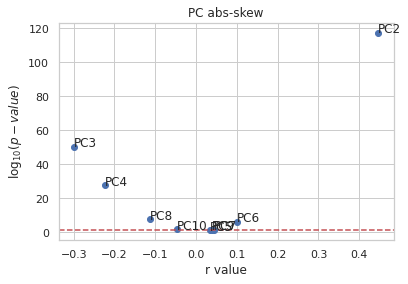

posx and posy should be finite values
posx and posy should be finite values


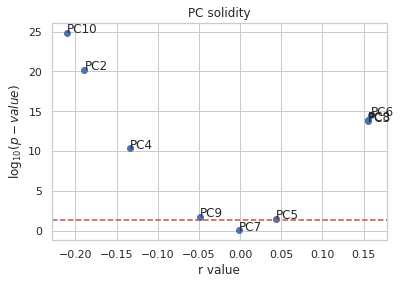

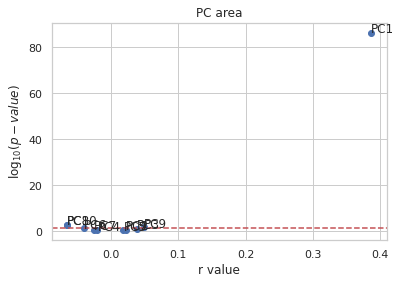

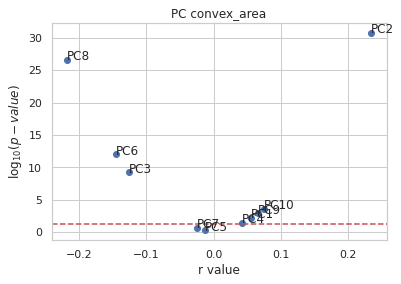

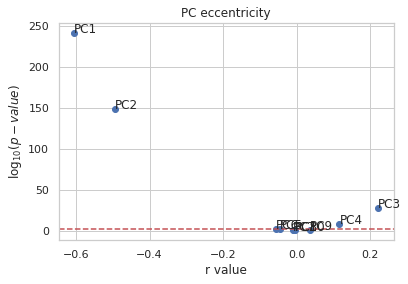

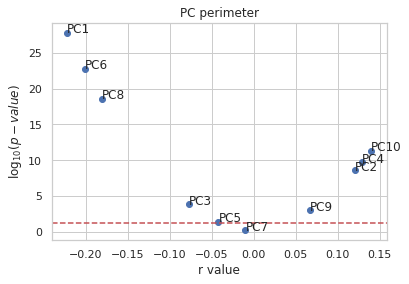

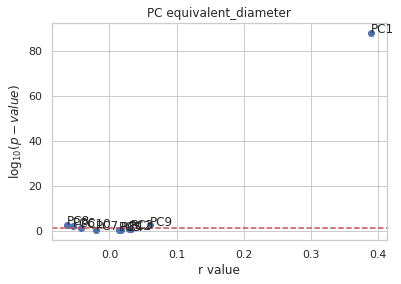

posx and posy should be finite values
posx and posy should be finite values


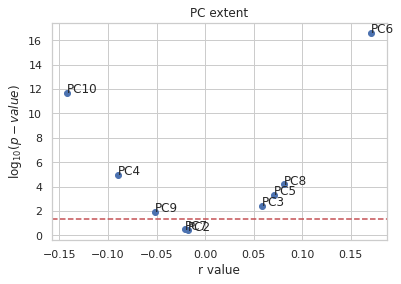

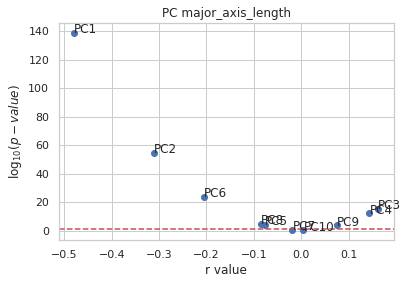

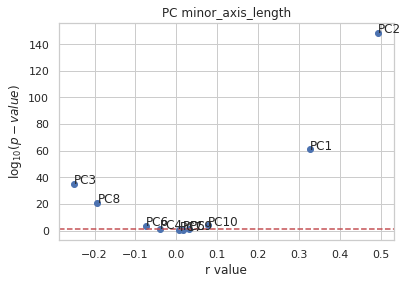

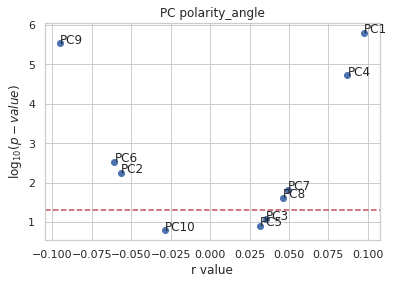

In [108]:
for count,metric in enumerate(shape_metrics):
  plt.figure(count)
  volcano_plot_1region_1metric(pearsoncorr_rval_pc_shape_df, pearsoncorr_pval_pc_shape_df, metric, 'PC {}'.format(metric))
  #plt.savefig('/content/figures/corr_plots/volcano_plot/PC_motionmetric/Stiff_PC_{}.eps'.format(metric))

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


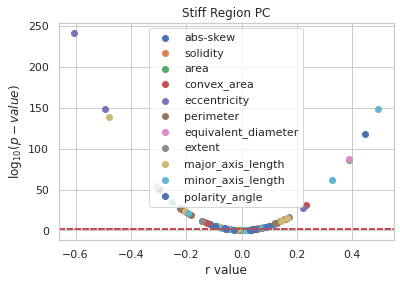

In [109]:
volcano_plot_1region(pearsoncorr_rval_pc_shape_df, pearsoncorr_pval_pc_shape_df, 'Stiff Region PC')
#plt.savefig('/content/figures/corr_plots/volcano_plot/PC_motionmetric/Stiff_PC_Motion.eps')

## PC and Motion Metrics

In [110]:
!mkdir figures/corr_plots

In [111]:
!mkdir figures/corr_plots/volcano_plot

In [112]:
!mkdir figures/corr_plots/volcano_plot/PC_motionmetric

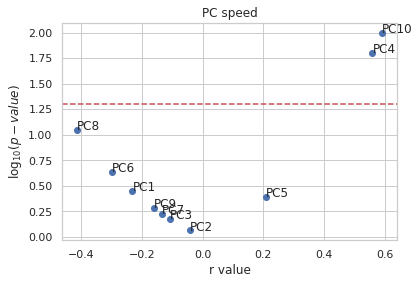

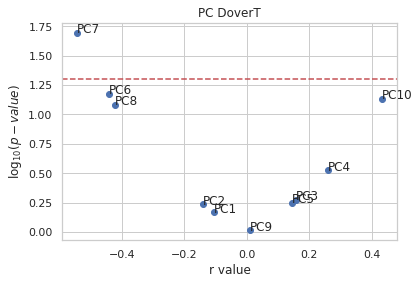

In [113]:
for count,metric in enumerate(motion_metrics):
  plt.figure(count)
  volcano_plot_1region_1metric(pearsoncorr_rval_pc_motion_df, pearsoncorr_pval_pc_motion_df, metric, 'PC {}'.format(metric))
  plt.savefig('/content/figures/corr_plots/volcano_plot/PC_motionmetric/Stiff_PC_{}.eps'.format(metric))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


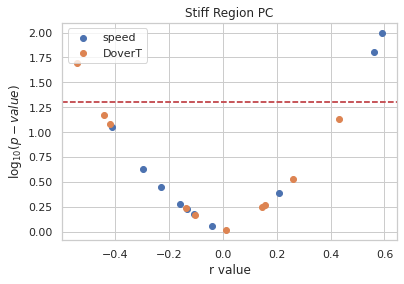

In [114]:
volcano_plot_1region(pearsoncorr_rval_pc_motion_df, pearsoncorr_pval_pc_motion_df, 'Stiff Region PC')
plt.savefig('/content/figures/corr_plots/volcano_plot/PC_motionmetric/Stiff_PC_Motion.eps')

## PC and Heteromotility Metrics

In [115]:
!mkdir figures/corr_plots/volcano_plot/PC_heteromotility

In [116]:
def volcano_plot_1region_1metric(df_rval, df_pval, motion_metric, title):
  df_rval = df_rval.T
  df_pval = df_pval.T
  plt.scatter(df_rval[motion_metric], -np.log10(df_pval[motion_metric]))
  plt.axhline(y=-np.log10(.05), color='r', linestyle='--')
  plt.xlabel('r value')
  plt.ylabel('$\log_{10}(p-value)$')
  plt.title(title)
  for idx, row in df_rval.iterrows():
    plt.text(row[motion_metric], - np.log10(df_pval[motion_metric][idx]), idx)

In [117]:
for count,metric in enumerate(heteromotility_featlist):
  plt.figure(count)
  print(metric)
  volcano_plot_1region_1metric(pearsoncorr_rval_pc_heteromotility_df, pearsoncorr_pval_pc_heteromotility_df, metric, 'PC {}'.format(metric))
  plt.savefig('/content/figures/corr_plots/volcano_plot/PC_heteromotility/Stiff_PC_{}.eps'.format(metric))

MSD_slope


TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [118]:
volcano_plot_1region(pearsoncorr_rval_pc_heteromotility_df, pearsoncorr_pval_pc_heteromotility_df, 'Stiff Region PC')
plt.savefig('/content/figures/corr_plots/volcano_plot/PC_heteromotility/Stiff_PC_Heteromotility.eps')

TypeError: ignored

## Shape Metrics and Motion Metrics

In [119]:
!mkdir figures/corr_plots/volcano_plot/Shape_motionmetric

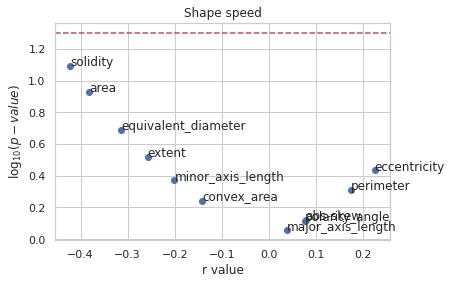

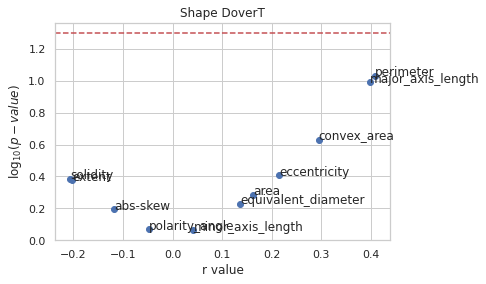

In [120]:
for count,metric in enumerate(motion_metrics):
  plt.figure(count)
  volcano_plot_1region_1metric(pearsoncorr_rval_shape_motion_df, pearsoncorr_pval_shape_motion_df, metric, 'Shape {}'.format(metric))
  plt.savefig('/content/figures/corr_plots/volcano_plot/Shape_motionmetric/Stiff_Shape_{}.eps'.format(metric))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


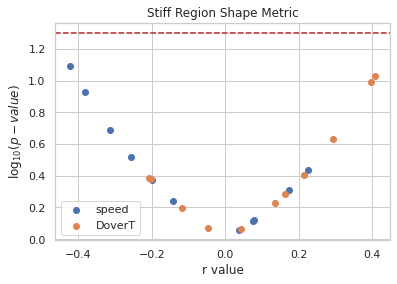

In [121]:
volcano_plot_1region(pearsoncorr_rval_shape_motion_df, pearsoncorr_pval_shape_motion_df, 'Stiff Region Shape Metric')
plt.savefig('/content/figures/corr_plots/volcano_plot/Shape_motionmetric/Stiff_Shape_Motion.eps')

##Shape Metrics and Heteromotility Metrics

In [122]:
!mkdir figures/corr_plots/volcano_plot/Shape_heteromotility

In [123]:
for count,metric in enumerate(heteromotility_featlist):
  plt.figure(count)
  volcano_plot_1region_1metric(pearsoncorr_rval_shape_heteromotility_df, pearsoncorr_pval_shape_heteromotility_df, metric, 'Shape {}'.format(metric))
  plt.savefig('/content/figures/corr_plots/volcano_plot/Shape_heteromotility/Stiff_Shape_{}.eps'.format(metric))

TypeError: ignored

<Figure size 432x288 with 0 Axes>

In [124]:
volcano_plot_1region(pearsoncorr_rval_shape_heteromotility_df, pearsoncorr_pval_shape_heteromotility_df, 'Stiff Region Shape Metric')
plt.savefig('/content/figures/corr_plots/volcano_plot/Shape_heteromotility/Stiff_Shape_Heteromotility.eps')

TypeError: ignored

## Heatmaps

In [125]:
other_het_feat = ['MSD_slope', 'linearity',  'rw_linearity', 'nongauss', 'hurst_RS', 'progressivity', 'total_distance', 'net_distance', 'rw_netdist', 'avg_speed', 'max_speed', 'spearmanrsq']

In [126]:
!mkdir figures/corr_plots/heatmaps

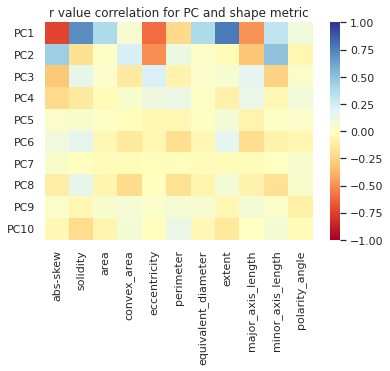

In [127]:
sns.heatmap(pearsoncorr_rval_pc_shape_df.T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False)
plt.title('r value correlation for PC and shape metric')
plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape.eps',bbox_inches='tight')

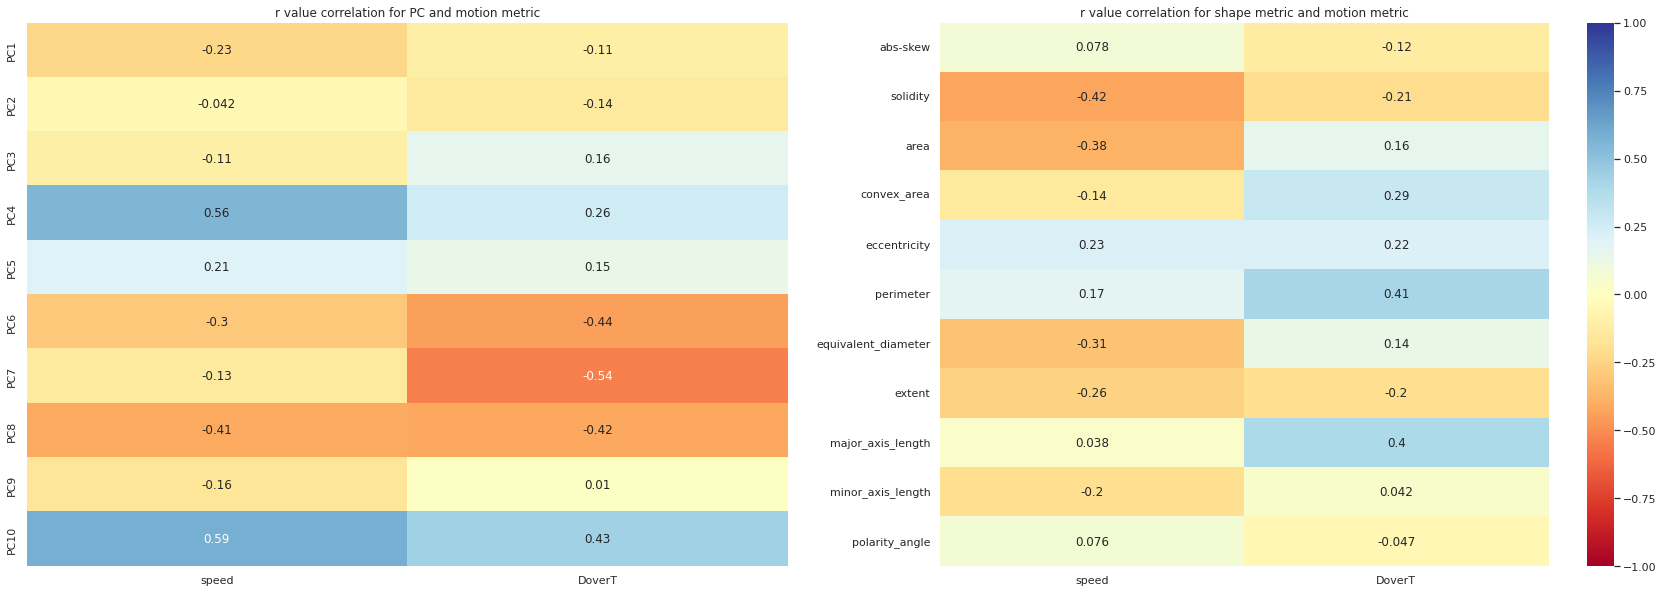

In [128]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(pearsoncorr_rval_pc_motion_df.T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = True, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and motion metric')
sns.heatmap(pearsoncorr_rval_shape_motion_df.T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = True, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and motion metric')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_Motion.eps',bbox_inches='tight')

TypeError: ignored

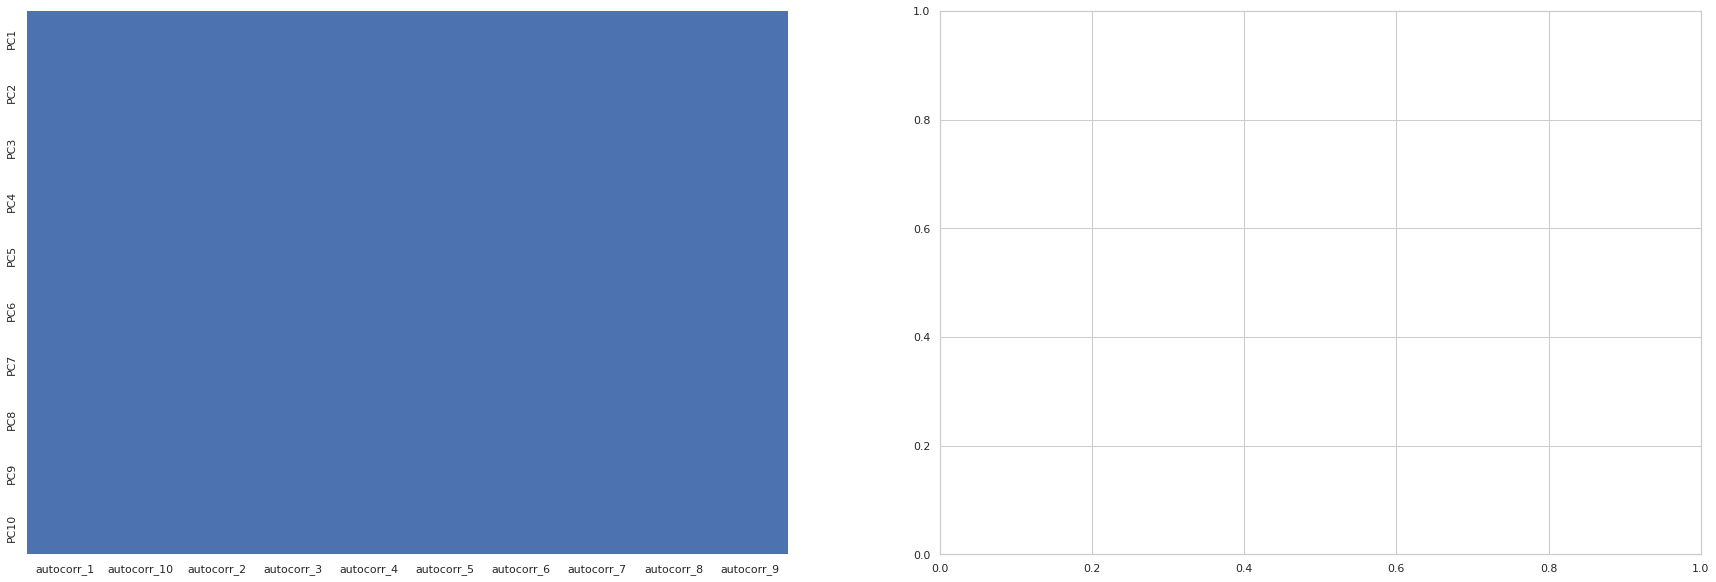

In [129]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^autocorr',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and autocorrelation (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^autocorr',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and autocorrelation (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_AutocorrHeteromotility.eps',bbox_inches='tight')

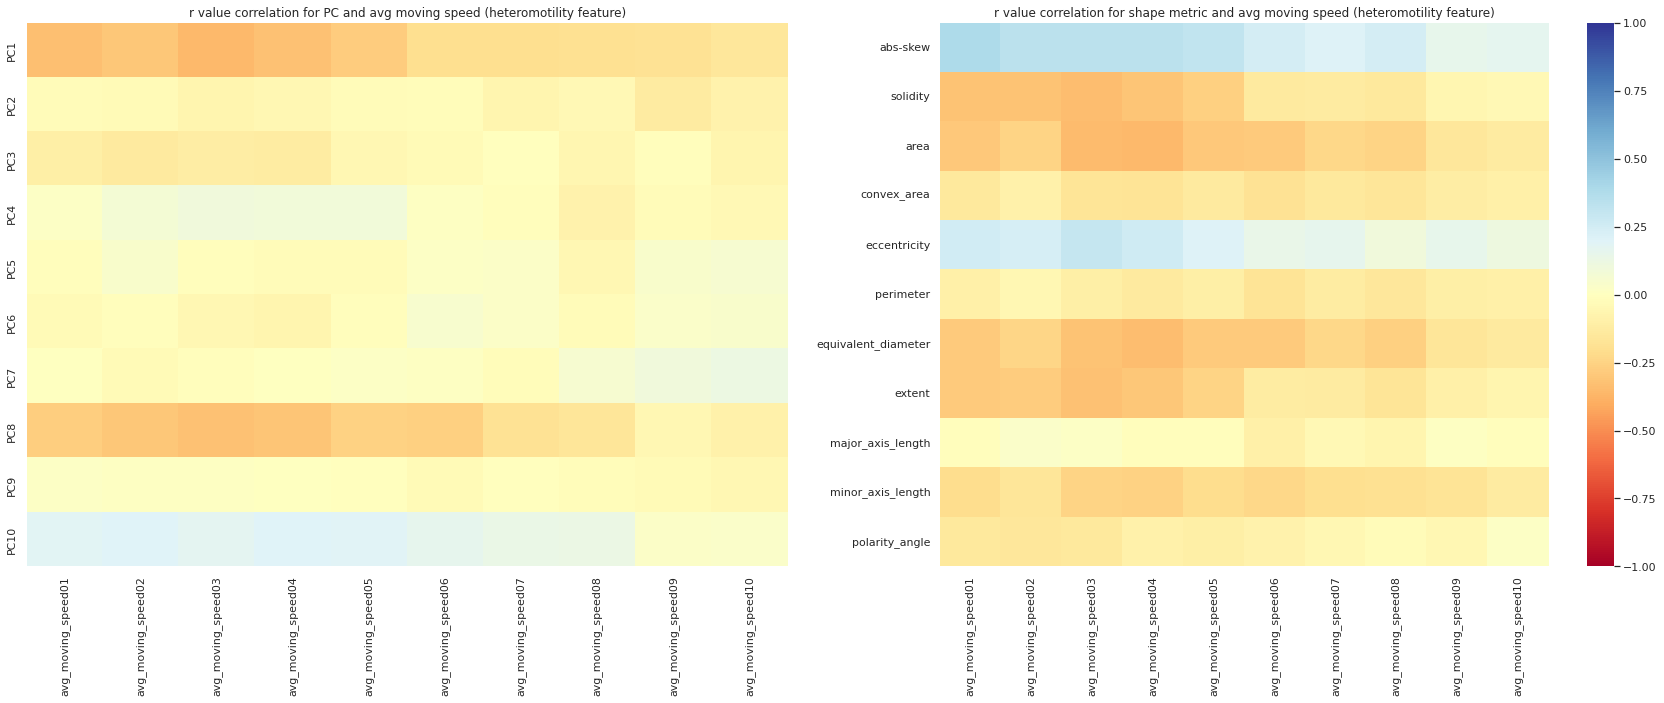

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and avg moving speed (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and avg moving speed (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_AvgMovSpeedHeteromotility.eps',bbox_inches='tight')

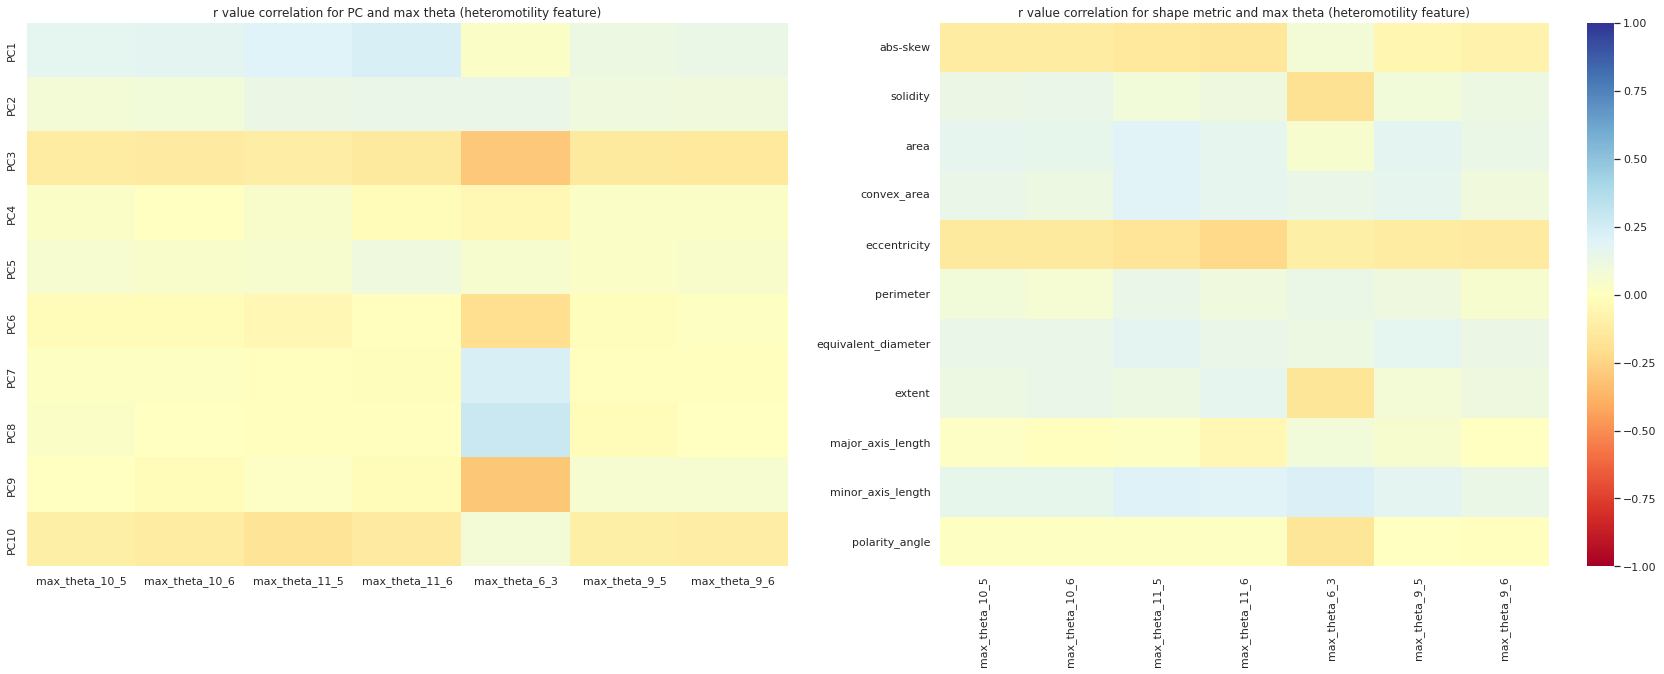

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^max_theta',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and max theta (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^max_theta',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and max theta (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_MaxThetaHeteromotility.eps',bbox_inches='tight')

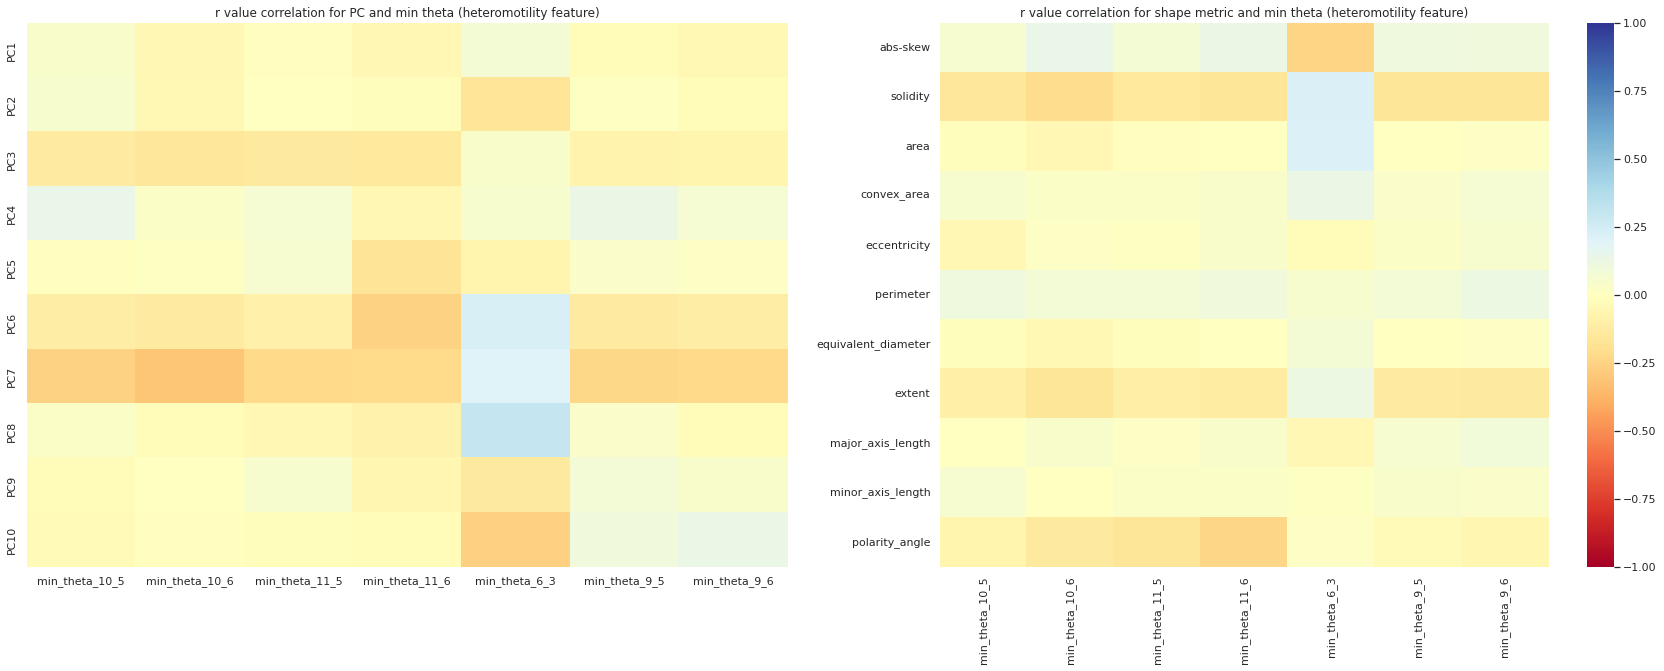

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^min_theta',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and min theta (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^min_theta',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and min theta (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_MinThetaHeteromotility.eps',bbox_inches='tight')

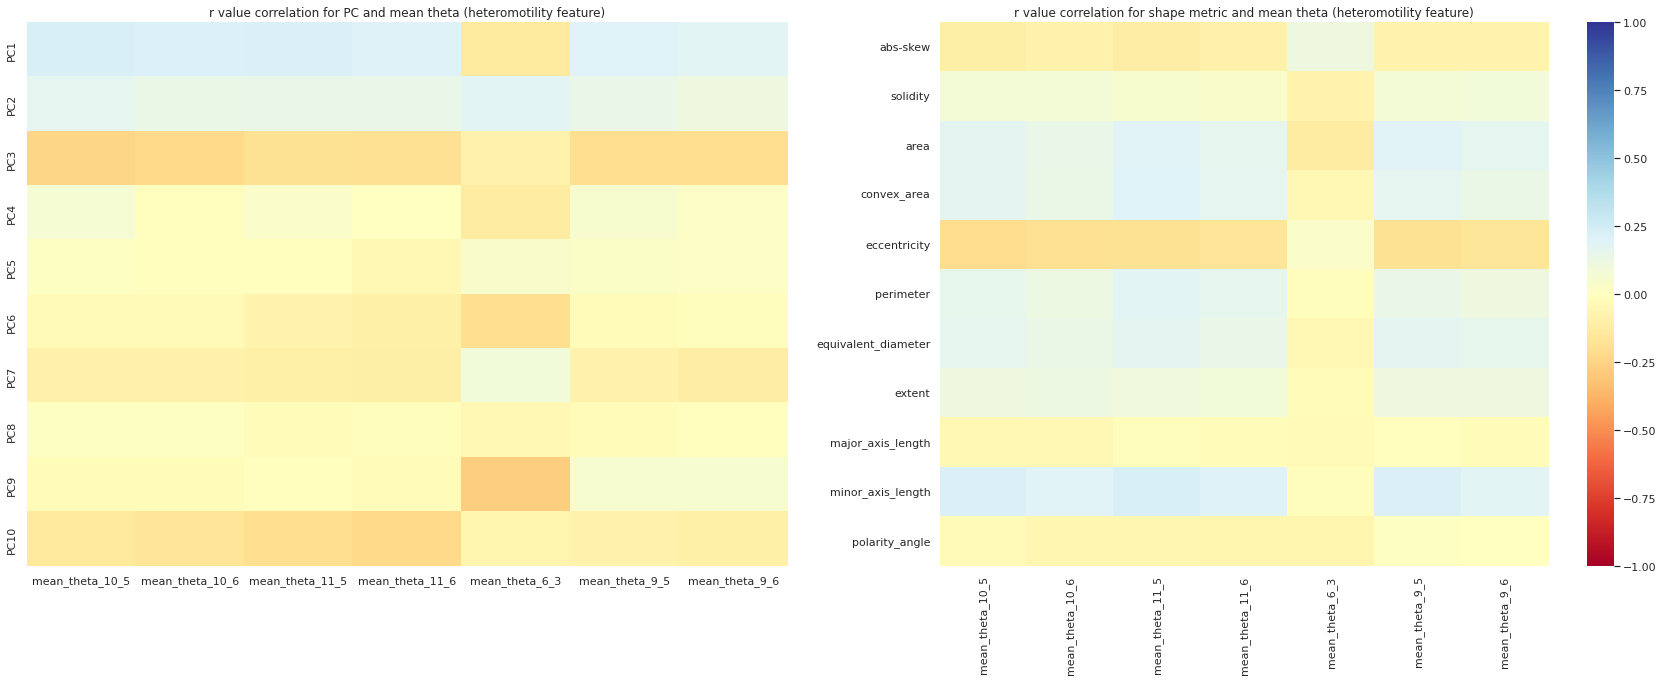

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^mean_theta',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and mean theta (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^mean_theta',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and mean theta (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_MeanThetaHeteromotility.eps',bbox_inches='tight')

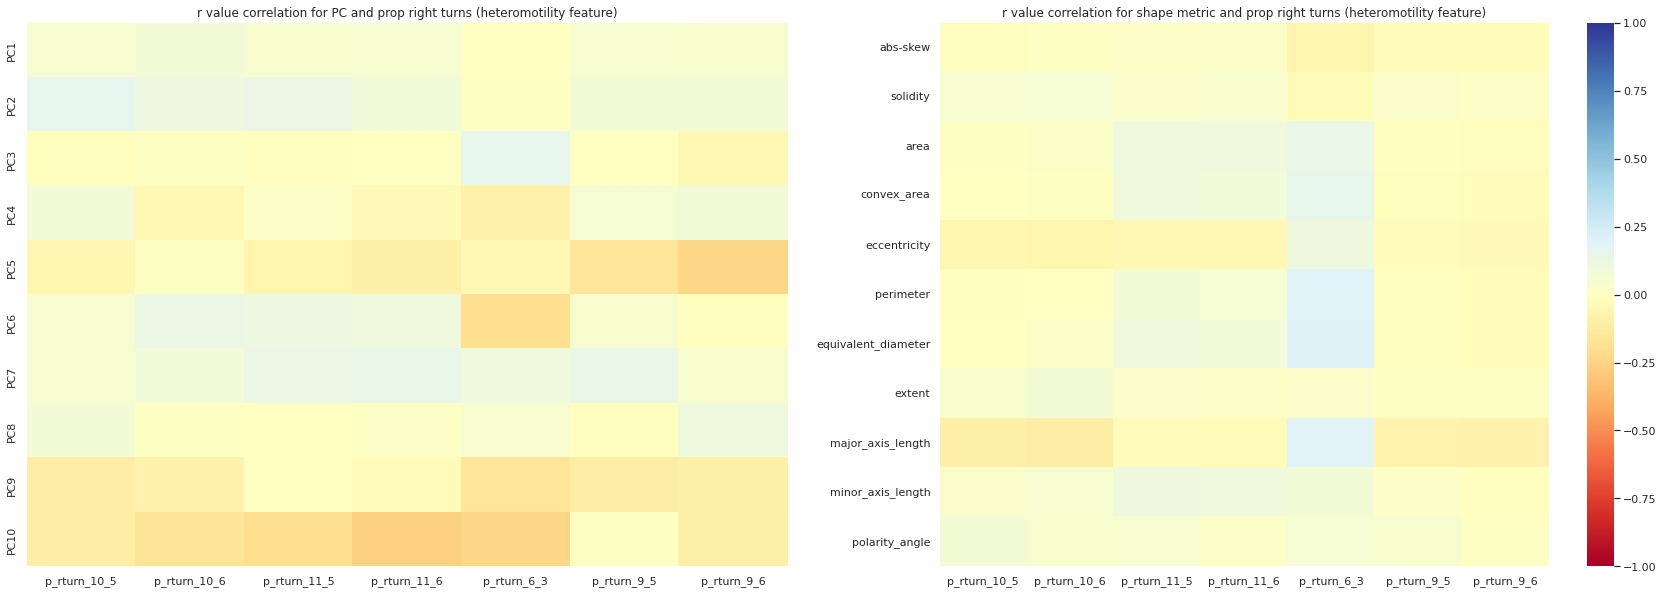

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^p_rturn',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and prop right turns (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^p_rturn',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and prop right turns (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_PRTurnHeteromotility.eps',bbox_inches='tight')

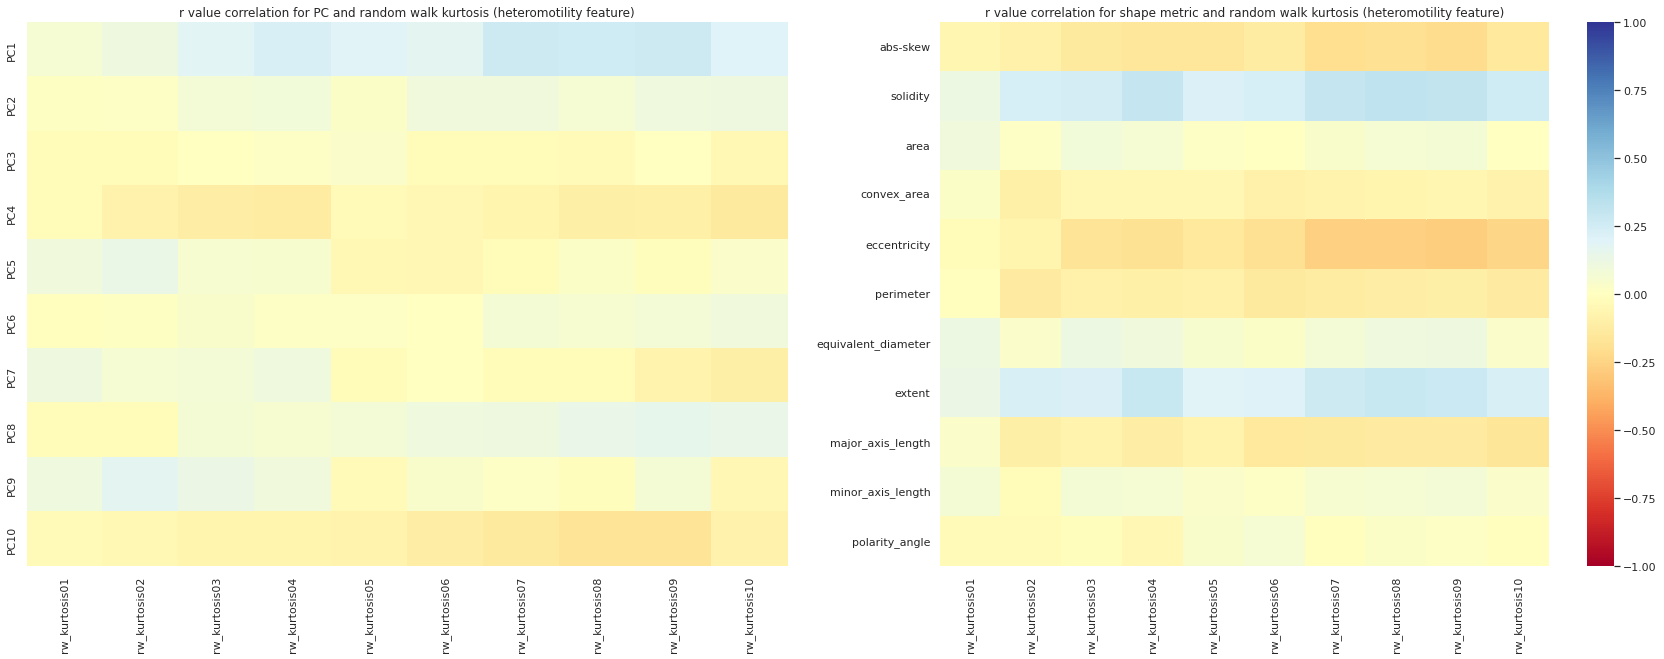

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and random walk kurtosis (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and random walk kurtosis (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_RWKurtosisHeteromotility.eps',bbox_inches='tight')

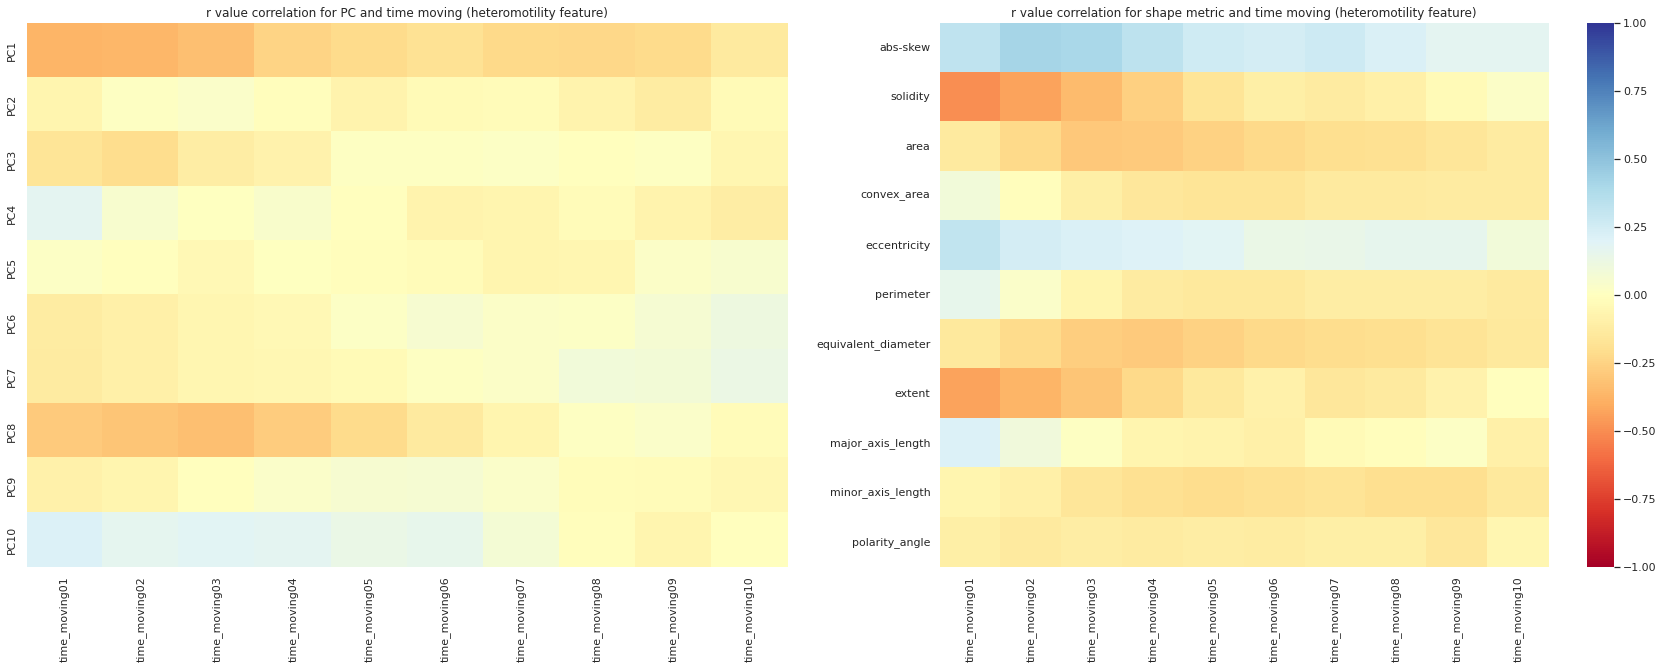

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^time_moving',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and time moving (heteromotility feature)')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^time_moving',axis='index')).T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and time moving (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_TimeMovingHeteromotility.eps',bbox_inches='tight')

TypeError: ignored

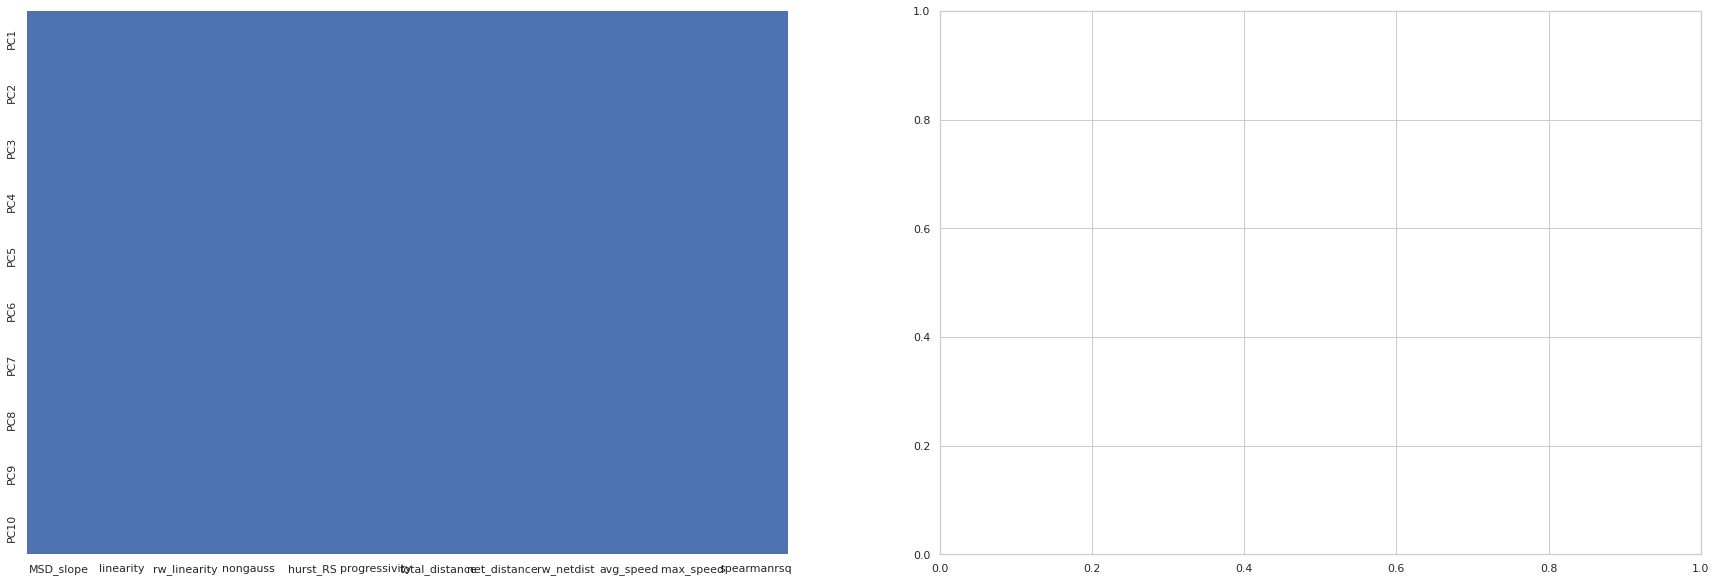

In [130]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.T)[other_het_feat], cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('r value correlation for PC and other heteromotility features')
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.T)[other_het_feat], cmap ='RdYlBu', vmin=-1, vmax=1, annot = False, ax=axes[1])
axes[1].set_title('r value correlation for shape metric and other heteromotility features')

plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Shape_OtherHeteromotility.eps',bbox_inches='tight')

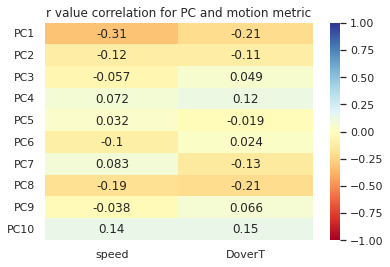

In [ ]:
sns.heatmap(pearsoncorr_rval_pc_motion_df.T, cmap ='RdYlBu', vmin=-1, vmax=1, annot = True)
plt.title('r value correlation for PC and motion metric')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_Motion.eps',bbox_inches='tight')

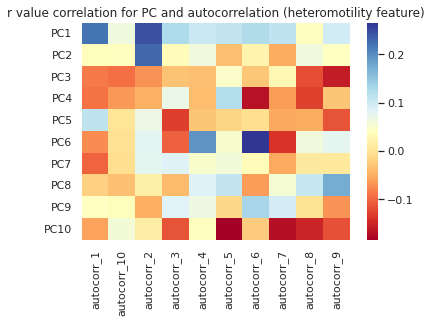

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^autocorr',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and autocorrelation (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_AutocorrHeteromotility.eps',bbox_inches='tight')

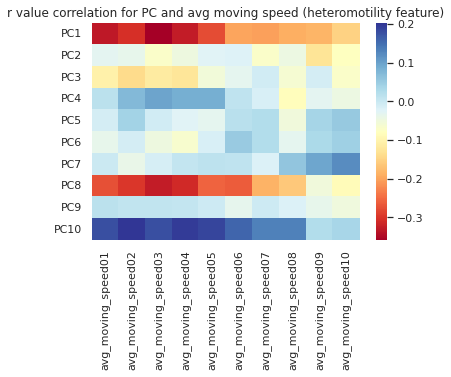

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and avg moving speed (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_AvgMovSpeedHeteromotility.eps',bbox_inches='tight')

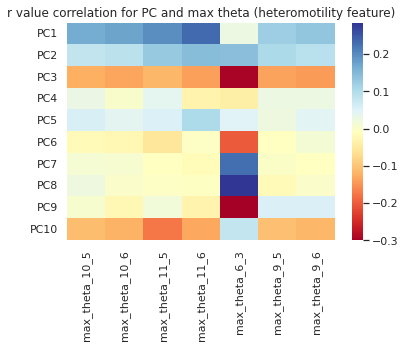

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^max_theta',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and max theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_MaxThetaHeteromotility.eps',bbox_inches='tight')

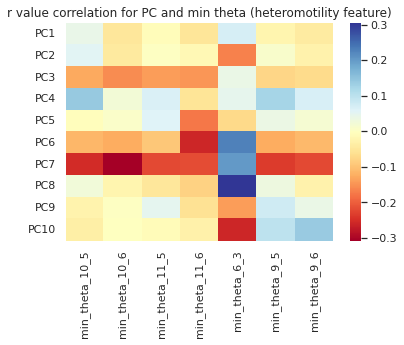

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^min_theta',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and min theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_MinThetaHeteromotility.eps',bbox_inches='tight')

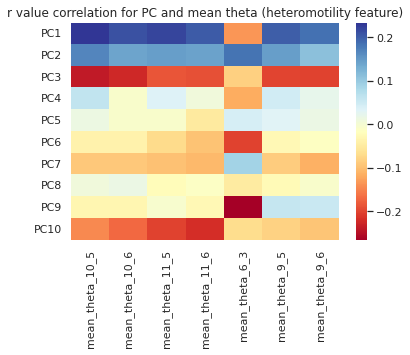

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^mean_theta',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and mean theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_MeanThetaHeteromotility.eps',bbox_inches='tight')

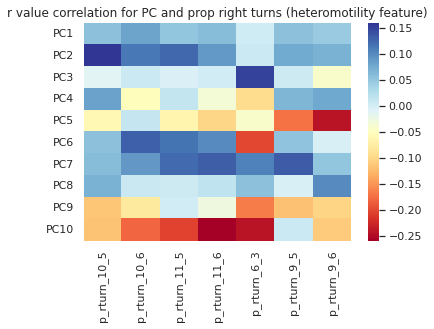

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^p_rturn',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and prop right turns (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_PRTurnHeteromotility.eps',bbox_inches='tight')

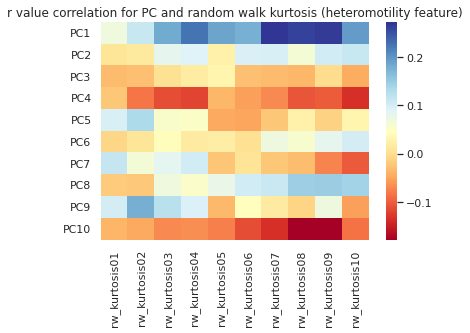

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and random walk kurtosis (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_RWKurtosisHeteromotility.eps',bbox_inches='tight')

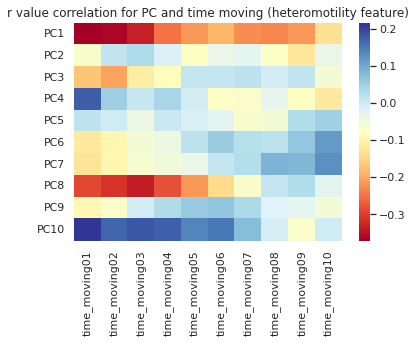

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.filter(regex='^time_moving',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and time moving (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_TimeMovingHeteromotility.eps',bbox_inches='tight')

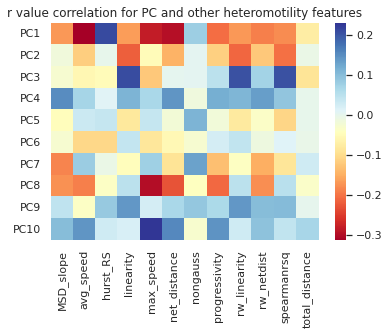

In [ ]:
sns.heatmap((pearsoncorr_rval_pc_heteromotility_df.T)[other_het_feat], cmap ='RdYlBu', annot = False)
plt.title('r value correlation for PC and other heteromotility features')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_PC_OtherHeteromotility.eps',bbox_inches='tight')

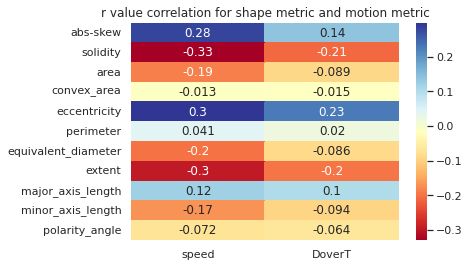

In [ ]:
sns.heatmap(pearsoncorr_rval_shape_motion_df.T, cmap ='RdYlBu', annot = True)
plt.title('r value correlation for shape metric and motion metric')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_Motion.eps',bbox_inches='tight')

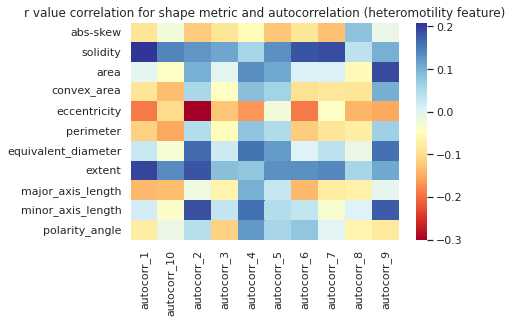

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^autocorr',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and autocorrelation (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_AutocorrHeteromotility.eps',bbox_inches='tight')

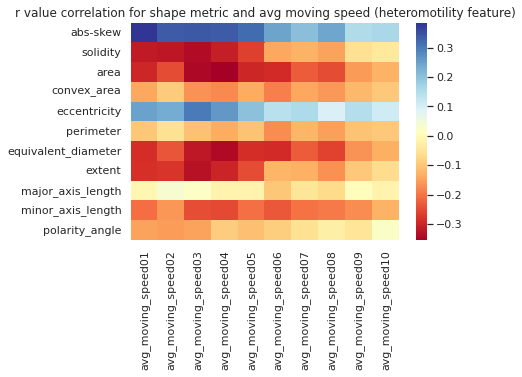

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and avg moving speed (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_AvgMovSpeedHeteromotility.eps',bbox_inches='tight')

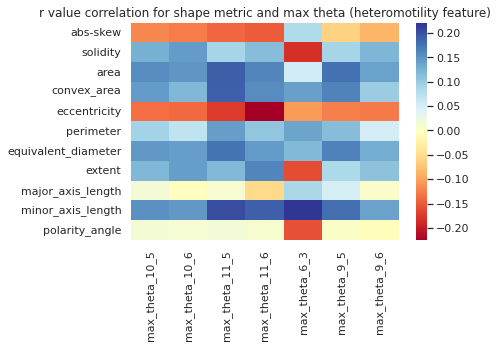

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^max_theta',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and max theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_MaxThetaHeteromotility.eps',bbox_inches='tight')

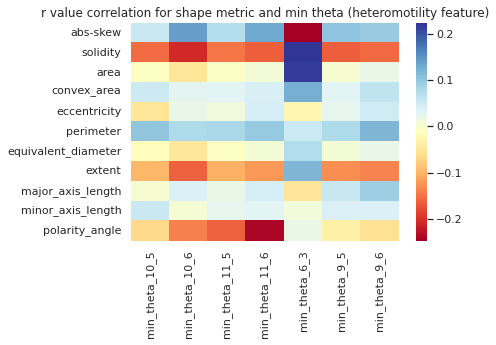

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^min_theta',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and min theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_MinThetaHeteromotility.eps',bbox_inches='tight')

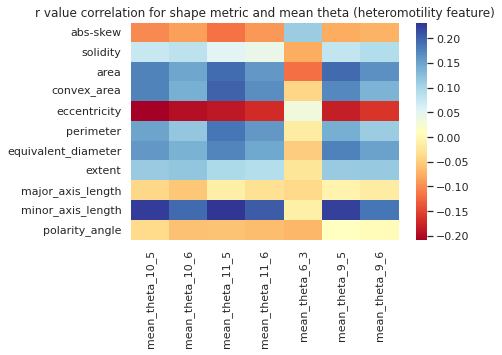

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^mean_theta',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and mean theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_MeanThetaHeteromotility.eps',bbox_inches='tight')

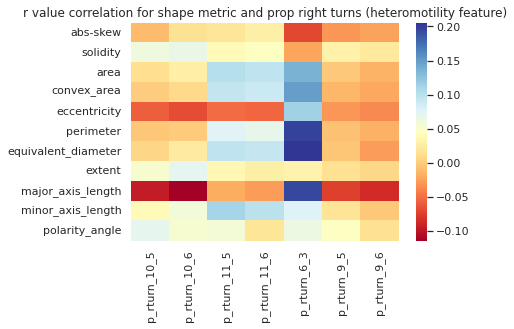

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^p_rturn',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and prop right turns (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_PRTurnHeteromotility.eps',bbox_inches='tight')

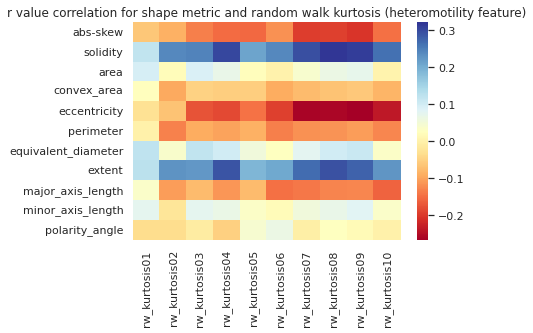

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and random walk kurtosis (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_RWKurtosisHeteromotility.eps',bbox_inches='tight')

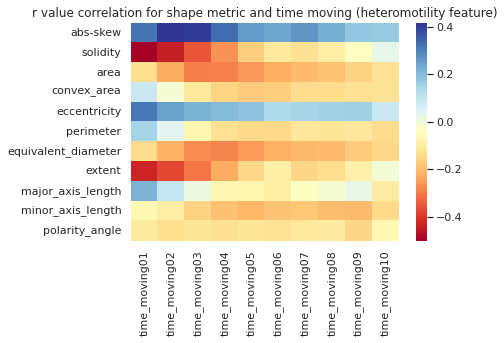

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.filter(regex='^time_moving',axis='index')).T, cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and time moving (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_TimeMovingHeteromotility.eps',bbox_inches='tight')

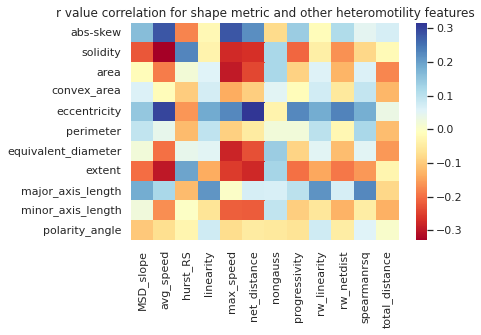

In [ ]:
sns.heatmap((pearsoncorr_rval_shape_heteromotility_df.T)[other_het_feat], cmap ='RdYlBu', annot = False)
plt.title('r value correlation for shape metric and other heteromotility features')
#plt.savefig('/content/figures/corr_plots/heatmaps/Stiff_Shape_OtherHeteromotility.eps',bbox_inches='tight')

### P Val Heatmaps

In [ ]:
-np.log10(.05)

1.3010299956639813

In [131]:
!mkdir figures/corr_plots/heatmaps/pval

In [132]:
(pearsoncorr_pval_pc_shape_df.T)

abs-skew      solidity          area   convex_area   eccentricity  \
PC1    0.000000e+00  0.000000e+00  3.958079e-87  6.087405e-03  1.518204e-242   
PC2   3.592481e-118  6.689110e-21  2.707326e-01  1.684152e-31  3.789341e-149   
PC3    5.578604e-51  1.792632e-14  6.188790e-02  5.961335e-10   1.716025e-28   
PC4    2.577901e-28  4.381629e-11  3.224336e-01  3.605126e-02   9.064930e-09   
PC5    8.607127e-02  3.228608e-02  3.630515e-01  5.405168e-01   2.278691e-02   
PC6    1.039746e-06  3.198418e-15  4.868349e-02  9.718486e-13   5.307702e-03   
PC7    2.835633e-02  9.433795e-01  2.077967e-01  2.262309e-01   6.310257e-01   
PC8    2.367239e-08  1.345661e-14  1.272028e-03  2.307639e-27   7.846877e-01   
PC9    5.834011e-02  1.691577e-02  1.480324e-02  1.211518e-03   8.236916e-02   
PC10   1.963274e-02  1.346082e-25  1.351091e-03  2.596021e-04   7.706752e-01   

         perimeter  equivalent_diameter        extent  major_axis_length  \
PC1   1.559394e-28         1.313934e-88  0.000000e+00      1.671085e-139   
PC2   2.631451e-09         1.585661e-01  3.957424e-01       3.665957e-55   
PC3   1.458108e-04         1.223339e-01  3.945889e-03       8.336847e-16   
PC4   1.961669e-10         4.129322e-01  1.060505e-05       1.100805e-12   
PC5   3.811185e-02         5.015685e-01  4.578761e-04       1.452274e-04   
PC6   1.709965e-23         7.278525e-03  2.388942e-17       2.027470e-24   
PC7   6.276458e-01         3.363066e-01  3.135176e-01       3.630984e-01   
PC8   2.754763e-19         1.831266e-03  6.633153e-05       2.892108e-05   
PC9   9.968474e-04         3.316273e-03  1.116659e-02       1.749892e-04   
PC10  4.691529e-12         3.513981e-02  2.017770e-12       8.188567e-01   

      minor_axis_length  polarity_angle  
PC1        7.848144e-62        0.000002  
PC2       2.579158e-149        0.005631  
PC3        5.248439e-36        0.084439  
PC4        4.507274e-02        0.000019  
PC5        4.377092e-01        0.124233  
PC6        2.953236e-04        0.002915  
PC7        7.069309e-01        0.015254  
PC8        9.727314e-22        0.024406  
PC9        1.157434e-01        0.000003  
PC10       1.198909e-04        0.162104

In [133]:
-np.log10(pearsoncorr_pval_pc_shape_df.T)

abs-skew   solidity       area  convex_area  eccentricity  perimeter  \
PC1          inf        inf  86.402516     2.215568    241.818670  27.807044   
PC2   117.444606  20.174632   0.567460    30.773619    148.421436   8.579805   
PC3    50.253474  13.746509   1.208394     9.224657     27.765476   3.836210   
PC4    27.588734  10.358364   0.491560     1.443080      8.042636   9.707374   
PC5     1.065142   1.490985   0.440032     0.267191      1.642315   1.418940   
PC6     5.983073  14.495065   1.312618    12.012401      2.275093  22.767013   
PC7     1.547350   0.025314   0.682361     0.645448      0.199953   0.202285   
PC8     7.625758  13.871064   2.895503    26.636832      0.105303  18.559916   
PC9     1.234033   1.771708   1.829643     2.916670      1.084235   3.001371   
PC10    1.707019  24.870929   2.869315     3.585692      0.113129  11.328686   

      equivalent_diameter     extent  major_axis_length  minor_axis_length  \
PC1             87.881426        inf         138.777002          61.105233   
PC2              0.799790   0.402587          54.435813         148.588522   
PC3              0.912453   2.403855          15.078998          35.279970   
PC4              0.384121   4.974487          11.958290           1.346086   
PC5              0.299670   3.339252           3.837951           0.358814   
PC6              2.137957  16.621794          23.693045           3.529702   
PC7              0.473265   0.503738           0.439976           0.150623   
PC8              2.737249   4.178280           4.538786          21.012007   
PC9              2.479350   1.952079           3.756989           0.936504   
PC10             1.454201  11.695128           0.086792           3.921214   

      polarity_angle  
PC1         5.803564  
PC2         2.249413  
PC3         1.073459  
PC4         4.720874  
PC5         0.905764  
PC6         2.535403  
PC7         1.816628  
PC8         1.612498  
PC9         5.537189  
PC10        0.790207

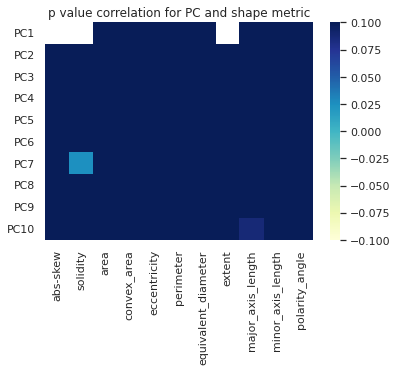

In [134]:
sns.heatmap(-np.log10(pearsoncorr_pval_pc_shape_df.T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and shape metric')
plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape.eps',bbox_inches='tight')

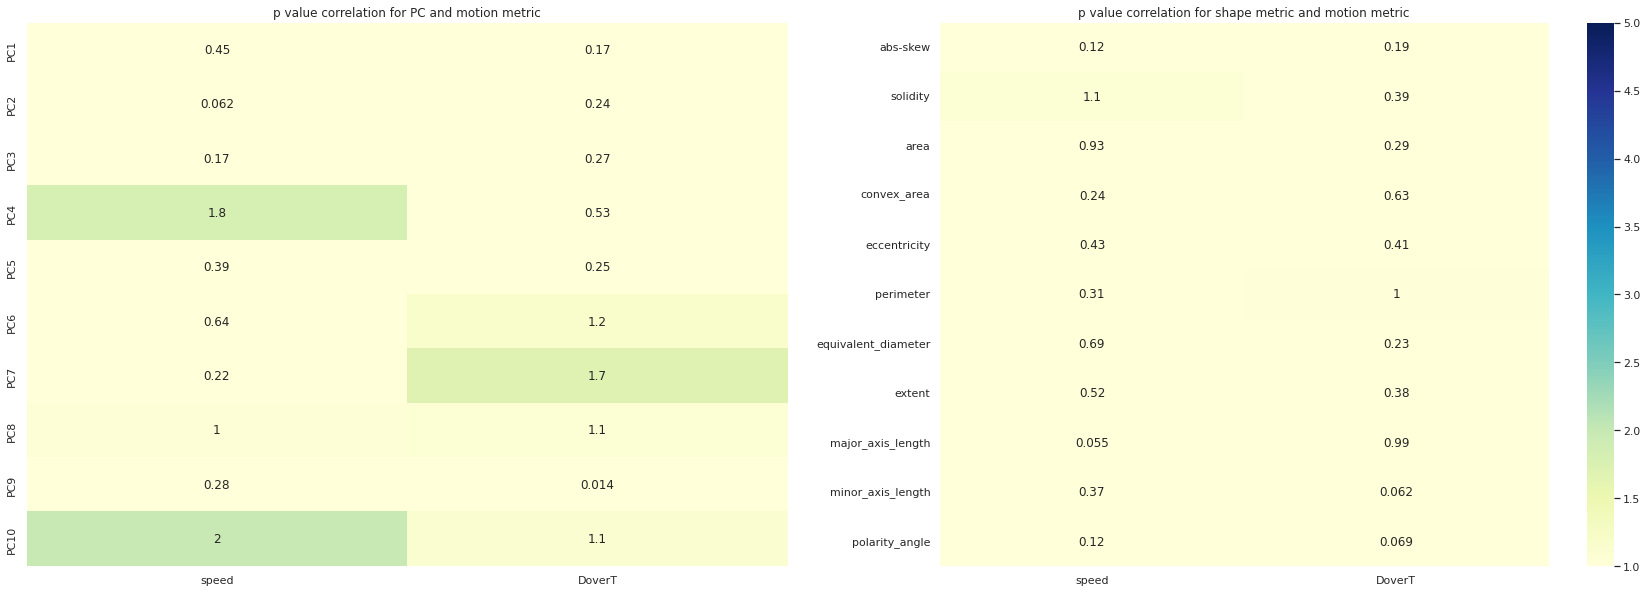

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10(pearsoncorr_pval_pc_motion_df.T), cmap='YlGnBu', vmin=1, vmax=5, annot = True, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and motion metric')
sns.heatmap(-np.log10(pearsoncorr_pval_shape_motion_df.T), cmap ='YlGnBu', vmin=1, vmax=5, annot = True, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and motion metric')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_Motion.eps',bbox_inches='tight')

TypeError: ignored

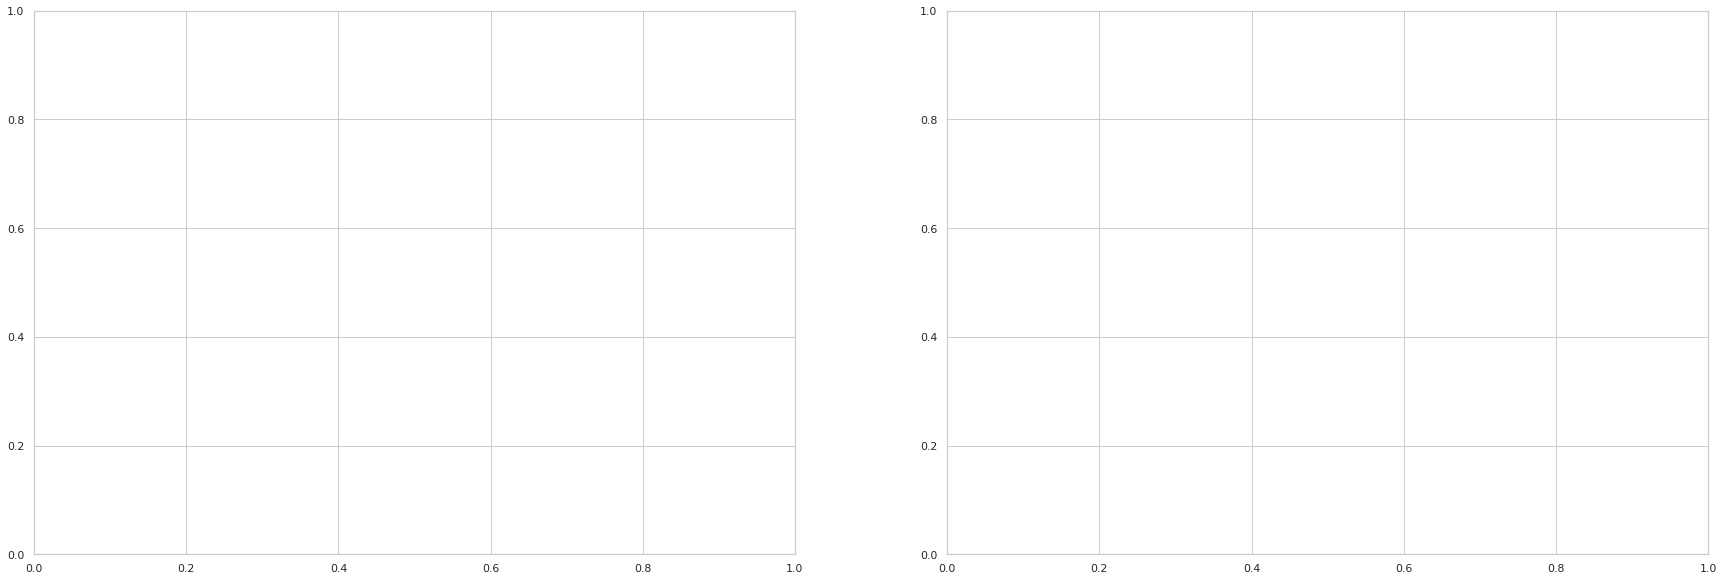

In [136]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^autocorr',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and autocorrelation (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^autocorr',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and autocorrelation (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_AutocorrHeteromotility.eps',bbox_inches='tight')

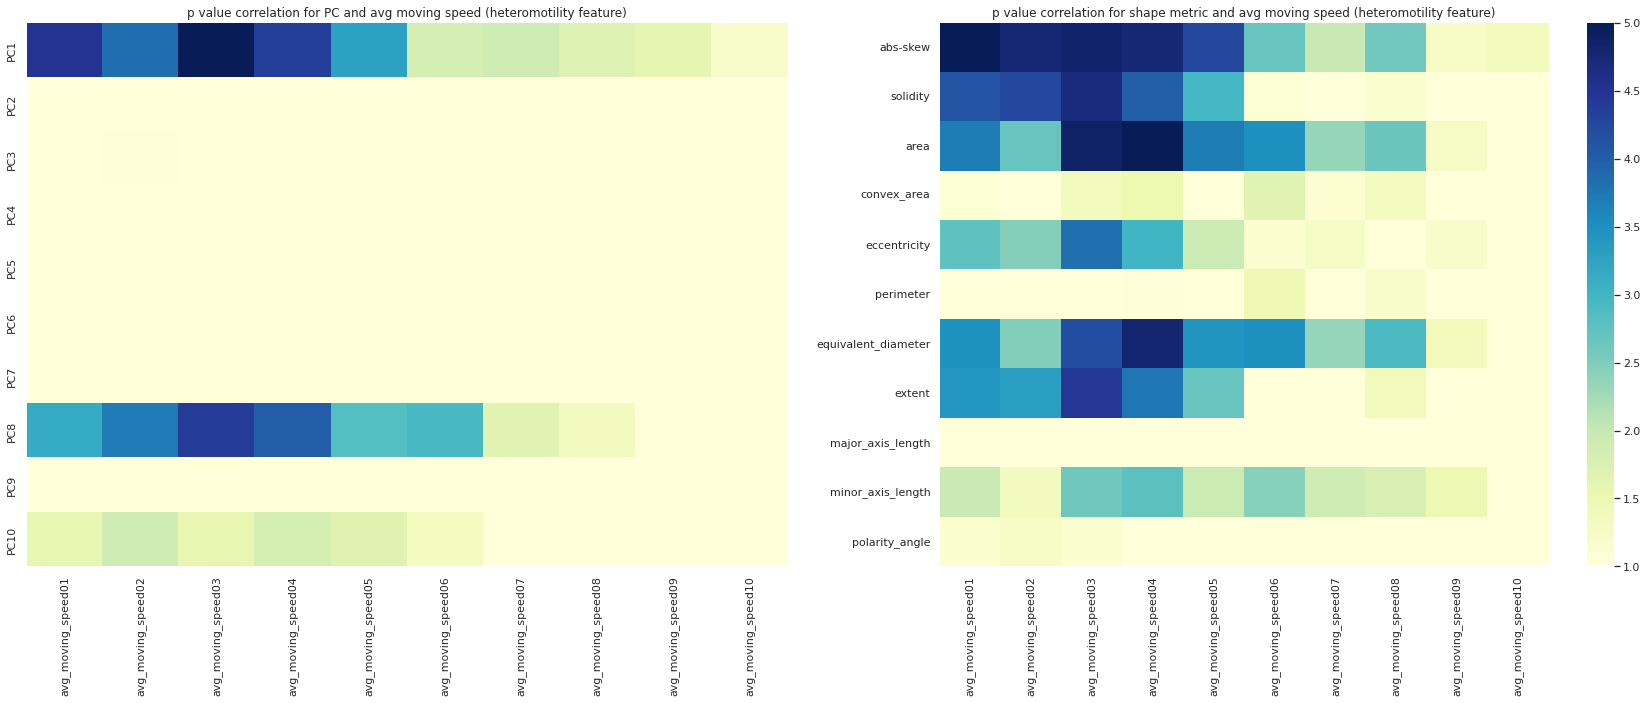

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and avg moving speed (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and avg moving speed (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_AvgMovSpeedHeteromotility.eps',bbox_inches='tight')

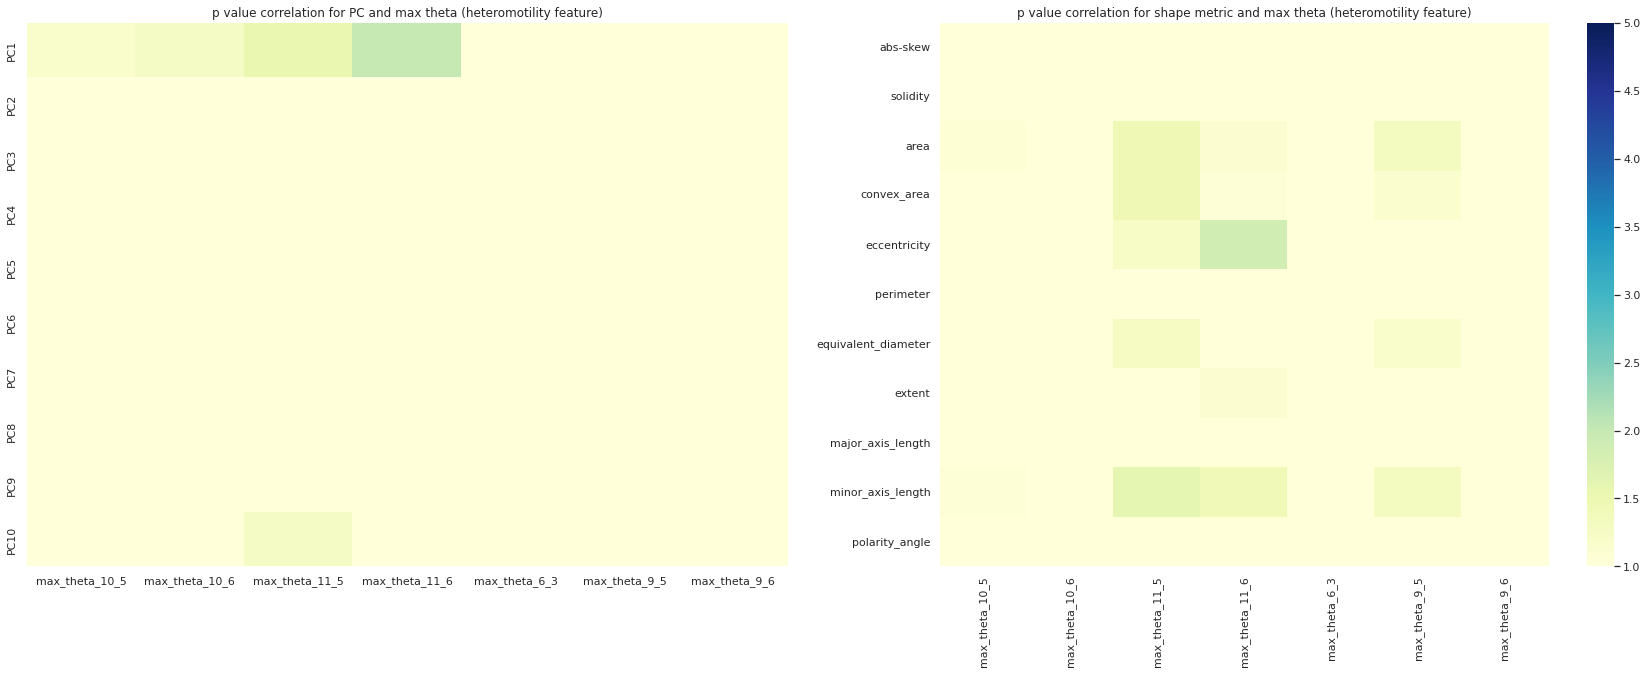

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^max_theta',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and max theta (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^max_theta',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and max theta (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_MaxThetaHeteromotility.eps',bbox_inches='tight')

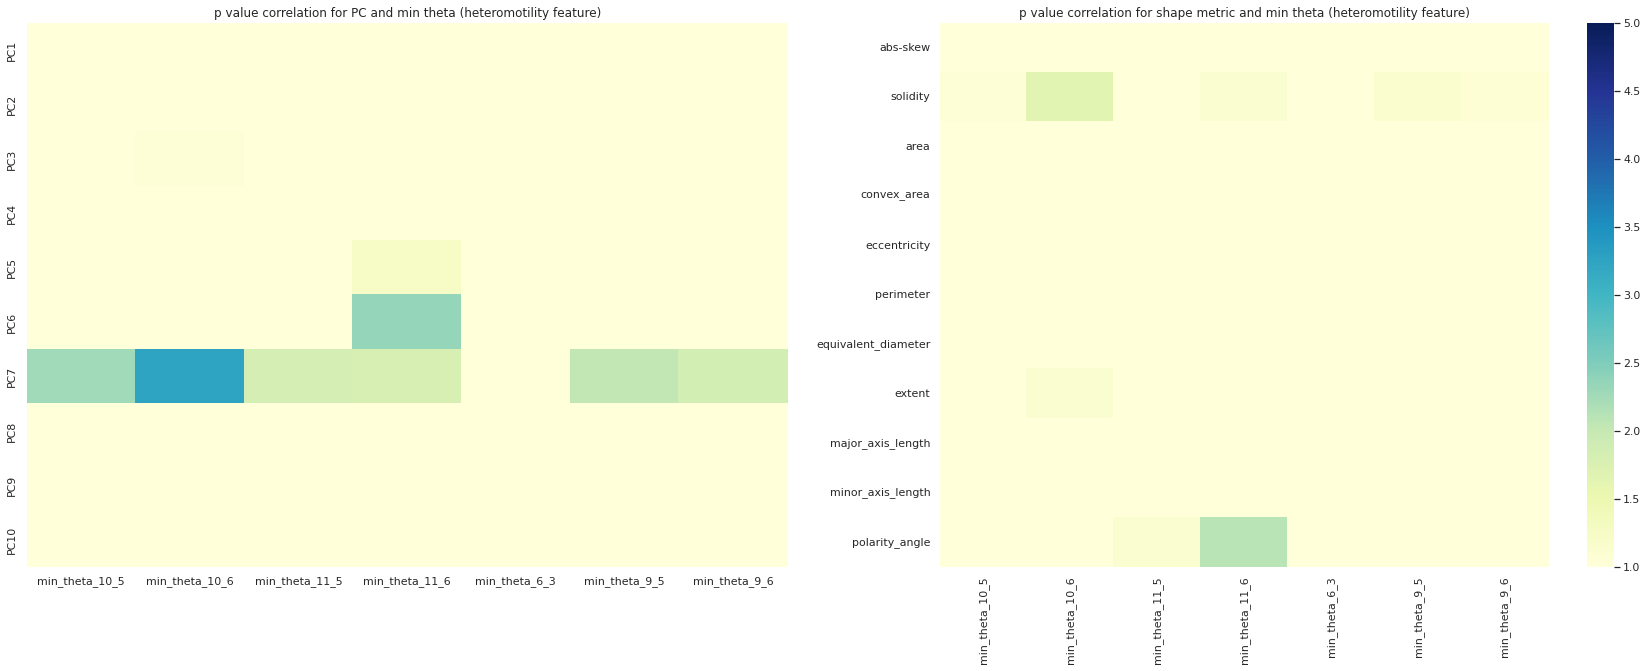

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^min_theta',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and min theta (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^min_theta',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and min theta (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_MinThetaHeteromotility.eps',bbox_inches='tight')

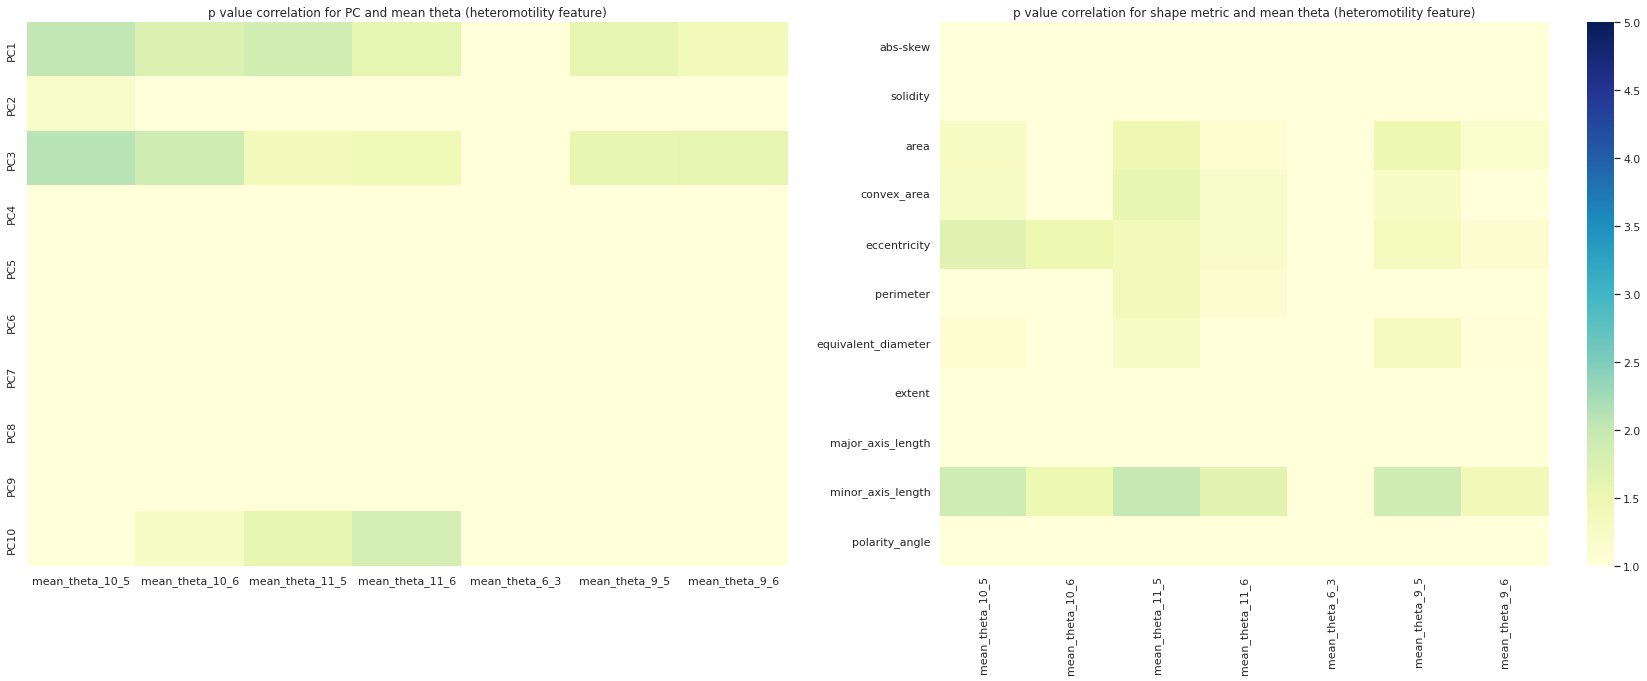

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^mean_theta',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and mean theta (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^mean_theta',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and mean theta (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_MeanThetaHeteromotility.eps',bbox_inches='tight')

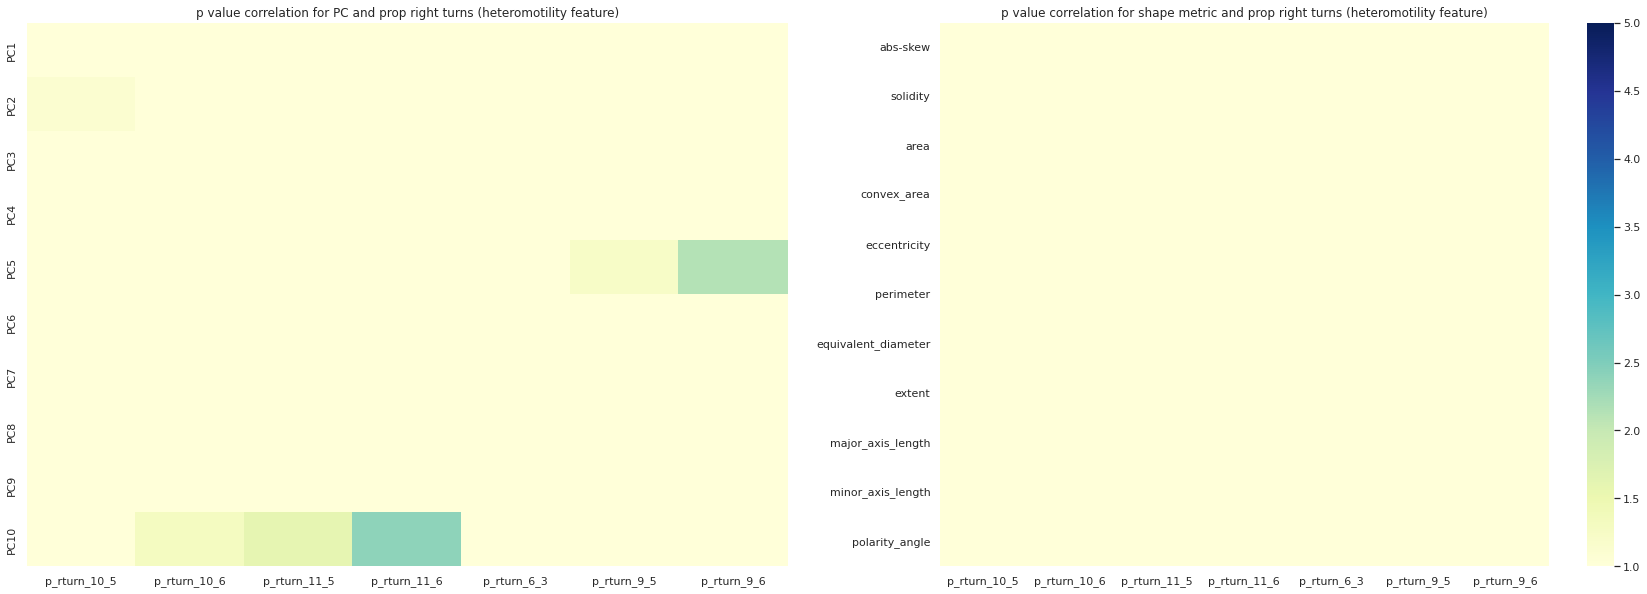

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^p_rturn',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and prop right turns (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^p_rturn',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and prop right turns (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_PRTurnHeteromotility.eps',bbox_inches='tight')

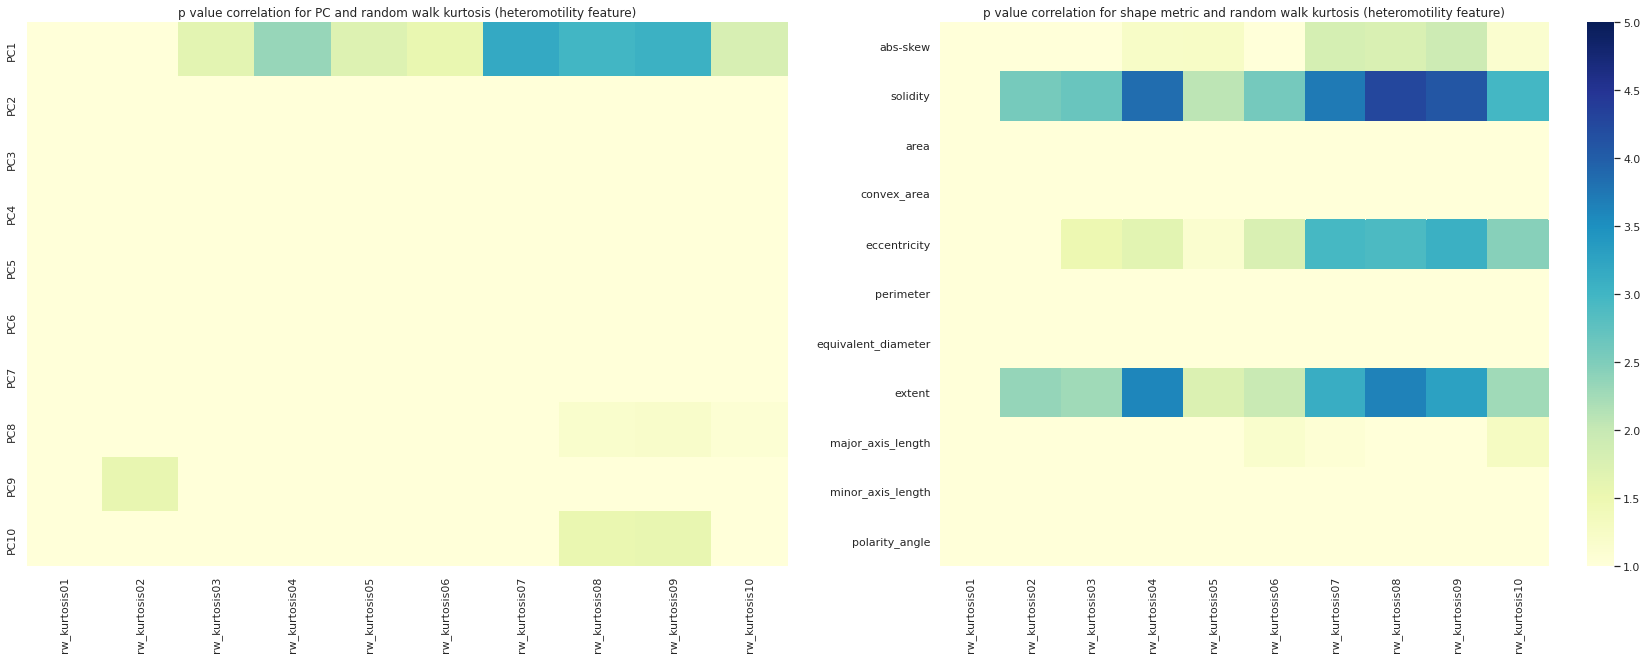

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and random walk kurtosis (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and random walk kurtosis (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_RWKurtosisHeteromotility.eps',bbox_inches='tight')

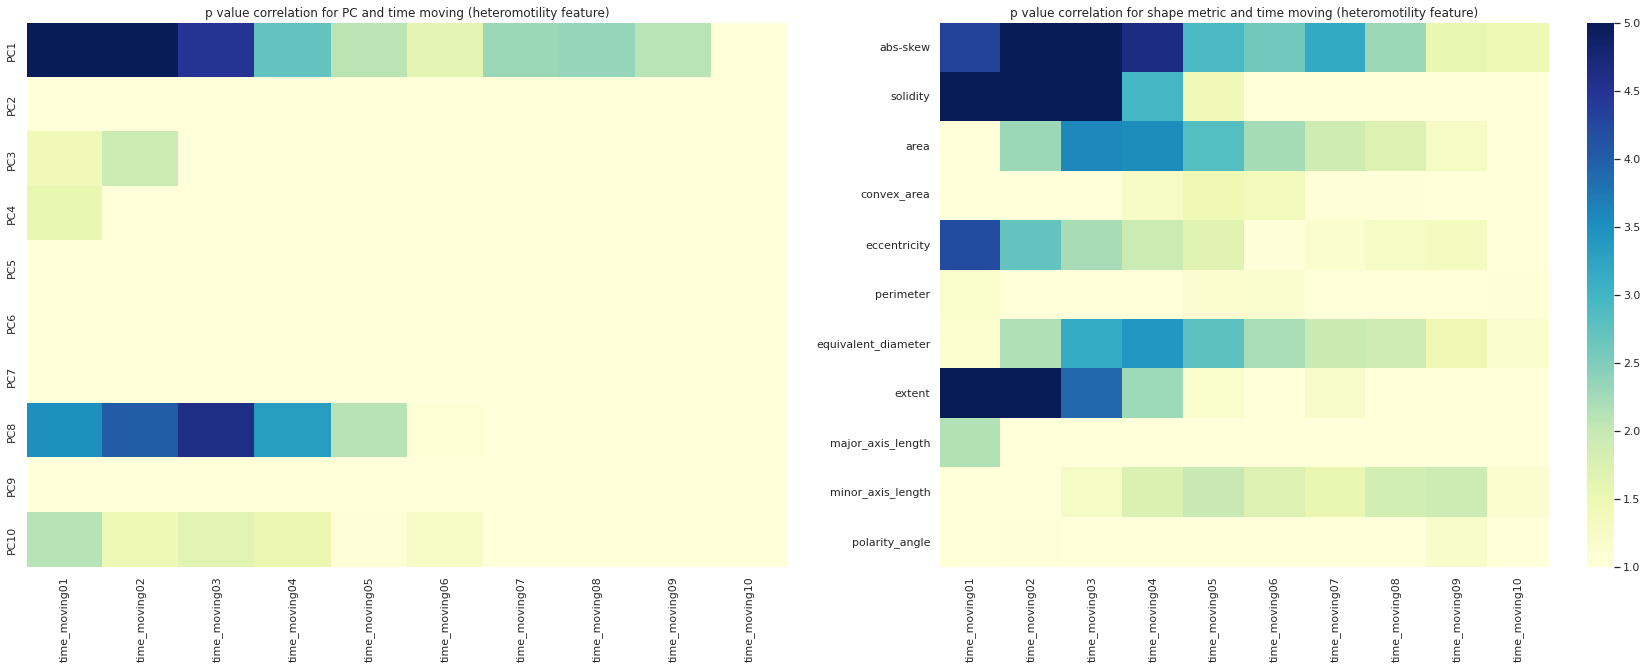

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^time_moving',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and time moving (heteromotility feature)')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^time_moving',axis='index')).T), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and time moving (heteromotility feature)')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_TimeMovingHeteromotility.eps',bbox_inches='tight')

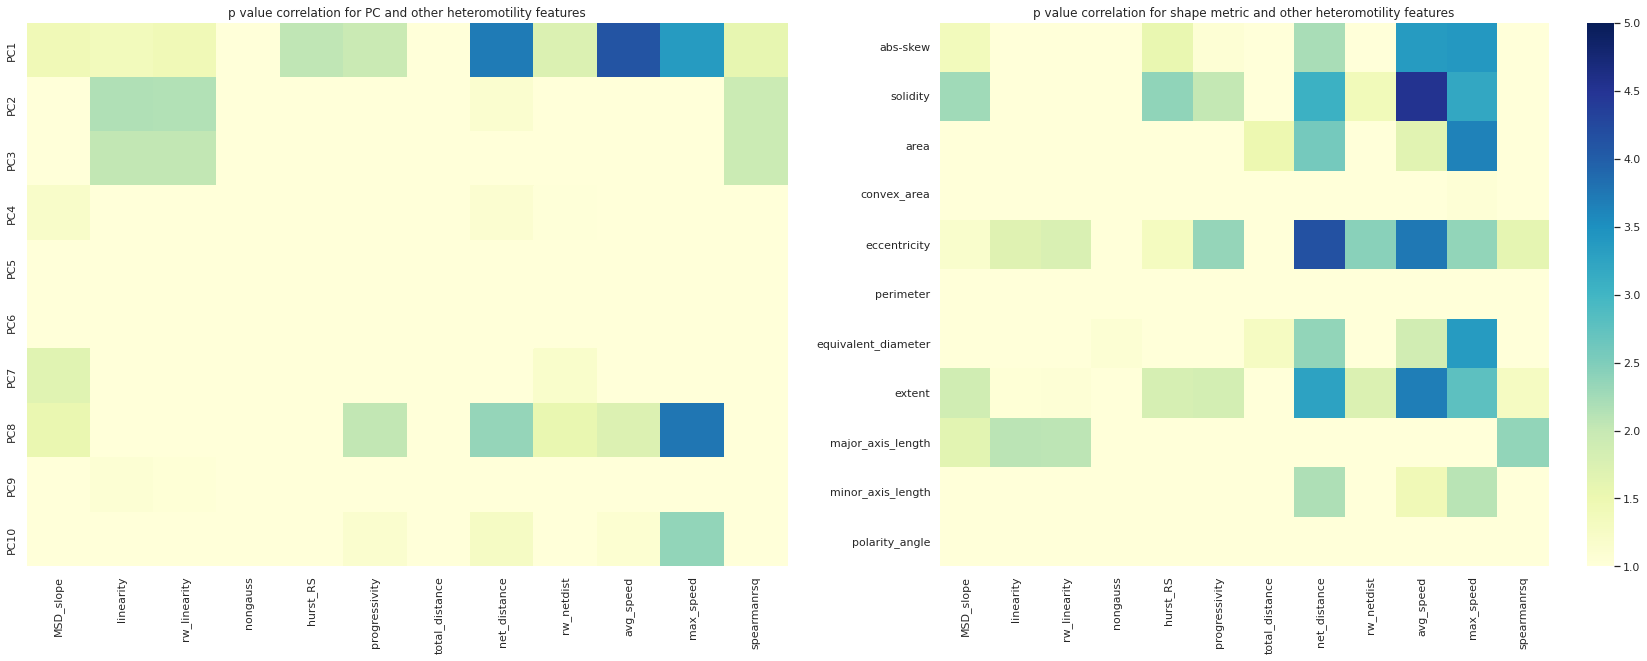

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (30,10))

sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.T)[other_het_feat]), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[0], cbar=False)
axes[0].set_title('p value correlation for PC and other heteromotility features')
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.T)[other_het_feat]), cmap ='YlGnBu', vmin=1, vmax=5, annot = False, ax=axes[1])
axes[1].set_title('p value correlation for shape metric and other heteromotility features')

plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Shape_OtherHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and motion metric')

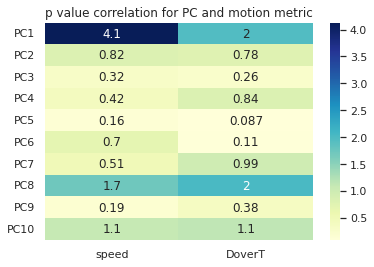

In [ ]:
sns.heatmap(-np.log10(pearsoncorr_pval_pc_motion_df.T), cmap='YlGnBu', annot = True)
plt.title('p value correlation for PC and motion metric')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_Motion.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and autocorrelation (heteromotility feature)')

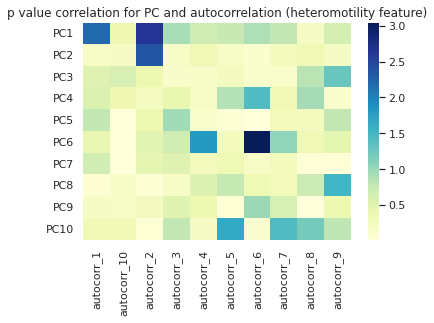

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^autocorr',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and autocorrelation (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_AutocorrHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and avg moving speed (heteromotility feature)')

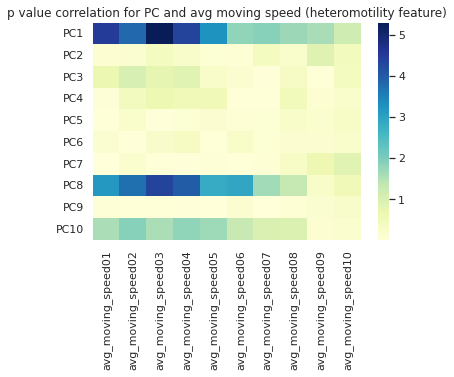

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and avg moving speed (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_AvgMovSpeedHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and max theta (heteromotility feature)')

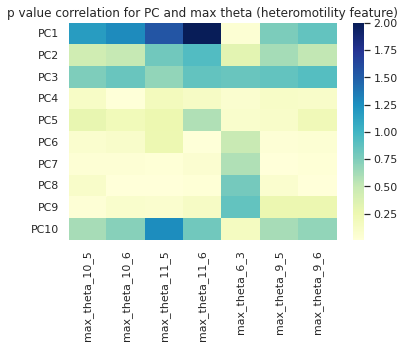

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^max_theta',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and max theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_MaxThetaHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and min theta (heteromotility feature)')

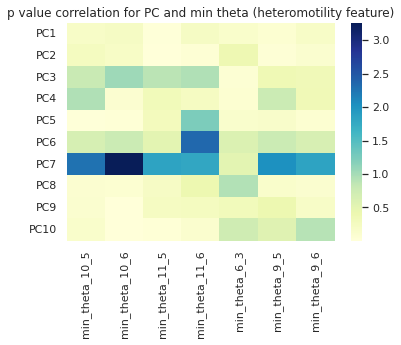

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^min_theta',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and min theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_MinThetaHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and mean theta (heteromotility feature)')

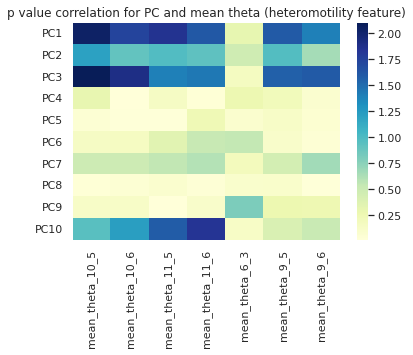

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^mean_theta',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and mean theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_MeanThetaHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and prop right turns (heteromotility feature)')

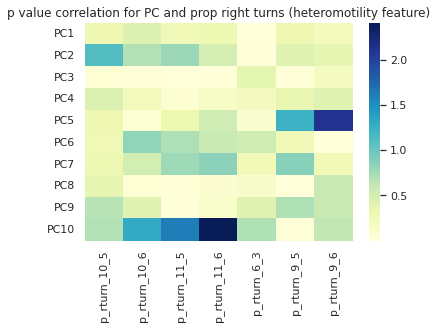

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^p_rturn',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and prop right turns (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_PRTurnHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and random walk kurtosis (heteromotility feature)')

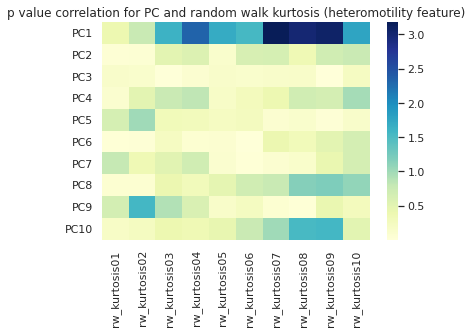

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and random walk kurtosis (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_RWKurtosisHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and time moving (heteromotility feature)')

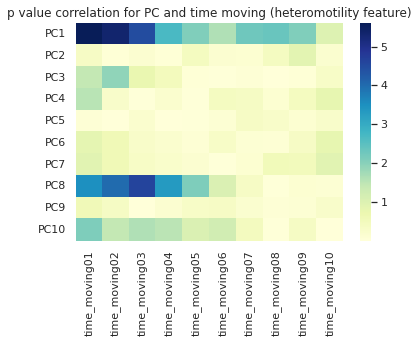

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_pc_heteromotility_df.filter(regex='^time_moving',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and time moving (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_TimeMovingHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for PC and other heteromotility features')

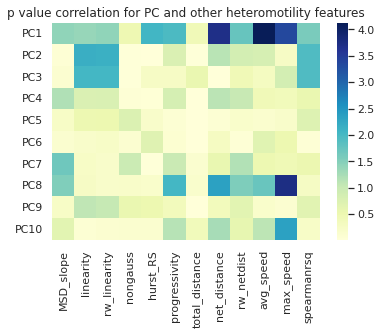

In [ ]:
sns.heatmap(-np.log10(pearsoncorr_pval_pc_heteromotility_df.T[other_het_feat]), cmap='YlGnBu', annot = False)
plt.title('p value correlation for PC and other heteromotility features')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_PC_OtherHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and motion metric')

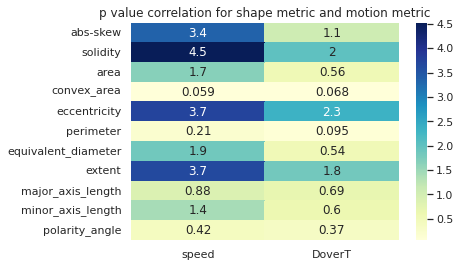

In [ ]:
sns.heatmap(-np.log10(pearsoncorr_pval_shape_motion_df.T), cmap='YlGnBu', annot = True)
plt.title('p value correlation for shape metric and motion metric')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_Motion.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and autocorrelation (heteromotility feature)')

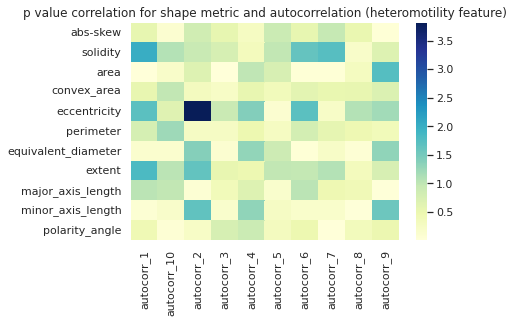

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^autocorr',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and autocorrelation (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_AutocorrHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and avg moving speed (heteromotility feature)')

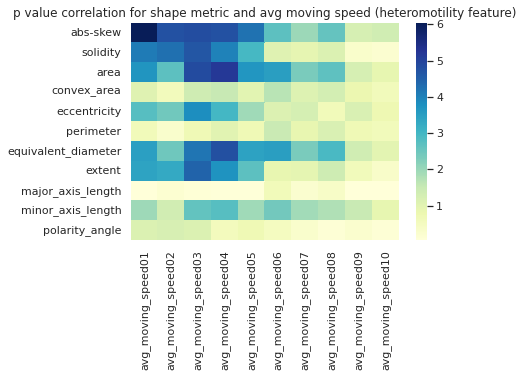

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^avg_moving_speed',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and avg moving speed (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_AvgMovSpeedHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and max theta (heteromotility feature)')

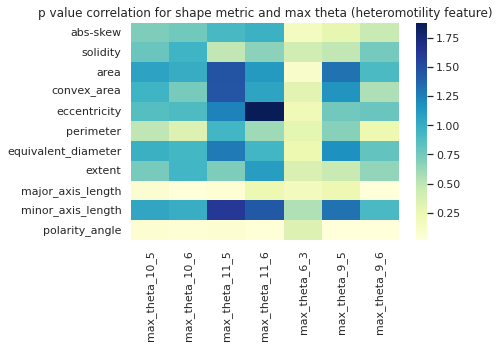

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^max_theta',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and max theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_MaxThetaHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and min theta (heteromotility feature)')

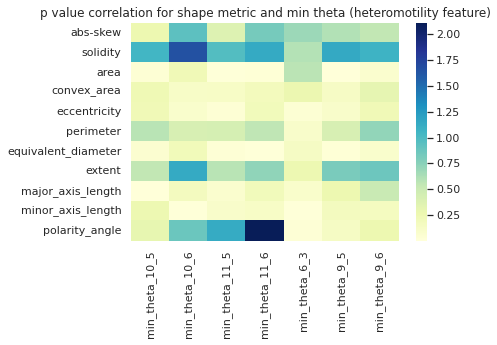

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^min_theta',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and min theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_MinThetaHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and mean theta (heteromotility feature)')

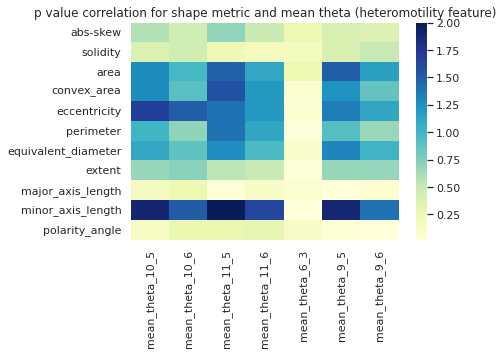

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^mean_theta',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and mean theta (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_MeanThetaHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and prop right turns (heteromotility feature)')

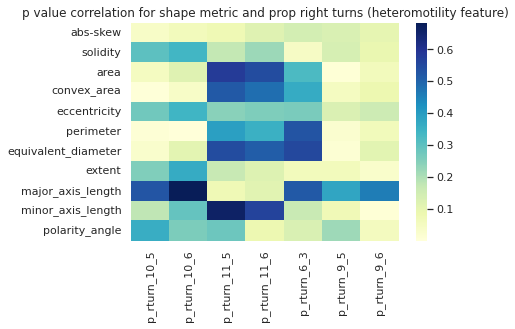

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^p_rturn',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and prop right turns (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_PRTurnHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and random walk kurtosis (heteromotility feature)')

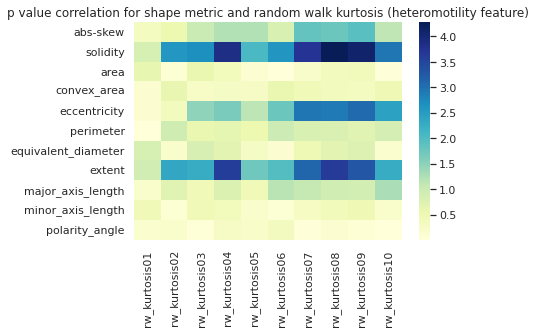

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^rw_kurtosis',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and random walk kurtosis (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_RWKurtosisHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and time moving (heteromotility feature)')

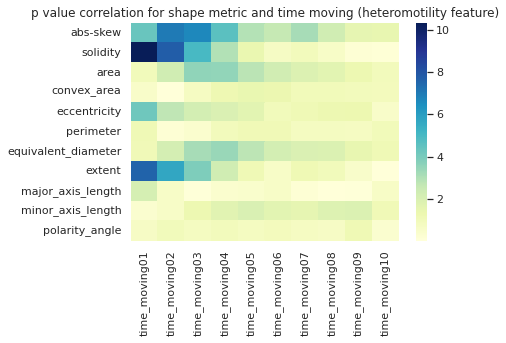

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.filter(regex='^time_moving',axis='index')).T), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and time moving (heteromotility feature)')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_TimeMovingHeteromotility.eps',bbox_inches='tight')

Text(0.5, 1.0, 'p value correlation for shape metric and other heteromotility features')

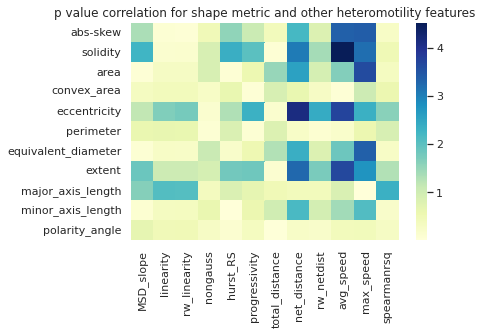

In [ ]:
sns.heatmap(-np.log10((pearsoncorr_pval_shape_heteromotility_df.T)[other_het_feat]), cmap='YlGnBu', annot = False)
plt.title('p value correlation for shape metric and other heteromotility features')
#plt.savefig('/content/figures/corr_plots/heatmaps/pval/Stiff_Shape_OtherHeteromotility.eps',bbox_inches='tight')

# Cell boundary recreation from PCs

Using raw normalized boundary points to plot cell boundary shape

In [ ]:
!mkdir figures/pc_cellshape

In [ ]:
image_name = 'controls_2019_062819_sample2_track3'

In [ ]:
x=stiff_movies[image_name]['Boundary coordinates'][1][0:coord_num]
y=stiff_movies[image_name]['Boundary coordinates'][1][coord_num:]

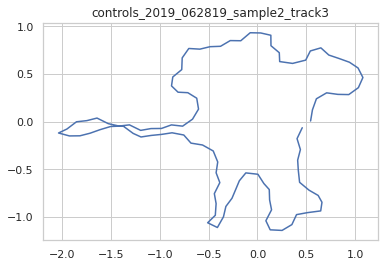

In [ ]:
plt.plot(x,y)
plt.title(image_name)

plt.savefig('/content/figures/pc_cellshape/actual_boundary.eps')

Using PCA to get the raw boundary points back (multiplying score by transpose of eigenvectors and adding mean boundary points) using all the principal components

In [ ]:
x_back=np.dot(stiff_movies[image_name]['Score from PCA'][1],eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num]
y_back=np.dot(stiff_movies[image_name]['Score from PCA'][1],eigenvecs.T)[coord_num:]+model['mdd'][coord_num:]

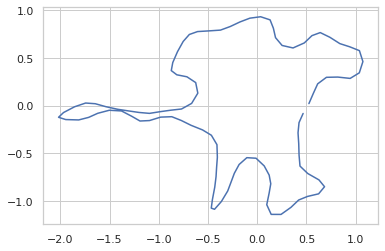

In [ ]:
plt.plot(x_back,y_back)

Using first 10 principal components to reconstruct cell boundary shape

In [ ]:
PC10_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:10]
  PC10_eigenvecs.append(new_vec)
PC10_eigenvecs=np.array(PC10_eigenvecs)

In [ ]:
x_10PC=np.dot(stiff_movies[image_name]['Score from PCA'][1][:10],PC10_eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num]
y_10PC=np.dot(stiff_movies[image_name]['Score from PCA'][1][:10],PC10_eigenvecs.T)[coord_num:]+model['mdd'][coord_num:]

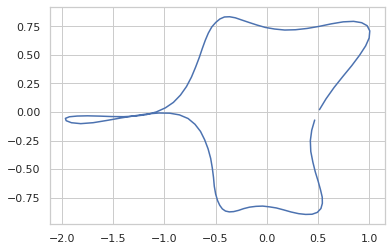

In [ ]:
plt.plot(x_10PC,y_10PC)
plt.savefig('/content/figures/pc_cellshape/10PC_boundary.eps')

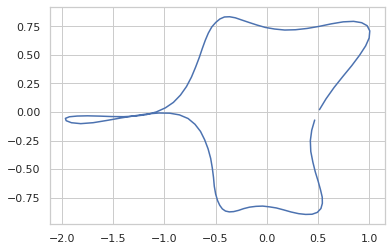

In [ ]:
plt.plot(x_10PC,y_10PC)

Using first 20 principal components to reconstruct cell boundary shape

In [ ]:
PC20_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:20]
  PC20_eigenvecs.append(new_vec)
PC20_eigenvecs=np.array(PC20_eigenvecs)

In [ ]:
x_20PC=np.dot(stiff_movies[image_name]['Score from PCA'][1][:20],PC20_eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num]
y_20PC=np.dot(stiff_movies[image_name]['Score from PCA'][1][:20],PC20_eigenvecs.T)[coord_num:]+model['mdd'][coord_num:]

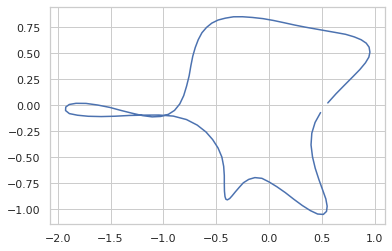

In [ ]:
plt.plot(x_20PC,y_20PC)
plt.savefig('/content/figures/pc_cellshape/20PC_boundary.eps')

Artifically increase first principal component and see what happens

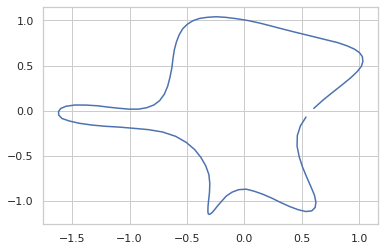

In [ ]:
weight = 2

inc_PC20_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:20]
  new_vec[0]+=weight
  inc_PC20_eigenvecs.append(new_vec)
inc_PC20_eigenvecs=np.array(inc_PC20_eigenvecs)

inc_amt = np.zeros(20)
inc_amt[0]+=weight

inc_pc1=list(stiff_movies[image_name]['Score from PCA'][1][:20] + inc_amt)

x_inc = np.dot(inc_pc1,PC20_eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num]
y_inc = np.dot(inc_pc1,PC20_eigenvecs.T)[coord_num:]+model['mdd'][coord_num:]

plt.plot(x_inc,y_inc)
plt.savefig('/content/figures/pc_cellshape/20PC_boundary_incPC1by2.eps')

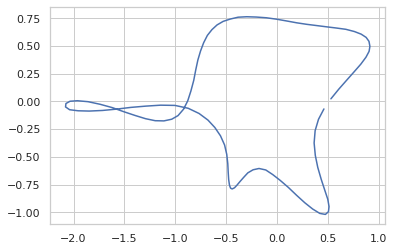

In [ ]:
weight = -1

inc_PC20_eigenvecs = []
for vec in eigenvecs:
  new_vec=vec[:20]
  new_vec[0]+=weight
  inc_PC20_eigenvecs.append(new_vec)
inc_PC20_eigenvecs=np.array(inc_PC20_eigenvecs)

inc_amt = np.zeros(20)
inc_amt[0]+=weight

inc_pc1=list(stiff_movies[image_name]['Score from PCA'][1][:20] + inc_amt)

x_inc = np.dot(inc_pc1,PC20_eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num]
y_inc = np.dot(inc_pc1,PC20_eigenvecs.T)[coord_num:]+model['mdd'][coord_num:]

plt.plot(x_inc,y_inc)
plt.savefig('/content/figures/pc_cellshape/20PC_boundary_decPC1by1.eps')

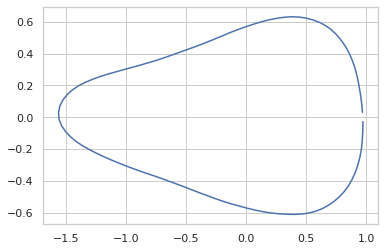

In [ ]:
#plot of averaged boundary points of all cells at all times
plt.plot(model['mdd'][0:coord_num],model['mdd'][coord_num:])

#PC Reconstruction Error

In [ ]:
!gsutil cp gs://cellmbucket/analysis/02212022_controls_controls_4regions_masksbytrack.zip ./

Copying gs://cellmbucket/analysis/02212022_controls_controls_4regions_masksbytrack.zip...
- [1 files][ 38.5 MiB/ 38.5 MiB]                                                
Operation completed over 1 objects/38.5 MiB.                                     


In [ ]:
! unzip /content/02212022_controls_controls_4regions_masksbytrack.zip

Archive:  /content/02212022_controls_controls_4regions_masksbytrack.zip
   creating: soft/
  inflating: soft/052822021_Fascin_KO_sample3_track36_soft_movie33_t92.TIF  
  inflating: soft/05042021_ARPC2_KO_sample6_track27_soft_movie26_t68.TIF  
  inflating: soft/05112021_ARPC2_KO_sample3_track38_soft_movie36_t65.TIF  
  inflating: soft/052822021_Fascin_KO_sample3_track34_soft_movie29_t40.TIF  
  inflating: soft/05112021_ARPC2_KO_sample3_track40_soft_movie39_t7.TIF  
  inflating: soft/controls_2019_062719_sample1_track28_soft_movie24_t4.TIF  
  inflating: soft/031521_control_sample4_track21_soft_movie23_t127.TIF  
  inflating: soft/03122021-JR20P14-control_track44_soft_movie18_t59.TIF  
  inflating: soft/060222021_Fascin_KO_sample3_track34_soft_movie29_t58.TIF  
  inflating: soft/052822021_Fascin_KO_sample3_track34_soft_movie29_t114.TIF  
  inflating: soft/06032020-JR20-control_track44_soft_movie28_t1.TIF  
  inflating: soft/05042021_ARPC2_KO_sample6_track32_soft_movie31_t15.TIF  
  infla

In [ ]:
def PlotPCDiff(orig, PC_recon, PC_num):
  x = np.reshape(orig[0:coord_num], (coord_num,1))
  y = np.reshape(orig[coord_num:], (coord_num,1))

  PC_eigenvecs = []
  for vec in eigenvecs:
    new_vec=vec[:PC_num]
    PC_eigenvecs.append(new_vec)
  PC_eigenvecs=np.array(PC_eigenvecs)

  x_PC = np.reshape(np.dot(PC_recon[:PC_num],PC_eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num], (coord_num,1))
  y_PC = np.reshape(np.dot(PC_recon[:PC_num],PC_eigenvecs.T)[coord_num:]+model['mdd'][coord_num:], (coord_num,1))

  polygon = (np.concatenate((y_PC, x_PC),axis=1)) * 100
  cell = np.concatenate((y, x), axis=1) * 100

  polygon = polygon + np.concatenate((np.ones((coord_num,1))*128,np.ones((coord_num,1))*215),axis=1)
  cell = cell + np.concatenate((np.ones((coord_num,1))*128,np.ones((coord_num,1))*215),axis=1)

  image_shape = (256, 336)
  mask_poly = np.array(polygon2mask(image_shape, polygon),dtype=int) 
  mask_cell = np.array(polygon2mask(image_shape, cell),dtype=int)

  imshow(np.abs(mask_poly-mask_cell))

  return

In [ ]:
def PCDiff(orig, PC_recon, PC_num):
  x = np.reshape(orig[0:coord_num], (coord_num,1))
  y = np.reshape(orig[coord_num:], (coord_num,1))

  PC_eigenvecs = []
  for vec in eigenvecs:
    new_vec=vec[:PC_num]
    PC_eigenvecs.append(new_vec)
  PC_eigenvecs=np.array(PC_eigenvecs)

  x_PC = np.reshape(np.dot(PC_recon[:PC_num],PC_eigenvecs.T)[0:coord_num]+model['mdd'][0:coord_num], (coord_num,1))
  y_PC = np.reshape(np.dot(PC_recon[:PC_num],PC_eigenvecs.T)[coord_num:]+model['mdd'][coord_num:], (coord_num,1))

  polygon = (np.concatenate((y_PC, x_PC),axis=1)) * 100
  cell = np.concatenate((y, x), axis=1) * 100

  polygon = polygon + np.concatenate((np.ones((coord_num,1))*128,np.ones((coord_num,1))*215),axis=1)
  cell = cell + np.concatenate((np.ones((coord_num,1))*128,np.ones((coord_num,1))*215),axis=1)

  image_shape = (256, 336)
  mask_poly = np.array(polygon2mask(image_shape, polygon),dtype=int) 
  mask_cell = np.array(polygon2mask(image_shape, cell),dtype=int)


  return np.sum(np.abs(mask_poly-mask_cell))

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


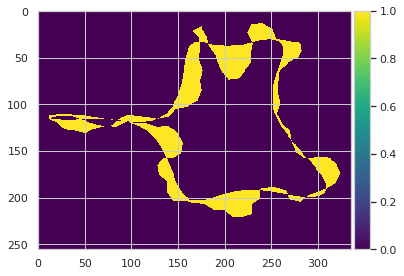

In [ ]:
PlotPCDiff(stiff_movies[image_name]['Boundary coordinates'][1], stiff_movies[image_name]['Score from PCA'][1], 10)
plt.savefig('/content/figures/pc_cellshape/PCError10')

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


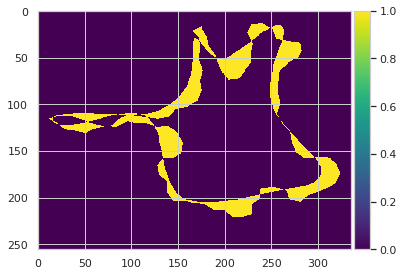

In [ ]:
PlotPCDiff(stiff_movies[image_name]['Boundary coordinates'][1], stiff_movies[image_name]['Score from PCA'][1], 20)
plt.savefig('/content/figures/pc_cellshape/PCError20')

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


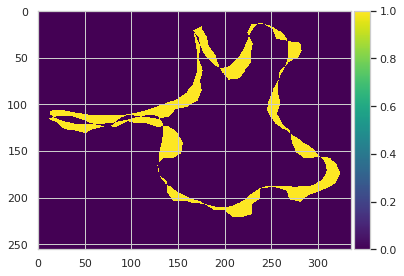

In [ ]:
PlotPCDiff(stiff_movies[image_name]['Boundary coordinates'][1], stiff_movies[image_name]['Score from PCA'][1], 30)
plt.savefig('/content/figures/pc_cellshape/PCError30')

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


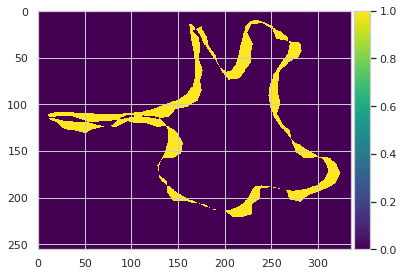

In [ ]:
PlotPCDiff(stiff_movies[image_name]['Boundary coordinates'][1], stiff_movies[image_name]['Score from PCA'][1], 40)
plt.savefig('/content/figures/pc_cellshape/PCError40')

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


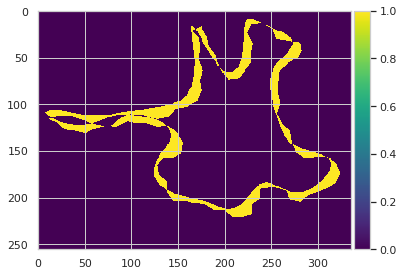

In [ ]:
PlotPCDiff(stiff_movies[image_name]['Boundary coordinates'][1], stiff_movies[image_name]['Score from PCA'][1], 50)
plt.savefig('/content/figures/pc_cellshape/PCError50')

In [ ]:
counter=0
err=0
for movie_name in stiff_movies:
  for frame in range(1,len(stiff_movies[movie_name])+1):
    err += PCDiff(stiff_movies[movie_name]['Boundary coordinates'][frame], stiff_movies[movie_name]['Score from PCA'][frame], 10)
    counter += 1

In [ ]:
PC10err = err/counter

In [ ]:
counter=0
err=0
for movie_name in stiff_movies:
  for frame in range(1,len(stiff_movies[movie_name])+1):
    err += PCDiff(stiff_movies[movie_name]['Boundary coordinates'][frame], stiff_movies[movie_name]['Score from PCA'][frame], 20)
    counter += 1

In [ ]:
PC20err = err/counter

In [ ]:
counter=0
err=0
for movie_name in stiff_movies:
  for frame in range(1,len(stiff_movies[movie_name])+1):
    err += PCDiff(stiff_movies[movie_name]['Boundary coordinates'][frame], stiff_movies[movie_name]['Score from PCA'][frame], 30)
    counter += 1

In [ ]:
PC30err = err/counter

In [ ]:
counter=0
err=0
for movie_name in stiff_movies:
  for frame in range(1,len(stiff_movies[movie_name])+1):
    err += PCDiff(stiff_movies[movie_name]['Boundary coordinates'][frame], stiff_movies[movie_name]['Score from PCA'][frame], 40)
    counter += 1

In [ ]:
PC40err = err/counter

In [ ]:
counter=0
err=0
for movie_name in stiff_movies:
  for frame in range(1,len(stiff_movies[movie_name])+1):
    err += PCDiff(stiff_movies[movie_name]['Boundary coordinates'][frame], stiff_movies[movie_name]['Score from PCA'][frame], 50)
    counter += 1

In [ ]:
PC50err = err/counter

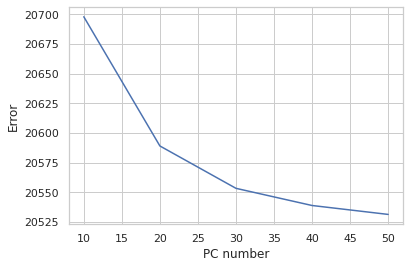

In [ ]:
PC_numbers = [10, 20, 30, 40, 50]

plt.plot(PC_numbers, [PC10err, PC20err, PC30err, PC40err, PC50err])
plt.xlabel('PC number')
plt.ylabel('Error')
plt.savefig('/content/figures/pc_cellshape/PCReconstructionErr.eps')

# Plot individual eigenvectors (PCs)

In [139]:
def plot_PC(PCnum, fig, axs):
  PC = eigenvecs[:,(PCnum-1)]
  axs[i-1].plot(PC[0:coord_num]+model['mdd'][0:coord_num], PC[coord_num:]+model['mdd'][coord_num:])
  axs[i-1].set_xlabel('x')
  axs[i-1].set_ylabel('y')
  axs[i-1].set_title('PC {}'.format(i))

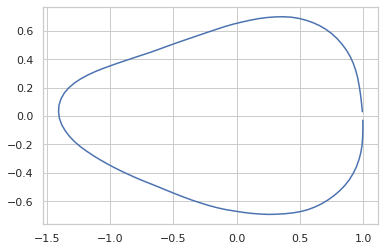

In [140]:
PC = eigenvecs[:,(1-1)]
plt.plot(PC[0:coord_num]+model['mdd'][0:coord_num], PC[coord_num:]+model['mdd'][coord_num:])

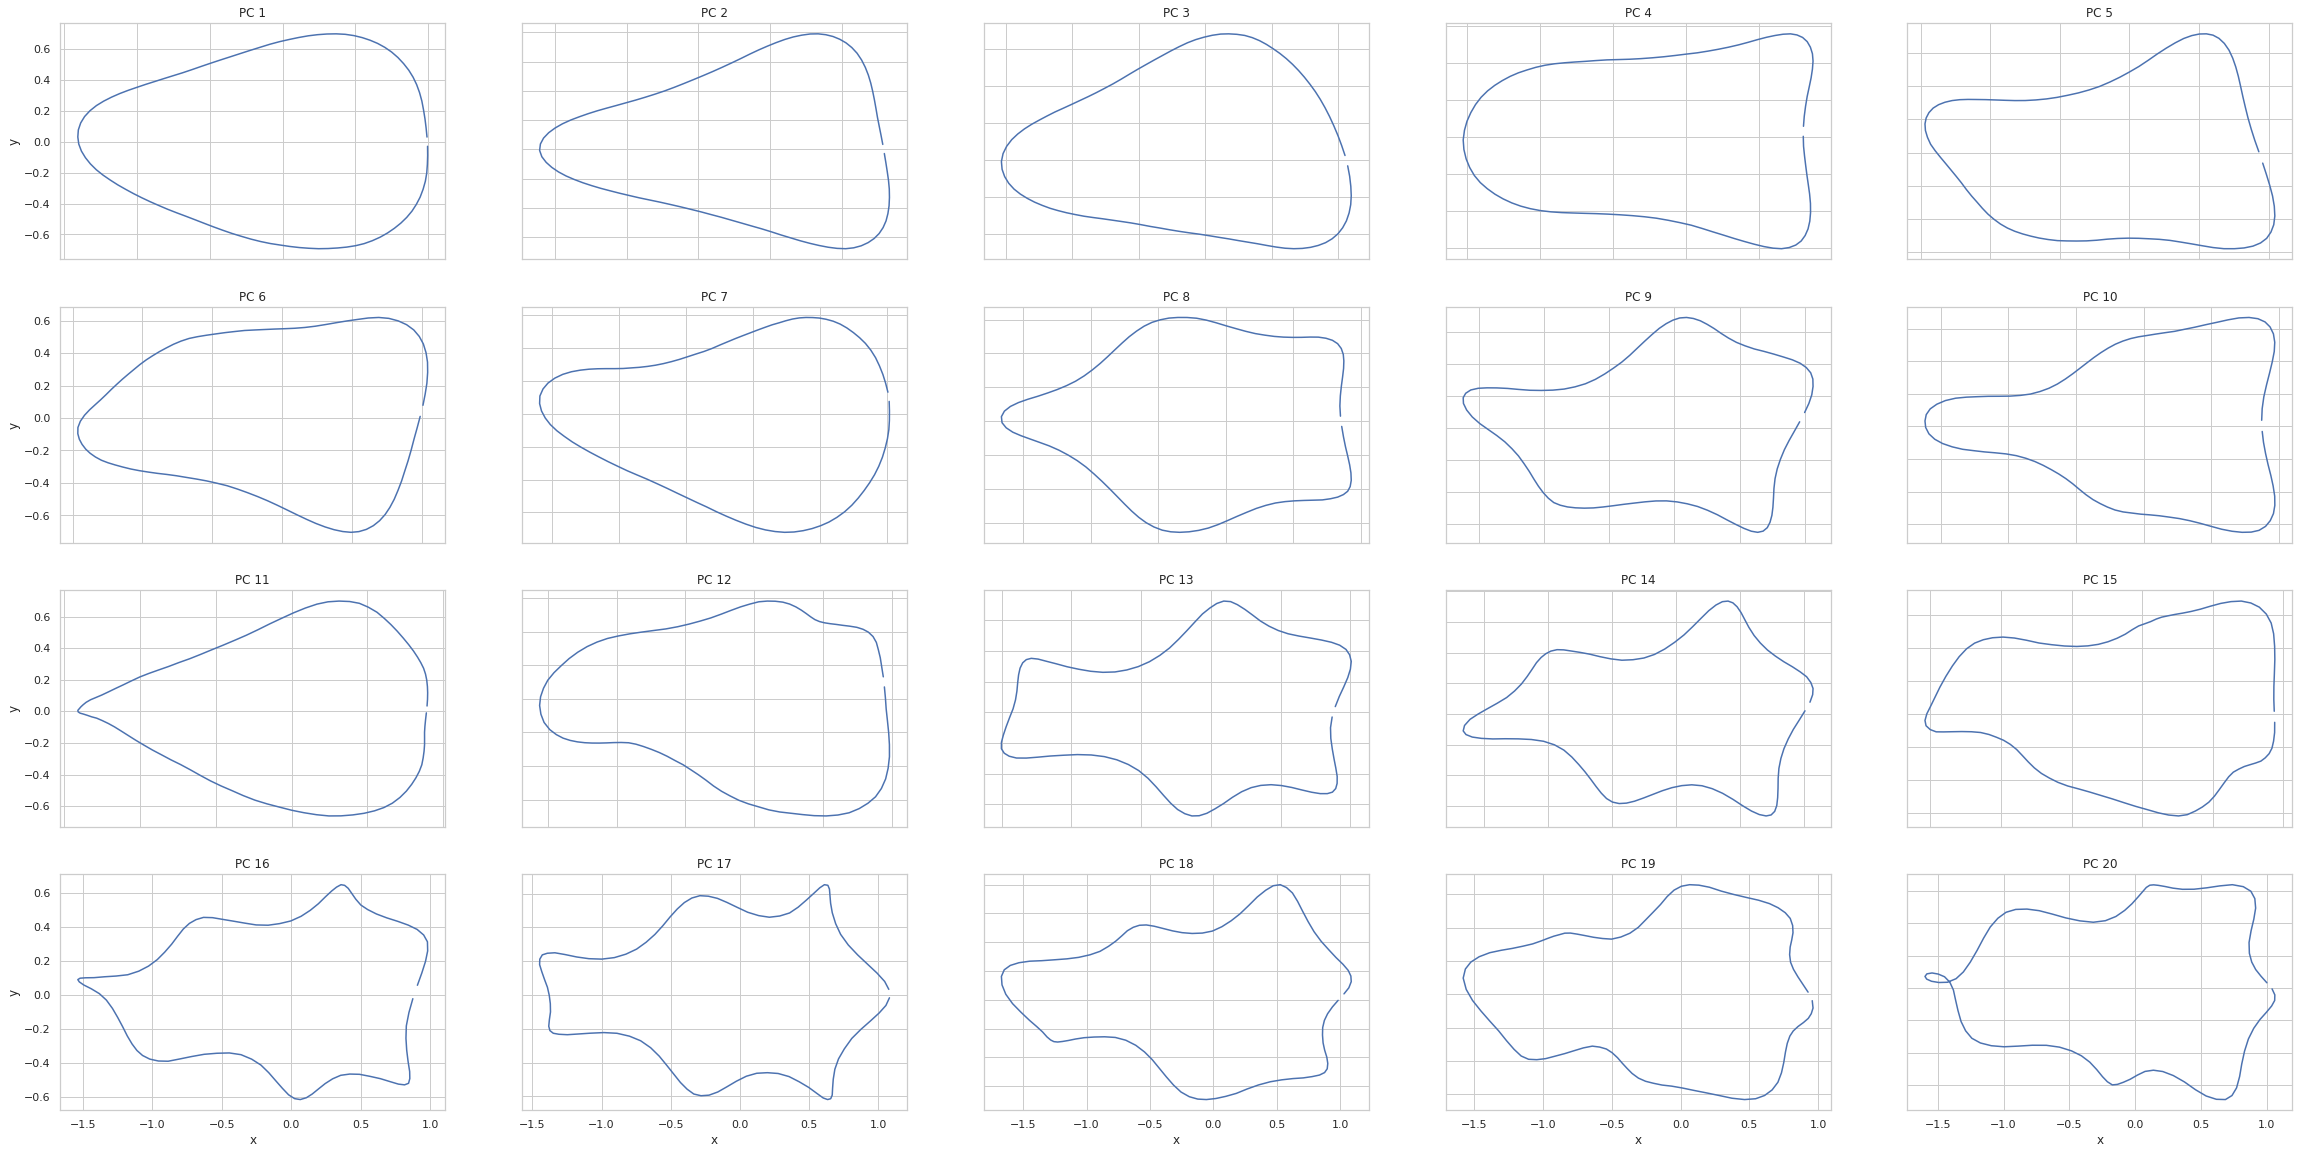

In [141]:
fig, axs = plt.subplots(4, 5, figsize=(40,20))
axs = axs.ravel()

for i in range(1, 21):
  plot_PC(i, fig, axs)

for ax in axs.flat:
    ax.label_outer()

fig.savefig('figures/PCshapes.eps')

# Varying PC Weights

In [142]:
def plot_PC_vary_weight(PCnum, fig, axs, weights):
  PC = eigenvecs[:,(PCnum-1)]
  # norm is a class which, when called, can normalize data into the
  # [0.0, 1.0] interval.
  norm = matplotlib.colors.Normalize(vmin=np.min(weights),vmax=np.max(weights))

  # choose a colormap
  c_m = matplotlib.cm.viridis
  # create a ScalarMappable and initialize a data structure
  s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm)
  s_m.set_array([])

  for weight in weights:
    x_inc = np.dot(weight,PC)[0:coord_num]+model['mdd'][0:coord_num]
    y_inc = np.dot(weight,PC)[coord_num:]+model['mdd'][coord_num:]
    x_inc = x_inc - np.mean(x_inc)
    y_inc = y_inc - np.mean(y_inc)
    #axs[i-1].plot(x_inc, y_inc, label="weight={}".format(weight))
    axs[i-1].plot(x_inc, y_inc, color=s_m.to_rgba(weight))
    axs[i-1].set_xlabel('x')
    axs[i-1].set_ylabel('y')
    axs[i-1].set_title('PC {}'.format(i))

  #handles, labels = axs[i-1].get_legend_handles_labels()
  #fig.legend(handles, labels, loc='center left')

  # return the scalar mappable made
  return s_m

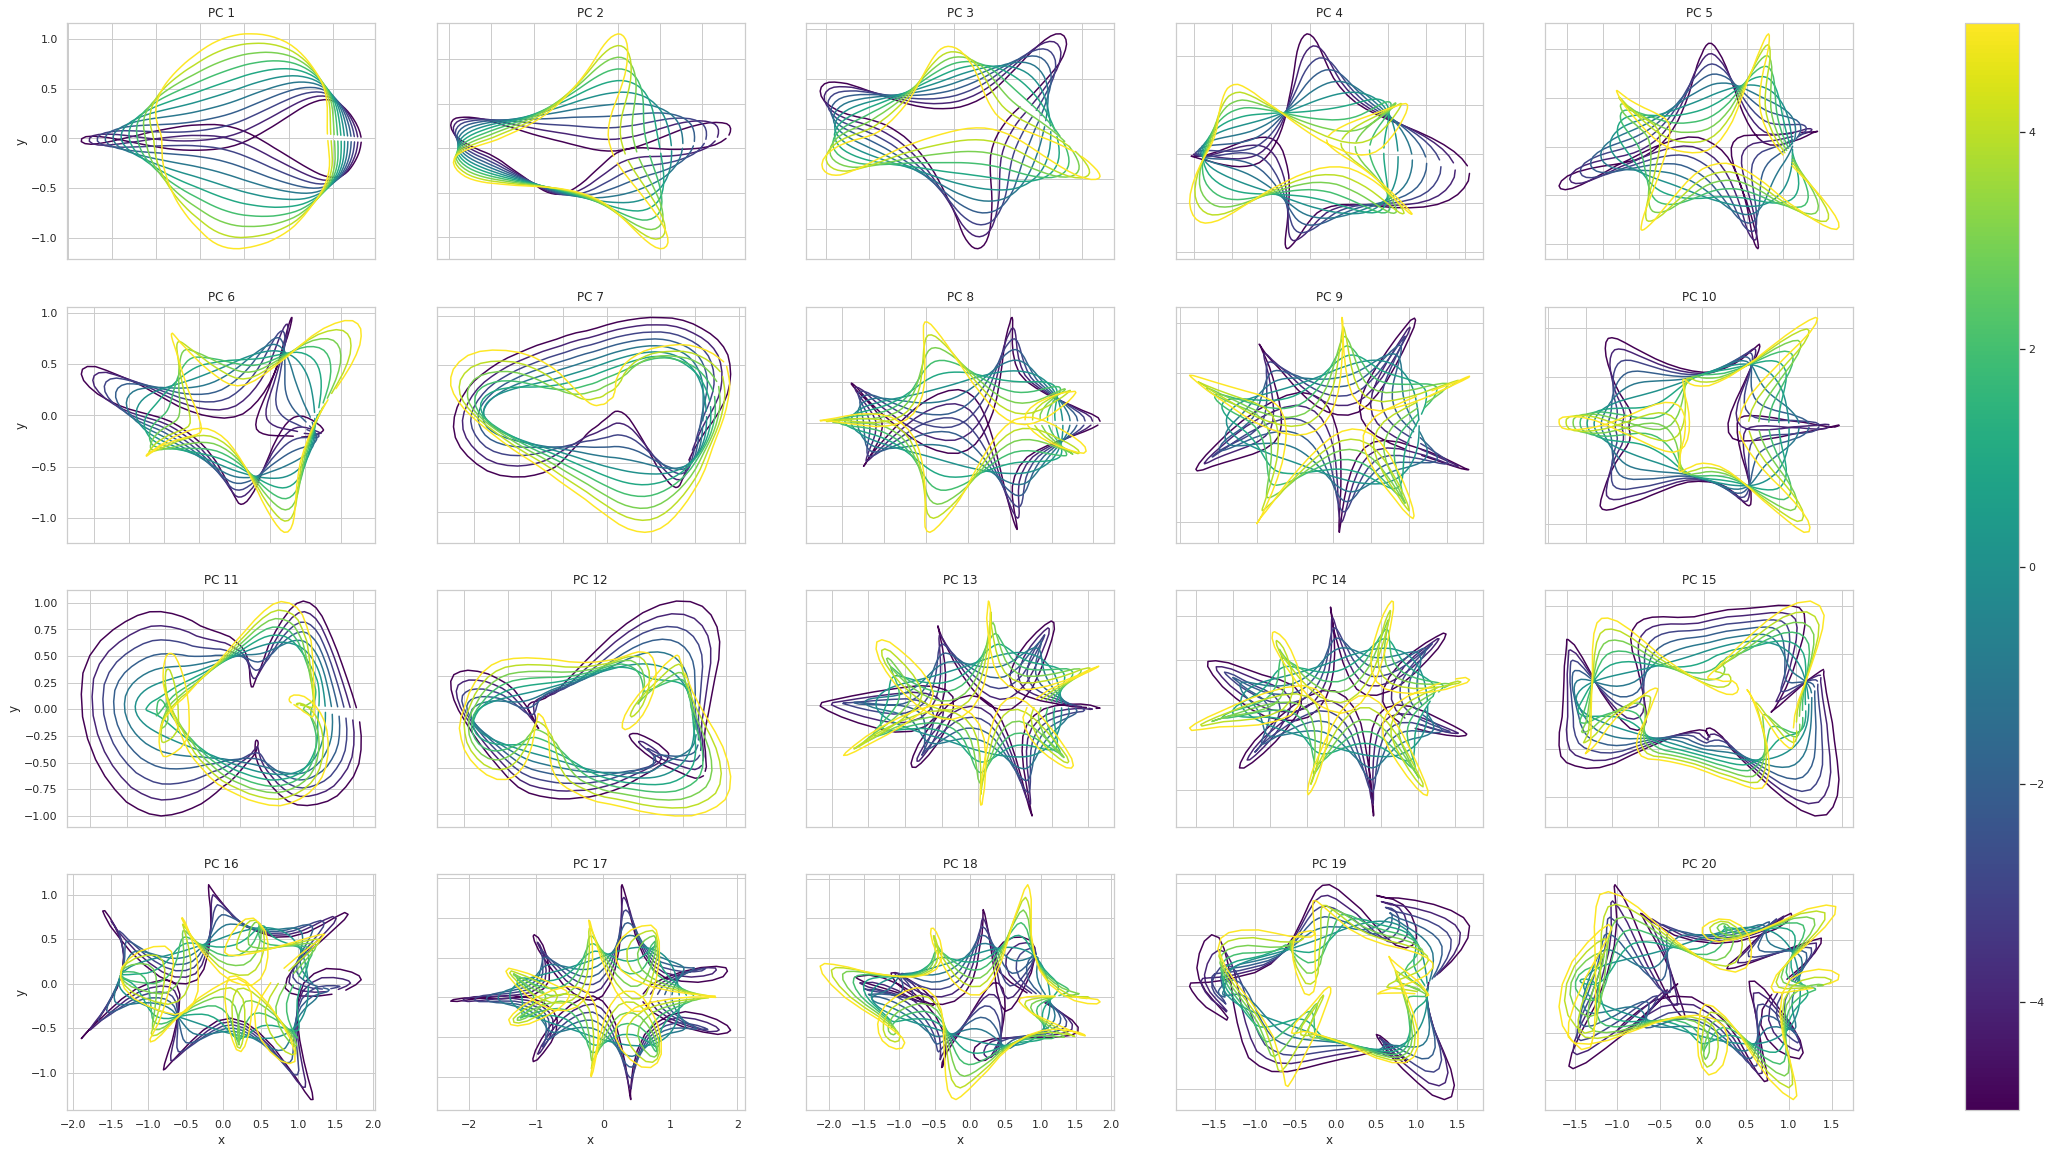

In [143]:
fig, axs = plt.subplots(4, 5, figsize=(40,20))
axs = axs.ravel()

weights = np.arange(-5,6)

for i in range(1, 21):
  s_m=plot_PC_vary_weight(i, fig, axs, weights)

for ax in axs.flat:
    ax.label_outer()

plt.colorbar(s_m, ax=axs.tolist())

fig.savefig('figures/PCshapes_varyweights.eps')

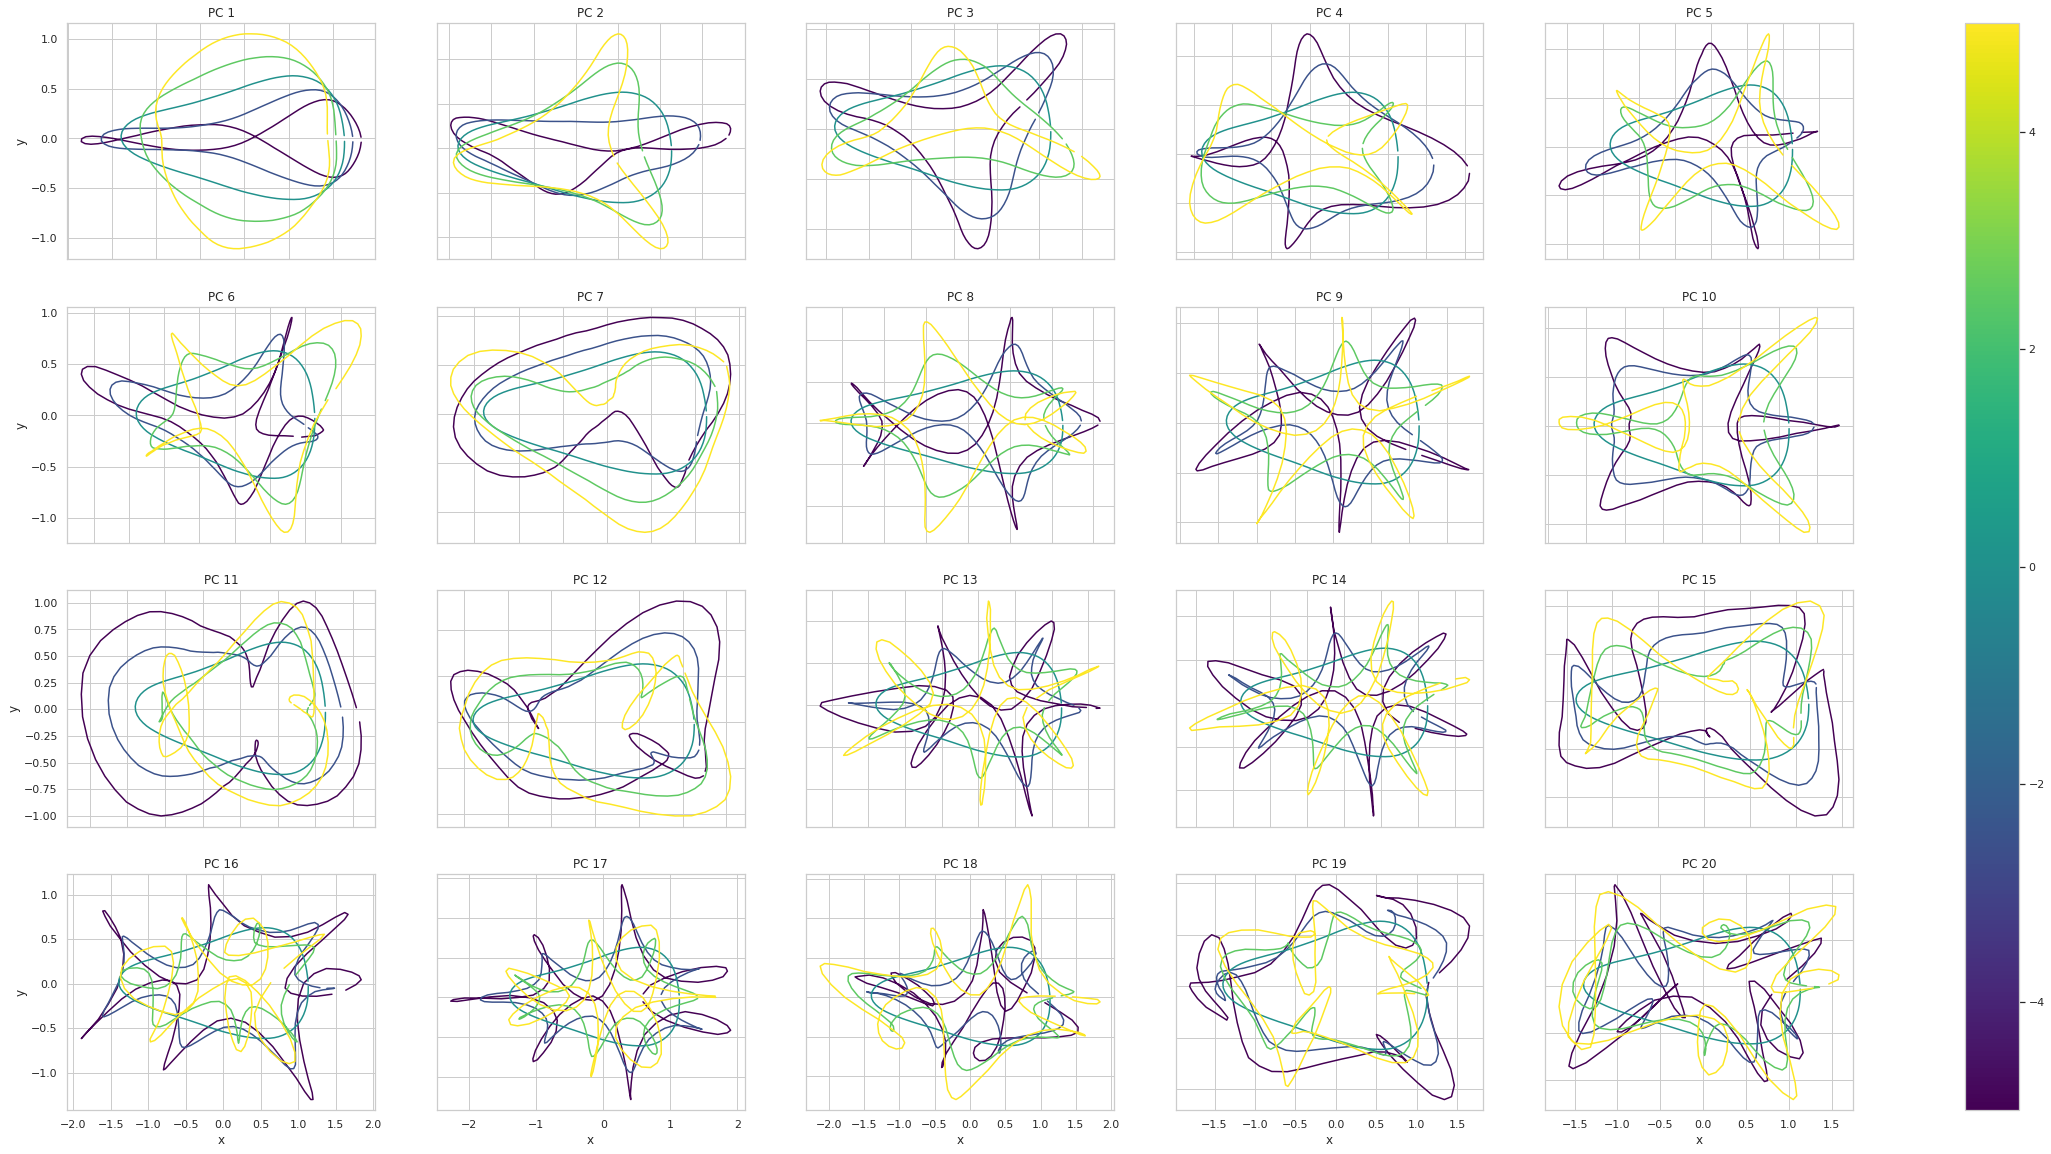

In [144]:
fig, axs = plt.subplots(4, 5, figsize=(40,20))
axs = axs.ravel()

weights = np.linspace(-5,5,5)

for i in range(1, 21):
  s_m=plot_PC_vary_weight(i, fig, axs, weights)

for ax in axs.flat:
    ax.label_outer()

plt.colorbar(s_m, ax=axs.tolist())

fig.savefig('figures/PCshapes_varyweights_5weights.eps')

# Saving figures

In [145]:
folder_name = 'figures_03092022_longtracks100'

In [146]:
!zip {folder_name}.zip -r figures

  adding: figures/ (stored 0%)
  adding: figures/stiff_pc1_overtime.eps (deflated 66%)
  adding: figures/pc2vspc1/ (stored 0%)
  adding: figures/pc2vspc1/stiffregion_avg_absskew.eps (deflated 78%)
  adding: figures/pc2vspc1/stiffregion_absskew.eps (deflated 89%)
  adding: figures/boxplot_bypc.eps (deflated 69%)
  adding: figures/PCshapes.eps (deflated 70%)
  adding: figures/boxplot_byavgpc.eps (deflated 68%)
  adding: figures/PCshapes_varyweights_5weights.eps (deflated 81%)
  adding: figures/pc4vspc3/ (stored 0%)
  adding: figures/pc4vspc3/stiffregion_avg_absskew.eps (deflated 77%)
  adding: figures/pc4vspc3/stiffregion_absskew.eps (deflated 89%)
  adding: figures/histograms/ (stored 0%)
  adding: figures/histograms/avgpc.eps (deflated 80%)
  adding: figures/histograms/pc.eps (deflated 79%)
  adding: figures/stiff_sm_overtime.eps (deflated 81%)
  adding: figures/corr_plots/ (stored 0%)
  adding: figures/corr_plots/volcano_plot/ (stored 0%)
  adding: figures/corr_plots/volcano_plot/Shap

In [147]:
!gsutil cp {folder_name}.zip gs://{vam_mod_analysis_folder}

Copying file://figures_03092022_longtracks100.zip [Content-Type=application/zip]...
/ [1 files][742.2 KiB/742.2 KiB]                                                
Operation completed over 1 objects/742.2 KiB.                                    


#Irrelevant Shape Metrics

##protr_angle

###Pearson Correlation

In [ ]:
stiff_pearson_pc_protr_angle = {}
for i in range(0,pcnum):
  pear_r, pval = pearson_corr(stiff_movies, stiff_tracks,i+1,'protr_angle')
  stiff_pearson_pc_protr_angle['PC{}'.format(i+1)] = [pear_r, pval]
  print('Pearson correlation for stiff region PC{} and protr_angle is '.format(i+1), pear_r, 'p-value is ', pval)

stiff_pearson_pc_protr_angle = pd.DataFrame.from_dict(stiff_pearson_pc_protr_angle, orient='index', columns=['r-value', 'p-value'])

Pearson correlation for stiff region PC1 and protr_angle is  0.04401815371821756 p-value is  0.000170947598233652
Pearson correlation for stiff region PC2 and protr_angle is  0.04324143630829743 p-value is  0.00022241077484809287
Pearson correlation for stiff region PC3 and protr_angle is  -0.013892308976444343 p-value is  0.23575089755927017
Pearson correlation for stiff region PC4 and protr_angle is  -0.018319910946731466 p-value is  0.11790797803235094
Pearson correlation for stiff region PC5 and protr_angle is  0.004294571258226737 p-value is  0.7139807429313203
Pearson correlation for stiff region PC6 and protr_angle is  0.005005838616048235 p-value is  0.6692204909402656
Pearson correlation for stiff region PC7 and protr_angle is  -0.011215200741325563 p-value is  0.33847957322410543
Pearson correlation for stiff region PC8 and protr_angle is  0.0018559773822653793 p-value is  0.874145079884828
Pearson correlation for stiff region PC9 and protr_angle is  0.008635006794133461 p-va

In [ ]:
stiff_pearson_avg_pc_protr_angle = {}
for i in range(0,pcnum):
  pear_r, pval = pearson_corr_withaverages(stiff_movies, stiff_tracks,i+1,'protr_angle')
  stiff_pearson_avg_pc_protr_angle['PC{}'.format(i+1)] = [pear_r, pval]
  print('Pearson correlation for stiff region cell averaged PC{} and protr_angle is '.format(i+1), pear_r, 'p-value is ', pval)

stiff_pearson_avg_pc_protr_angle = pd.DataFrame.from_dict(stiff_pearson_avg_pc_protr_angle, orient='index', columns=['r-value', 'p-value'])

Pearson correlation for stiff region cell averaged PC1 and protr_angle is  0.029547991687112956 p-value is  0.7089595459629219
Pearson correlation for stiff region cell averaged PC2 and protr_angle is  0.130655395417318 p-value is  0.09747783321260943
Pearson correlation for stiff region cell averaged PC3 and protr_angle is  -0.08332199831788854 p-value is  0.29181976105758517
Pearson correlation for stiff region cell averaged PC4 and protr_angle is  -0.019580032048399743 p-value is  0.8046706185191255
Pearson correlation for stiff region cell averaged PC5 and protr_angle is  0.01714683085041049 p-value is  0.8285438869530394
Pearson correlation for stiff region cell averaged PC6 and protr_angle is  -0.05095537385802976 p-value is  0.5196063051268139
Pearson correlation for stiff region cell averaged PC7 and protr_angle is  -0.03986827597631677 p-value is  0.6144643048238927
Pearson correlation for stiff region cell averaged PC8 and protr_angle is  -0.1506296731143264 p-value is  0.055

###Spearman Correlation

In [ ]:
stiff_spearman_pc_protr_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr(stiff_movies, stiff_tracks,i+1,'protr_angle')
  stiff_spearman_pc_protr_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation for stiff region PC{} and protr_angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_pc_protr_angle = pd.DataFrame.from_dict(stiff_spearman_pc_protr_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation for stiff region PC1 and protr_angle is  0.03967435302554168 p-value is  0.0007058964008227054
Spearman correlation for stiff region PC2 and protr_angle is  0.04652318460558423 p-value is  7.109272384421763e-05
Spearman correlation for stiff region PC3 and protr_angle is  -0.015408799795076417 p-value is  0.18847031430661992
Spearman correlation for stiff region PC4 and protr_angle is  -0.02455255381674258 p-value is  0.036107488567198656
Spearman correlation for stiff region PC5 and protr_angle is  0.009274252784763471 p-value is  0.4286443967525613
Spearman correlation for stiff region PC6 and protr_angle is  0.0060947753971458156 p-value is  0.602956361232373
Spearman correlation for stiff region PC7 and protr_angle is  -0.008113350077302808 p-value is  0.4886657800761439
Spearman correlation for stiff region PC8 and protr_angle is  0.006080515273612385 p-value is  0.603804821459623
Spearman correlation for stiff region PC9 and protr_angle is  -0.000398410965275

In [ ]:
stiff_spearman_avg_pc_protr_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_withaverages(stiff_movies, stiff_tracks,i+1,'protr_angle')
  stiff_spearman_avg_pc_protr_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation for stiff region cell averaged PC{} and protr_angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_avg_pc_protr_angle = pd.DataFrame.from_dict(stiff_spearman_avg_pc_protr_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation for stiff region cell averaged PC1 and protr_angle is  0.04074878521397592 p-value is  0.6066612713242339
Spearman correlation for stiff region cell averaged PC2 and protr_angle is  0.07646906900041069 p-value is  0.33345775696746427
Spearman correlation for stiff region cell averaged PC3 and protr_angle is  -0.06558503784430698 p-value is  0.40699665399722396
Spearman correlation for stiff region cell averaged PC4 and protr_angle is  -0.048542045074453706 p-value is  0.5396007483221905
Spearman correlation for stiff region cell averaged PC5 and protr_angle is  0.006682558029583903 p-value is  0.9327404847897317
Spearman correlation for stiff region cell averaged PC6 and protr_angle is  -0.05910429730114979 p-value is  0.4550013660862732
Spearman correlation for stiff region cell averaged PC7 and protr_angle is  -0.0457166002644797 p-value is  0.5634844587304969
Spearman correlation for stiff region cell averaged PC8 and protr_angle is  -0.11494987728650038 p-value

##mean_protr_angle

###Pearson Correlation

In [ ]:
stiff_pearson_pc_mean_protr_angle = {}
for i in range(0,pcnum):
  pear_r, pval = pearson_corr(stiff_movies, stiff_tracks,i+1,'mean_protr_angle')
  stiff_pearson_pc_pc_mean_protr_angle['PC{}'.format(i+1)] = [pear_r, pval]
  print('Pearson correlation for stiff region PC{} and mean_protr_angle is '.format(i+1), pear_r, 'p-value is ', pval)

stiff_pearson_pc_mean_protr_angle = pd.DataFrame.from_dict(stiff_pearson_pc_mean_protr_angle, orient='index', columns=['r-value', 'p-value'])

Pearson correlation r value for all regions cell averaged PC1 and mean_protr_angle is  0.0024198202549076623 p-value is  0.9690255428744251
Pearson correlation r value for all regions cell averaged PC2 and mean_protr_angle is  0.045269147015135056 p-value is  0.46734932331505247
Pearson correlation r value for all regions cell averaged PC3 and mean_protr_angle is  -0.0665817851287109 p-value is  0.28479336679711703
Pearson correlation r value for all regions cell averaged PC4 and mean_protr_angle is  0.028936043727422228 p-value is  0.6423405569704143
Pearson correlation r value for all regions cell averaged PC5 and mean_protr_angle is  -0.044777197569454946 p-value is  0.47220723439668977
Pearson correlation r value for all regions cell averaged PC6 and mean_protr_angle is  -0.014083661667101116 p-value is  0.8211942504262111
Pearson correlation r value for all regions cell averaged PC7 and mean_protr_angle is  -0.05110735014956193 p-value is  0.4118473734910077
Pearson correlation r 

In [ ]:
stiff_pearson_avg_pc_mean_protr_angle = {}
for i in range(0,pcnum):
  pear_r, pval = pearson_corr_withaverages(stiff_movies, stiff_tracks,i+1,'mean_protr_angle')
  stiff_pearson_avg_pc_mean_protr_angle['PC{}'.format(i+1)] = [pear_r, pval]
  print('Pearson correlation for stiff region cell averaged PC{} and mean_protr_angle is '.format(i+1), pear_r, 'p-value is ', pval)

stiff_pearson_avg_pc_mean_protr_angle = pd.DataFrame.from_dict(stiff_pearson_avg_pc_mean_protr_angle, orient='index', columns=['r-value', 'p-value'])

Pearson correlation for all regions PC1 and mean_protr_angle is  0.014849406801288732 p-value is  0.10329238281990921
Pearson correlation for all regions PC2 and mean_protr_angle is  0.025242071553622337 p-value is  0.005613487886130328
Pearson correlation for all regions PC3 and mean_protr_angle is  -0.012272540599290596 p-value is  0.17818279004994747
Pearson correlation for all regions PC4 and mean_protr_angle is  0.006828157693224552 p-value is  0.4538147803578004
Pearson correlation for all regions PC5 and mean_protr_angle is  -0.004121114485108339 p-value is  0.6511999116342998
Pearson correlation for all regions PC6 and mean_protr_angle is  -0.001225688216557233 p-value is  0.8930385716277687
Pearson correlation for all regions PC7 and mean_protr_angle is  -0.009873336948729725 p-value is  0.27874188770469843
Pearson correlation for all regions PC8 and mean_protr_angle is  0.001864667360867264 p-value is  0.8379177289283709
Pearson correlation for all regions PC9 and mean_protr_

###Spearman Correlation

In [ ]:
stiff_spearman_pc_mean_protr_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr(stiff_movies, stiff_tracks,i+1,'mean_protr_angle')
  stiff_spearman_pc_mean_protr_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation for stiff region PC{} and mean_protr_angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_pc_mean_protr_angle = pd.DataFrame.from_dict(stiff_spearman_pc_mean_protr_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for all regions cell averaged PC1 and mean_protr_angle is  -0.00706724155000017 p-value is  0.9097069537891445
Spearman correlation r value for all regions cell averaged PC2 and mean_protr_angle is  0.025776894742411984 p-value is  0.6790894397168316
Spearman correlation r value for all regions cell averaged PC3 and mean_protr_angle is  -0.0821639373363511 p-value is  0.18660002430390774
Spearman correlation r value for all regions cell averaged PC4 and mean_protr_angle is  0.007267290025910714 p-value is  0.9071624186518403
Spearman correlation r value for all regions cell averaged PC5 and mean_protr_angle is  -0.022916133260960845 p-value is  0.7130377220344368
Spearman correlation r value for all regions cell averaged PC6 and mean_protr_angle is  -0.019165736407115715 p-value is  0.7584039104449997
Spearman correlation r value for all regions cell averaged PC7 and mean_protr_angle is  -0.048837772975704005 p-value is  0.4329467664041161
Spearman correlat

In [ ]:
stiff_spearman_avg_pc_mean_protr_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_withaverages(stiff_movies, stiff_tracks,i+1,'mean_protr_angle')
  stiff_spearman_avg_pc_mean_protr_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation for stiff region cell averaged PC{} and mean_protr_angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_avg_pc_mean_protr_angle = pd.DataFrame.from_dict(stiff_spearman_avg_pc_mean_protr_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation for all regions PC1 and mean_protr_angle is  0.013262055720152844 p-value is  0.14568690437257567
Spearman correlation for all regions PC2 and mean_protr_angle is  0.023449333529804082 p-value is  0.010088256106787822
Spearman correlation for all regions PC3 and mean_protr_angle is  -0.018277438228167398 p-value is  0.04493775721601555
Spearman correlation for all regions PC4 and mean_protr_angle is  0.0019384312181000263 p-value is  0.8316001819608039
Spearman correlation for all regions PC5 and mean_protr_angle is  -0.0058548014854156285 p-value is  0.5206860949293926
Spearman correlation for all regions PC6 and mean_protr_angle is  -0.0006958478069494415 p-value is  0.93915193347399
Spearman correlation for all regions PC7 and mean_protr_angle is  -0.00975120955287989 p-value is  0.28473124988567966
Spearman correlation for all regions PC8 and mean_protr_angle is  0.004200533917783685 p-value is  0.6449360363755837
Spearman correlation for all regions PC9 and me

##retr_angle

###Pearson Correlation

In [ ]:
stiff_pearson_pc_retr_angle = {}
for i in range(0,pcnum):
  pear_r, pval = pearson_corr(stiff_movies, stiff_tracks,i+1,'retr_angle')
  stiff_pearson_pc_retr_angle['PC{}'.format(i+1)] = [pear_r, pval]
  print('Pearson correlation for stiff region PC{} and retr_angle is '.format(i+1), pear_r, 'p-value is ', pval)

stiff_pearson_pc_retr_angle = pd.DataFrame.from_dict(stiff_pearson_pc_retr_angle, orient='index', columns=['r-value', 'p-value'])

Pearson correlation r value for all regions cell averaged PC1 and retr_angle is  0.10647305216619683 p-value is  0.08663385007495267
Pearson correlation r value for all regions cell averaged PC2 and retr_angle is  -0.012662309249031835 p-value is  0.8389803023771261
Pearson correlation r value for all regions cell averaged PC3 and retr_angle is  0.000815488149447552 p-value is  0.9895591845523729
Pearson correlation r value for all regions cell averaged PC4 and retr_angle is  0.0006088892861527128 p-value is  0.9922042024906591
Pearson correlation r value for all regions cell averaged PC5 and retr_angle is  -0.04237108363996775 p-value is  0.49636087435837006
Pearson correlation r value for all regions cell averaged PC6 and retr_angle is  0.011354386046551 p-value is  0.8554197439707522
Pearson correlation r value for all regions cell averaged PC7 and retr_angle is  -0.05350028041360643 p-value is  0.3902715913302541
Pearson correlation r value for all regions cell averaged PC8 and ret

In [ ]:
stiff_pearson_avg_pc_retr_angle = {}
for i in range(0,pcnum):
  pear_r, pval = pearson_corr_withaverages(stiff_movies, stiff_tracks,i+1,'retr_angle')
  stiff_pearson_avg_pc_retr_angle['PC{}'.format(i+1)] = [pear_r, pval]
  print('Pearson correlation for stiff region cell averaged PC{} and retr_angle is '.format(i+1), pear_r, 'p-value is ', pval)

stiff_pearson_avg_pc_retr_angle = pd.DataFrame.from_dict(stiff_pearson_avg_pc_retr_angle, orient='index', columns=['r-value', 'p-value'])

Pearson correlation for all regions PC1 and retr_angle is  0.0234947697581519 p-value is  0.009940763818608117
Pearson correlation for all regions PC2 and retr_angle is  0.00963809627564562 p-value is  0.2903356146764407
Pearson correlation for all regions PC3 and retr_angle is  -0.01231453130633808 p-value is  0.17668439863787397
Pearson correlation for all regions PC4 and retr_angle is  0.007318821911426332 p-value is  0.42201372087789446
Pearson correlation for all regions PC5 and retr_angle is  -0.003560953131779068 p-value is  0.6960480654892981
Pearson correlation for all regions PC6 and retr_angle is  0.009607349384304645 p-value is  0.2918772897790691
Pearson correlation for all regions PC7 and retr_angle is  -0.002249384772452183 p-value is  0.8050844665564371
Pearson correlation for all regions PC8 and retr_angle is  0.011026909807376556 p-value is  0.22637113496482283
Pearson correlation for all regions PC9 and retr_angle is  -0.0009720574177853726 p-value is  0.915073813861

###Spearman Correlation

In [ ]:
stiff_spearman_pc_retr_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr(stiff_movies, stiff_tracks,i+1,'retr_angle')
  stiff_spearman_pc_retr_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation for stiff region PC{} and retr_angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_pc_retr_angle = pd.DataFrame.from_dict(stiff_spearman_pc_retr_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for all regions cell averaged PC1 and retr_angle is  0.06308354584216652 p-value is  0.310916875833801
Spearman correlation r value for all regions cell averaged PC2 and retr_angle is  -0.04303636717429821 p-value is  0.4896176377794844
Spearman correlation r value for all regions cell averaged PC3 and retr_angle is  -0.0005837592044488596 p-value is  0.9925259411273846
Spearman correlation r value for all regions cell averaged PC4 and retr_angle is  0.02258431223948465 p-value is  0.7170137862302353
Spearman correlation r value for all regions cell averaged PC5 and retr_angle is  -0.04275848413779448 p-value is  0.49242825139447644
Spearman correlation r value for all regions cell averaged PC6 and retr_angle is  -0.0419528281597247 p-value is  0.5006253379554417
Spearman correlation r value for all regions cell averaged PC7 and retr_angle is  -0.04615794270966684 p-value is  0.4586428872527938
Spearman correlation r value for all regions cell averaged PC8 

In [ ]:
stiff_spearman_avg_pc_retr_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_withaverages(stiff_movies, stiff_tracks,i+1,'retr_angle')
  stiff_spearman_avg_pc_retr_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation for stiff region cell averaged PC{} and retr_angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_avg_pc_retr_angle = pd.DataFrame.from_dict(stiff_spearman_avg_pc_retr_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation for all regions PC1 and retr_angle is  0.018637045206750014 p-value is  0.04087643331201554
Spearman correlation for all regions PC2 and retr_angle is  0.0082404076086693 p-value is  0.3659736513377021
Spearman correlation for all regions PC3 and retr_angle is  -0.014998448259732549 p-value is  0.0998628876403342
Spearman correlation for all regions PC4 and retr_angle is  0.0011830066054842752 p-value is  0.8967377392698754
Spearman correlation for all regions PC5 and retr_angle is  -0.005395949529112678 p-value is  0.5538675641693078
Spearman correlation for all regions PC6 and retr_angle is  0.015023093879839636 p-value is  0.09930692918657923
Spearman correlation for all regions PC7 and retr_angle is  0.0035980524367921125 p-value is  0.6930416045728074
Spearman correlation for all regions PC8 and retr_angle is  0.011401354019666687 p-value is  0.2109919610432987
Spearman correlation for all regions PC9 and retr_angle is  -0.007987296393328578 p-value is  0.3808

#Spearman correlations for shape metrics

###Spearman Correlation

In [ ]:
stiff_spearman_pc_absskew = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'abs-skew')

Correlation for stiff region PC1 and abs-skew is  -0.6045184955016484 p-value is  0.0
Correlation for stiff region PC2 and abs-skew is  0.23482439624312235 p-value is  7.01560536734647e-92
Correlation for stiff region PC3 and abs-skew is  -0.18108981535761784 p-value is  8.916840247894578e-55
Correlation for stiff region PC4 and abs-skew is  -0.23468111418913376 p-value is  9.098813929532346e-92
Correlation for stiff region PC5 and abs-skew is  0.007689632592104675 p-value is  0.5115639487912549
Correlation for stiff region PC6 and abs-skew is  0.042663092869391725 p-value is  0.0002690361828307167
Correlation for stiff region PC7 and abs-skew is  0.025226589649010513 p-value is  0.0312629538786256
Correlation for stiff region PC8 and abs-skew is  -0.11230021115928185 p-value is  6.811593934332486e-22
Correlation for stiff region PC9 and abs-skew is  -0.012363768391768025 p-value is  0.29123147514650694
Correlation for stiff region PC10 and abs-skew is  0.0707009776303257 p-value is  1

In [ ]:
stiff_spearman_avg_pc_absskew = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'abs-skew')

Correlation for stiff region PC1 and abs-skew is  -0.7007540635174669 p-value is  3.051280987364808e-25
Correlation for stiff region PC2 and abs-skew is  0.24973573199766852 p-value is  0.001350899033343667
Correlation for stiff region PC3 and abs-skew is  -0.30362523480688325 p-value is  8.575282668738386e-05
Correlation for stiff region PC4 and abs-skew is  -0.1237056513130133 p-value is  0.11679859571378769
Correlation for stiff region PC5 and abs-skew is  -0.102358159706786 p-value is  0.194932285594719
Correlation for stiff region PC6 and abs-skew is  -0.23211692430150688 p-value is  0.0029568177073141383
Correlation for stiff region PC7 and abs-skew is  0.03997820935671029 p-value is  0.6134876905739299
Correlation for stiff region PC8 and abs-skew is  -0.3274199398499212 p-value is  2.109886061408184e-05
Correlation for stiff region PC9 and abs-skew is  -0.07974048811605493 p-value is  0.3131287294867049
Correlation for stiff region PC10 and abs-skew is  0.10988891570379967 p-va

###Spearman Correlation



In [ ]:
stiff_spearman_pc_solidity = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'solidity')

Correlation for stiff region PC1 and solidity is  0.5898635367019842 p-value is  0.0
Correlation for stiff region PC2 and solidity is  -0.03355849074880352 p-value is  0.003766643008957305
Correlation for stiff region PC3 and solidity is  0.06405096080054772 p-value is  3.137583690629154e-08
Correlation for stiff region PC4 and solidity is  -0.20101777958321204 p-value is  8.762557947176027e-69
Correlation for stiff region PC5 and solidity is  0.04737923638293425 p-value is  4.2887294120046424e-05
Correlation for stiff region PC6 and solidity is  0.21527069801319298 p-value is  7.595246299589762e-79
Correlation for stiff region PC7 and solidity is  0.04023045776482221 p-value is  0.0005137490812058405
Correlation for stiff region PC8 and solidity is  0.0824071574805768 p-value is  1.0465375204156623e-12
Correlation for stiff region PC9 and solidity is  0.030448164505415976 p-value is  0.008578029627515872
Correlation for stiff region PC10 and solidity is  -0.13775518735619346 p-value i

In [ ]:
stiff_spearman_avg_pc_solidity = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'solidity')

Correlation for stiff region PC1 and solidity is  0.5997719321272268 p-value is  3.355952321246271e-17
Correlation for stiff region PC2 and solidity is  -0.10994819076974317 p-value is  0.16367970354465716
Correlation for stiff region PC3 and solidity is  0.14849956461052752 p-value is  0.05930505505059278
Correlation for stiff region PC4 and solidity is  -0.3699286299979818 p-value is  1.26639547015294e-06
Correlation for stiff region PC5 and solidity is  0.1475991481326237 p-value is  0.06088047162368051
Correlation for stiff region PC6 and solidity is  0.49206349206349204 p-value is  2.9301804007292857e-11
Correlation for stiff region PC7 and solidity is  0.16084853668209229 p-value is  0.040879697465351666
Correlation for stiff region PC8 and solidity is  0.056388934756499434 p-value is  0.4760167761130607
Correlation for stiff region PC9 and solidity is  0.10763646319794626 p-value is  0.17277407594947553
Correlation for stiff region PC10 and solidity is  -0.07622632349226106 p-va

###Spearman Correlation



In [ ]:
stiff_spearman_pc_approximate_medoidx = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'approximate-medoidx')

Correlation for stiff region PC1 and approximate-medoidx is  -0.04543585542905946 p-value is  8.732481943963372e-05
Correlation for stiff region PC2 and approximate-medoidx is  -0.05660511250780446 p-value is  1.0124299840613546e-06
Correlation for stiff region PC3 and approximate-medoidx is  0.030920785036112525 p-value is  0.007602150934056578
Correlation for stiff region PC4 and approximate-medoidx is  -0.01683913317170371 p-value is  0.1461129326743265
Correlation for stiff region PC5 and approximate-medoidx is  0.04507582812628249 p-value is  9.932546121776316e-05
Correlation for stiff region PC6 and approximate-medoidx is  0.023823558553890255 p-value is  0.039746216851312514
Correlation for stiff region PC7 and approximate-medoidx is  -0.013603068758349055 p-value is  0.24036979686756005
Correlation for stiff region PC8 and approximate-medoidx is  0.04199214328766529 p-value is  0.00028815944357520474
Correlation for stiff region PC9 and approximate-medoidx is  0.020618351636614

In [ ]:
stiff_spearman_avg_pc_approximate_medoidx = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'approximate-medoidx')

Correlation for stiff region PC1 and approximate-medoidx is  0.03856974810197126 p-value is  0.6260509128337559
Correlation for stiff region PC2 and approximate-medoidx is  -0.049407213639496864 p-value is  0.5323891628488057
Correlation for stiff region PC3 and approximate-medoidx is  0.008641463925806652 p-value is  0.9130928651815103
Correlation for stiff region PC4 and approximate-medoidx is  -0.06784459478056139 p-value is  0.390990259567196
Correlation for stiff region PC5 and approximate-medoidx is  0.09718859575155142 p-value is  0.21856799048608158
Correlation for stiff region PC6 and approximate-medoidx is  0.07004341901645994 p-value is  0.37578344593035184
Correlation for stiff region PC7 and approximate-medoidx is  -0.007636609717873559 p-value is  0.9231656328027184
Correlation for stiff region PC8 and approximate-medoidx is  0.1971080803968536 p-value is  0.011934889464559636
Correlation for stiff region PC9 and approximate-medoidx is  -0.019940428516694787 p-value is  0

###Spearman Correlation



In [ ]:
stiff_spearman_pc_approximate_medoidy = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'approximate-medoidy')

Correlation for stiff region PC1 and approximate-medoidy is  -0.08288364204978364 p-value is  7.74587553017817e-13
Correlation for stiff region PC2 and approximate-medoidy is  0.045284143233861526 p-value is  9.22044862336235e-05
Correlation for stiff region PC3 and approximate-medoidy is  0.011056989695454069 p-value is  0.3399321780194642
Correlation for stiff region PC4 and approximate-medoidy is  0.03272305412513938 p-value is  0.004729395586637327
Correlation for stiff region PC5 and approximate-medoidy is  -0.0347008185083522 p-value is  0.002737746965692302
Correlation for stiff region PC6 and approximate-medoidy is  0.017474435488038776 p-value is  0.13149287335269355
Correlation for stiff region PC7 and approximate-medoidy is  -0.010125547682738488 p-value is  0.3821701637721103
Correlation for stiff region PC8 and approximate-medoidy is  0.030233046603630073 p-value is  0.009058184062532221
Correlation for stiff region PC9 and approximate-medoidy is  -0.009404615590239918 p-v

In [ ]:
stiff_spearman_avg_pc_approximate_medoidy = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'approximate-medoidy')

Correlation for stiff region PC1 and approximate-medoidy is  -0.012398367959851022 p-value is  0.8755683799036199
Correlation for stiff region PC2 and approximate-medoidy is  0.013843550519997572 p-value is  0.8612025342693249
Correlation for stiff region PC3 and approximate-medoidy is  0.12414880299649572 p-value is  0.11548377557059664
Correlation for stiff region PC4 and approximate-medoidy is  0.04886946924823692 p-value is  0.5368658250376281
Correlation for stiff region PC5 and approximate-medoidy is  -0.1471785774266436 p-value is  0.061628005095182396
Correlation for stiff region PC6 and approximate-medoidy is  0.07509727461714659 p-value is  0.3422277814850627
Correlation for stiff region PC7 and approximate-medoidy is  -0.01701053261469372 p-value is  0.8298860424138172
Correlation for stiff region PC8 and approximate-medoidy is  0.19278932935908127 p-value is  0.01397483331443274
Correlation for stiff region PC9 and approximate-medoidy is  -0.04679766456240182 p-value is  0.

###Spearman Correlation



In [ ]:
stiff_spearman_pc_convex_area = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'convex_area')

Correlation for stiff region PC1 and convex_area is  0.013914425646942863 p-value is  0.22977511077680163
Correlation for stiff region PC2 and convex_area is  0.13647892501782205 p-value is  2.598643417981591e-32
Correlation for stiff region PC3 and convex_area is  -0.03997389560452079 p-value is  0.0005578637811416939
Correlation for stiff region PC4 and convex_area is  0.09748056512070778 p-value is  3.3656892563071623e-17
Correlation for stiff region PC5 and convex_area is  -0.0012653400504965802 p-value is  0.9130400308768856
Correlation for stiff region PC6 and convex_area is  -0.14261806883440886 p-value is  3.709531261399307e-35
Correlation for stiff region PC7 and convex_area is  -0.04718277459263232 p-value is  4.6140272372286646e-05
Correlation for stiff region PC8 and convex_area is  -0.006663515182743195 p-value is  0.565224333673551
Correlation for stiff region PC9 and convex_area is  0.016941542551518998 p-value is  0.14367557483174515
Correlation for stiff region PC10 an

In [ ]:
stiff_spearman_avg_pc_convex_area = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'convex_area')

Correlation for stiff region PC1 and convex_area is  0.15611782189536258 p-value is  0.04727257672964792
Correlation for stiff region PC2 and convex_area is  0.19187479977023852 p-value is  0.014443977956318273
Correlation for stiff region PC3 and convex_area is  -0.11159942474959812 p-value is  0.1574059166284005
Correlation for stiff region PC4 and convex_area is  0.20964602906454063 p-value is  0.007416995204220759
Correlation for stiff region PC5 and convex_area is  -0.061373685540129924 p-value is  0.4378421205134878
Correlation for stiff region PC6 and convex_area is  -0.22501520687703666 p-value is  0.003991776252373131
Correlation for stiff region PC7 and convex_area is  -0.12782667970718117 p-value is  0.10501196132353185
Correlation for stiff region PC8 and convex_area is  0.1585142281327931 p-value is  0.043937151793024154
Correlation for stiff region PC9 and convex_area is  -0.05865550037329178 p-value is  0.4584386832734243
Correlation for stiff region PC10 and convex_area

###Spearman Correlation



In [ ]:
stiff_spearman_pc_eccentricity = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'eccentricity')

Correlation for stiff region PC1 and eccentricity is  -0.7346891395711055 p-value is  0.0
Correlation for stiff region PC2 and eccentricity is  -0.5394317097853553 p-value is  0.0
Correlation for stiff region PC3 and eccentricity is  0.2897286876961647 p-value is  4.8317185117813033e-144
Correlation for stiff region PC4 and eccentricity is  0.21888067718581072 p-value is  1.632545693899404e-81
Correlation for stiff region PC5 and eccentricity is  -0.01459716537975714 p-value is  0.20771590441544366
Correlation for stiff region PC6 and eccentricity is  -0.10621803633346209 p-value is  3.8156992918939107e-20
Correlation for stiff region PC7 and eccentricity is  -0.03389468265862369 p-value is  0.0034322857749168895
Correlation for stiff region PC8 and eccentricity is  -0.06176994330300615 p-value is  9.495041665482901e-08
Correlation for stiff region PC9 and eccentricity is  -0.018886687686951474 p-value is  0.10306870612144611
Correlation for stiff region PC10 and eccentricity is  0.064

In [ ]:
stiff_spearman_avg_pc_eccentricity = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'eccentricity')

Correlation for stiff region PC1 and eccentricity is  -0.7474148309037613 p-value is  3.2199984609478656e-30
Correlation for stiff region PC2 and eccentricity is  -0.671627425161701 p-value is  1.347033460250692e-22
Correlation for stiff region PC3 and eccentricity is  0.49717808346776066 p-value is  1.6977961273561235e-11
Correlation for stiff region PC4 and eccentricity is  0.32572636653724946 p-value is  2.3405586517325213e-05
Correlation for stiff region PC5 and eccentricity is  -0.021921895221441765 p-value is  0.7818623918505452
Correlation for stiff region PC6 and eccentricity is  -0.25495476042288523 p-value is  0.0010596272947242052
Correlation for stiff region PC7 and eccentricity is  -0.11014295170070043 p-value is  0.16293015286414608
Correlation for stiff region PC8 and eccentricity is  -0.024357818169501284 p-value is  0.7583339294833483
Correlation for stiff region PC9 and eccentricity is  -0.014312105803170088 p-value is  0.8565543703095942
Correlation for stiff region 

###Spearman Correlation



In [ ]:
stiff_spearman_pc_orientation = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'orientation')

Correlation for stiff region PC1 and orientation is  0.0007213731174301776 p-value is  0.9503574595404589
Correlation for stiff region PC2 and orientation is  0.0051314718335538165 p-value is  0.6578575860712164
Correlation for stiff region PC3 and orientation is  0.036758309802150085 p-value is  0.001506196174158351
Correlation for stiff region PC4 and orientation is  -0.00372790547210645 p-value is  0.7476520550840375
Correlation for stiff region PC5 and orientation is  -0.002284049819575814 p-value is  0.8437301306375782
Correlation for stiff region PC6 and orientation is  0.04689250292251213 p-value is  5.1377530996732274e-05
Correlation for stiff region PC7 and orientation is  0.01615780664149174 p-value is  0.16314084874650095
Correlation for stiff region PC8 and orientation is  0.04654197982525851 p-value is  5.8453334126499225e-05
Correlation for stiff region PC9 and orientation is  -0.008041674058696447 p-value is  0.4876537183847329
Correlation for stiff region PC10 and orien

In [ ]:
stiff_spearman_avg_pc_orientation = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'orientation')

Correlation for stiff region PC1 and orientation is  -0.013205637905557883 p-value is  0.8675383901629439
Correlation for stiff region PC2 and orientation is  0.07075608169233136 p-value is  0.37093344976789655
Correlation for stiff region PC3 and orientation is  0.048685998806030806 p-value is  0.5383974743585297
Correlation for stiff region PC4 and orientation is  -0.15872310217468927 p-value is  0.043655997667484125
Correlation for stiff region PC5 and orientation is  -0.04964851297206591 p-value is  0.5303864754965654
Correlation for stiff region PC6 and orientation is  0.11229661242998133 p-value is  0.1548118596301606
Correlation for stiff region PC7 and orientation is  0.13308522484302693 p-value is  0.09135364648517412
Correlation for stiff region PC8 and orientation is  0.07764327983052977 p-value is  0.32606607045456826
Correlation for stiff region PC9 and orientation is  0.07509727461714659 p-value is  0.3422277814850627
Correlation for stiff region PC10 and orientation is  

###Spearman Correlation



In [ ]:
stiff_spearman_pc_perimeter = format_corr(stiff_movies, stiff_tracks, spearman_corr, 'perimeter')

Correlation for stiff region PC1 and perimeter is  -0.1542440780201833 p-value is  6.715890732774522e-41
Correlation for stiff region PC2 and perimeter is  0.05785937049865208 p-value is  5.801151506408557e-07
Correlation for stiff region PC3 and perimeter is  -0.0023824287980963527 p-value is  0.8370915989974508
Correlation for stiff region PC4 and perimeter is  0.14857476000109132 p-value is  4.845037096711774e-38
Correlation for stiff region PC5 and perimeter is  -0.02617080896750272 p-value is  0.02388024219657865
Correlation for stiff region PC6 and perimeter is  -0.17971244810006098 p-value is  4.042988197341419e-55
Correlation for stiff region PC7 and perimeter is  -0.05565175146601374 p-value is  1.5341705784881917e-06
Correlation for stiff region PC8 and perimeter is  0.0120501768739212 p-value is  0.29832848518408617
Correlation for stiff region PC9 and perimeter is  0.001201503832137799 p-value is  0.9174110322653375
Correlation for stiff region PC10 and perimeter is  0.0018

In [ ]:
stiff_spearman_avg_pc_perimeter = format_corr(stiff_movies, stiff_tracks, spearman_corr_withaverages, 'perimeter')

Correlation for stiff region PC1 and perimeter is  0.014072182917208258 p-value is  0.8589338490322889
Correlation for stiff region PC2 and perimeter is  0.11120425764330806 p-value is  0.15889064787578874
Correlation for stiff region PC3 and perimeter is  -0.06595762397309476 p-value is  0.40433096957711057
Correlation for stiff region PC4 and perimeter is  0.2869322471883155 p-value is  0.00021397258933015327
Correlation for stiff region PC5 and perimeter is  -0.07908281714630075 p-value is  0.317149262159536
Correlation for stiff region PC6 and perimeter is  -0.3069700420994099 p-value is  7.091464783086368e-05
Correlation for stiff region PC7 and perimeter is  -0.16775267055341742 p-value is  0.03286295039749488
Correlation for stiff region PC8 and perimeter is  0.16706112811740978 p-value is  0.03360067664790063
Correlation for stiff region PC9 and perimeter is  -0.06573463682025965 p-value is  0.4059250959082966
Correlation for stiff region PC10 and perimeter is  -0.1194350239428

#Spearman Correlations for motion metrics

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_speed = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'speed')
  stiff_spearman_motion_pc_speed['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and speed is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_speed = pd.DataFrame.from_dict(stiff_spearman_motion_pc_speed, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and speed is  0.3294935198959967 p-value is  3.1974405165200865e-05
Spearman correlation r value for stiff regions cell time averaged PC2 and speed is  -0.10325948561242679 p-value is  0.20402299405506213
Spearman correlation r value for stiff regions cell time averaged PC3 and speed is  -0.12922010909627007 p-value is  0.11139855360194292
Spearman correlation r value for stiff regions cell time averaged PC4 and speed is  0.11997574149276935 p-value is  0.1396249992081329
Spearman correlation r value for stiff regions cell time averaged PC5 and speed is  0.10180531542760644 p-value is  0.21050013559737352
Spearman correlation r value for stiff regions cell time averaged PC6 and speed is  -0.009710104137348718 p-value is  0.9051761800572382
Spearman correlation r value for stiff regions cell time averaged PC7 and speed is  -0.058475064667015124 p-value is  0.4727698249518273
Spearman correlation r value for stiff regi

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_FMI = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'FMI')
  stiff_spearman_motion_pc_FMI['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and FMI is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_FMI = pd.DataFrame.from_dict(stiff_spearman_motion_pc_FMI, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and FMI is  0.016647582063103142 p-value is  0.8381623086335734
Spearman correlation r value for stiff regions cell time averaged PC2 and FMI is  -0.04375246585086058 p-value is  0.5912626445112594
Spearman correlation r value for stiff regions cell time averaged PC3 and FMI is  -0.08739771169044629 p-value is  0.2827144334283825
Spearman correlation r value for stiff regions cell time averaged PC4 and FMI is  0.03432213079669861 p-value is  0.673620826135326
Spearman correlation r value for stiff regions cell time averaged PC5 and FMI is  0.1238709439633474 p-value is  0.1271306533670967
Spearman correlation r value for stiff regions cell time averaged PC6 and FMI is  0.013695681127691274 p-value is  0.8665637459492546
Spearman correlation r value for stiff regions cell time averaged PC7 and FMI is  0.060507267925238625 p-value is  0.4574956545094705
Spearman correlation r value for stiff regions cell time averaged 

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_PMI = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'PMI')
  stiff_spearman_motion_pc_PMI['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and PMI is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_PMI = pd.DataFrame.from_dict(stiff_spearman_motion_pc_PMI, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and PMI is  -0.03902975941673684 p-value is  0.6319422391756648
Spearman correlation r value for stiff regions cell time averaged PC2 and PMI is  -0.025386012982006836 p-value is  0.7554336690214627
Spearman correlation r value for stiff regions cell time averaged PC3 and PMI is  -0.05958417064066885 p-value is  0.4643994789694609
Spearman correlation r value for stiff regions cell time averaged PC4 and PMI is  0.0560191052657787 p-value is  0.4915938978984735
Spearman correlation r value for stiff regions cell time averaged PC5 and PMI is  -0.03830267371527897 p-value is  0.6383085040119549
Spearman correlation r value for stiff regions cell time averaged PC6 and PMI is  -0.12827534098899884 p-value is  0.11406068156991206
Spearman correlation r value for stiff regions cell time averaged PC7 and PMI is  -0.0826431743154753 p-value is  0.30982232964281775
Spearman correlation r value for stiff regions cell time avera

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_DoverT = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'DoverT')
  stiff_spearman_motion_pc_DoverT['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and DoverT is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_DoverT = pd.DataFrame.from_dict(stiff_spearman_motion_pc_DoverT, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and DoverT is  0.2572105397182796 p-value is  0.001329177922133232
Spearman correlation r value for stiff regions cell time averaged PC2 and DoverT is  -0.16773551525873504 p-value is  0.03822202838009638
Spearman correlation r value for stiff regions cell time averaged PC3 and DoverT is  0.04565893342983126 p-value is  0.57518572889143
Spearman correlation r value for stiff regions cell time averaged PC4 and DoverT is  0.22250814201278593 p-value is  0.005701946987845885
Spearman correlation r value for stiff regions cell time averaged PC5 and DoverT is  -0.12192915443689437 p-value is  0.13324702099677097
Spearman correlation r value for stiff regions cell time averaged PC6 and DoverT is  -0.016284025571951265 p-value is  0.8416497564920359
Spearman correlation r value for stiff regions cell time averaged PC7 and DoverT is  -0.0839196922788254 p-value is  0.3023827666216824
Spearman correlation r value for stiff re

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_angle = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'angle')
  stiff_spearman_motion_pc_angle['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and angle is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_angle = pd.DataFrame.from_dict(stiff_spearman_motion_pc_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and angle is  -0.10788556226378133 p-value is  0.1843748229925145
Spearman correlation r value for stiff regions cell time averaged PC2 and angle is  0.0848783969211643 p-value is  0.2968734332348016
Spearman correlation r value for stiff regions cell time averaged PC3 and angle is  -0.04449314040407946 p-value is  0.5849923897912673
Spearman correlation r value for stiff regions cell time averaged PC4 and angle is  -0.011018577620213518 p-value is  0.8924706101019224
Spearman correlation r value for stiff regions cell time averaged PC5 and angle is  -0.1033018875840027 p-value is  0.203836306767558
Spearman correlation r value for stiff regions cell time averaged PC6 and angle is  -0.09032318592309434 p-value is  0.26685033711559597
Spearman correlation r value for stiff regions cell time averaged PC7 and angle is  0.04586690255225873 p-value is  0.573444410933972
Spearman correlation r value for stiff regions cell 

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_linearity = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'linearity')
  stiff_spearman_motion_pc_linearity['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and linearity is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_linearity = pd.DataFrame.from_dict(stiff_spearman_motion_pc_linearity, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and linearity is  0.18656601396539477 p-value is  0.020939077197030444
Spearman correlation r value for stiff regions cell time averaged PC2 and linearity is  -0.18411000763941937 p-value is  0.02271766467104271
Spearman correlation r value for stiff regions cell time averaged PC3 and linearity is  0.20900848377628561 p-value is  0.009520028634034203
Spearman correlation r value for stiff regions cell time averaged PC4 and linearity is  0.06940814603353303 p-value is  0.393925857207613
Spearman correlation r value for stiff regions cell time averaged PC5 and linearity is  -0.15680243389221715 p-value is  0.05291376633554932
Spearman correlation r value for stiff regions cell time averaged PC6 and linearity is  -0.012993714232104324 p-value is  0.8733442586797736
Spearman correlation r value for stiff regions cell time averaged PC7 and linearity is  0.04170184820339618 p-value is  0.608779833461385
Spearman correlatio

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_progressivity = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'progressivity')
  stiff_spearman_motion_pc_progressivity['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and progressivity is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_progressivity = pd.DataFrame.from_dict(stiff_spearman_motion_pc_progressivity, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and progressivity is  0.2572105397182796 p-value is  0.001329177922133232
Spearman correlation r value for stiff regions cell time averaged PC2 and progressivity is  -0.16773551525873504 p-value is  0.03822202838009638
Spearman correlation r value for stiff regions cell time averaged PC3 and progressivity is  0.04565893342983126 p-value is  0.57518572889143
Spearman correlation r value for stiff regions cell time averaged PC4 and progressivity is  0.22250814201278593 p-value is  0.005701946987845885
Spearman correlation r value for stiff regions cell time averaged PC5 and progressivity is  -0.12192915443689437 p-value is  0.13324702099677097
Spearman correlation r value for stiff regions cell time averaged PC6 and progressivity is  -0.016284025571951265 p-value is  0.8416497564920359
Spearman correlation r value for stiff regions cell time averaged PC7 and progressivity is  -0.0839196922788254 p-value is  0.302382766

### Spearman Correlation

In [ ]:
stiff_spearman_motion_pc_MSD_slope = {}
for i in range(0,pcnum):
  spear_r, pval = spearman_corr_motion_metrics(stiff_movies,i+1,'MSD_slope')
  stiff_spearman_motion_pc_MSD_slope['PC{}'.format(i+1)] = [spear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged PC{} and MSD_slope is '.format(i+1), spear_r, 'p-value is ', pval)

stiff_spearman_motion_pc_MSD_slope = pd.DataFrame.from_dict(stiff_spearman_motion_pc_MSD_slope, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged PC1 and MSD_slope is  0.18986972779542438 p-value is  0.018736932749765185
Spearman correlation r value for stiff regions cell time averaged PC2 and MSD_slope is  -0.04787704555506412 p-value is  0.5567424422887407
Spearman correlation r value for stiff regions cell time averaged PC3 and MSD_slope is  -0.025712677415463795 p-value is  0.7523879916070918
Spearman correlation r value for stiff regions cell time averaged PC4 and MSD_slope is  0.214349376114082 p-value is  0.007799926398730408
Spearman correlation r value for stiff regions cell time averaged PC5 and MSD_slope is  -0.16849275595405624 p-value is  0.03734633721526385
Spearman correlation r value for stiff regions cell time averaged PC6 and MSD_slope is  -0.04939822819079785 p-value is  0.5442612337675963
Spearman correlation r value for stiff regions cell time averaged PC7 and MSD_slope is  -0.11099942369292215 p-value is  0.1719539117511605
Spearman correlati

#Spearman correlations for shape motion metrics

###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_speed = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'speed')
  stiff_spearman_motion_shape_speed['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and speed is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_speed = pd.DataFrame.from_dict(stiff_spearman_motion_shape_speed, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and speed is  0.43169085816144637 p-value is  2.5275266607606047e-08
Spearman correlation r value for stiff regions cell time averaged solidity and speed is  -0.3827550158819509 p-value is  1.0457072727621945e-06
Spearman correlation r value for stiff regions cell time averaged protr_angle and speed is  0.12405679975339418 p-value is  0.12655676661434379
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and speed is  0.1719003390830016 p-value is  0.03361210078399423
Spearman correlation r value for stiff regions cell time averaged retr_angle and speed is  0.1767821961320413 p-value is  0.02881638155354826


###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_FMI = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'FMI')
  stiff_spearman_motion_shape_FMI['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and FMI is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_FMI = pd.DataFrame.from_dict(stiff_spearman_motion_shape_FMI, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and FMI is  0.059929285051959914 p-value is  0.46181168014447804
Spearman correlation r value for stiff regions cell time averaged solidity and FMI is  -0.03715340921942622 p-value is  0.6484252230187024
Spearman correlation r value for stiff regions cell time averaged protr_angle and FMI is  -0.23645865705268862 p-value is  0.0032536962989323246
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and FMI is  -0.39875959849470394 p-value is  3.3025661243394984e-07
Spearman correlation r value for stiff regions cell time averaged retr_angle and FMI is  -0.2932752111523243 p-value is  0.00023405754810094565


###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_PMI = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'PMI')
  stiff_spearman_motion_shape_PMI['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and PMI is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_PMI = pd.DataFrame.from_dict(stiff_spearman_motion_shape_PMI, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and PMI is  -0.01734451213638994 p-value is  0.8314857928334799
Spearman correlation r value for stiff regions cell time averaged solidity and PMI is  0.011469190581061094 p-value is  0.8881012089181519
Spearman correlation r value for stiff regions cell time averaged protr_angle and PMI is  0.06832260155957254 p-value is  0.4013826114469887
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and PMI is  0.0487583001272571 p-value is  0.5494949886457503
Spearman correlation r value for stiff regions cell time averaged retr_angle and PMI is  0.0585923855363761 p-value is  0.47188054186885753


###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_DoverT = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'DoverT')
  stiff_spearman_motion_shape_DoverT['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and DoverT is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_DoverT = pd.DataFrame.from_dict(stiff_spearman_motion_shape_DoverT, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and DoverT is  0.21982764397625076 p-value is  0.006327682510042463
Spearman correlation r value for stiff regions cell time averaged solidity and DoverT is  -0.25011727178909837 p-value is  0.0018200688425836678
Spearman correlation r value for stiff regions cell time averaged protr_angle and DoverT is  0.0018931017383029766 p-value is  0.9814713057961555
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and DoverT is  0.005558682803264846 p-value is  0.9456313866232798
Spearman correlation r value for stiff regions cell time averaged retr_angle and DoverT is  0.011961722488038277 p-value is  0.8833291900022552


###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_angle = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'angle')
  stiff_spearman_motion_shape_angle['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and angle is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_angle = pd.DataFrame.from_dict(stiff_spearman_motion_shape_angle, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and angle is  -0.012038847313190564 p-value is  0.8825823217161569
Spearman correlation r value for stiff regions cell time averaged solidity and angle is  0.05593557390659706 p-value is  0.49224106567651027
Spearman correlation r value for stiff regions cell time averaged protr_angle and angle is  0.01392358196770481 p-value is  0.864364446159773
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and angle is  0.10263008438714917 p-value is  0.20680861652123766
Spearman correlation r value for stiff regions cell time averaged retr_angle and angle is  0.07623709794517809 p-value is  0.3489481773499151


###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_linearity = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'linearity')
  stiff_spearman_motion_shape_linearity['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and linearity is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_linearity = pd.DataFrame.from_dict(stiff_spearman_motion_shape_linearity, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and linearity is  0.021185986356264994 p-value is  0.7949129226588043
Spearman correlation r value for stiff regions cell time averaged solidity and linearity is  -0.011861203811668207 p-value is  0.884302755790885
Spearman correlation r value for stiff regions cell time averaged protr_angle and linearity is  -0.10349067856807793 p-value is  0.20300659230596999
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and linearity is  -0.12538364628147908 p-value is  0.12251756286049138
Spearman correlation r value for stiff regions cell time averaged retr_angle and linearity is  -0.0877863106965274 p-value is  0.28057146727933063


###Spearman Correlation

In [ ]:
stiff_spearman_motion_shape_MSD_slope = {}
for i in shape_metrics:
  pear_r, pval = spearman_corr_shapemetrics_motionmetrics(stiff_movies,stiff_tracks,i,'MSD_slope')
  stiff_spearman_motion_shape_MSD_slope['{}'.format(i)] = [pear_r, pval]
  print('Spearman correlation r value for stiff regions cell time averaged {} and MSD_slope is '.format(i), pear_r, 'p-value is ', pval)

stiff_spearman_motion_shape_MSD_slope = pd.DataFrame.from_dict(stiff_spearman_motion_shape_MSD_slope, orient='index', columns=['r-value', 'p-value'])

Spearman correlation r value for stiff regions cell time averaged abs-skew and MSD_slope is  0.19481524667283182 p-value is  0.01581584481691388
Spearman correlation r value for stiff regions cell time averaged solidity and MSD_slope is  -0.2058119898677174 p-value is  0.010702638736095943
Spearman correlation r value for stiff regions cell time averaged protr_angle and MSD_slope is  0.04237197271252999 p-value is  0.6030302144699853
Spearman correlation r value for stiff regions cell time averaged mean_protr_angle and MSD_slope is  0.017517054668757453 p-value is  0.8298346918557784
Spearman correlation r value for stiff regions cell time averaged retr_angle and MSD_slope is  0.02978703443099728 p-value is  0.7147345906082139
